#### Terminology point:

This project relies quite a bit on how names are categorized by the Social Security Administration. Each birth is registered as either male or female. Throughout the text, these terms refer to assigned sex.

In [1]:
#It's been talked about so often times it's hard to even find a 
#source, but the idea of "unique but familiar" is all over in
#marketing. Probably the most famous phrasing is "Most Advanced 
#Yet Acceptable", coined by Raymond Loewy. Basically, people 
#like things that are new, but fit somewhere they understand.

#For this project, my goal is to let users find names that fit.
#If a name tells you right off the bat that you're looking at a
#specific time period or age range, that's what I'm going for.

#Say you want to market something to people around 65. Do you
#want to pick "J"

#"Most Advanced Yet Acceptable"
#https://www.theatlantic.com/magazine/archive/2017/01/what-makes-things-cool/508772/

In [2]:
%config Completer.use_jedi = False
#I've been having trouble with the autocomplete, which is
#flat-out failing, but turning off the newer version fixes
#it completely.  

In [3]:
import numpy as np
import pandas as pd
import csv
import os
import time

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import colorsys
from wordcloud import WordCloud

from plotly.subplots import make_subplots
import plotly.graph_objects as go

import datetime as dt
import pickle

import requests
from bs4 import BeautifulSoup
from requests_futures.sessions import FuturesSession

pd.set_option('display.max_rows',150)


In [4]:
#Set figure options:

#Yes, I want this as a universal default across all notebooks.
matplotlib.rcParams['font.sans-serif'] = ['Helvetica']

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
# plt.rc('legend', fontsize=12)    # legend fontsize
# plt.rc('figure', titlesize=10)  # fontsize of the figure title

In [5]:
#Load in preprocessed data. The "namelife_S_full" files are by
#far the largest, at 3-4 gigs.

alive_F = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_F_df.pkl')
alive_M = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_M_df.pkl')
alive_F_p = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_F_p_df.pkl')
alive_M_p = pd.read_pickle('/Users/chmullens/Documents/python_work/Actuarial_tables/life_M_p_df.pkl')

#alive_M_t = alive_M.values.astype('float64').T
#alive_F_t = alive_F.values.astype('float64').T

totalnames_table = pd.read_pickle('Total_soc_cards.pkl')
names_df_trim = pd.read_pickle('names_df_trim.pkl')

namelife_F_full = np.load('namelife_F_full.npy')
namelife_F_base = np.load('namelife_F_base.npy')
namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
namebirth_F = np.load('namebirth_F.npy')
namelife_M_full = np.load('namelife_M_full.npy')
namelife_M_base = np.load('namelife_M_base.npy')
namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
namebirth_M = np.load('namebirth_M.npy')

In [6]:
%who

BeautifulSoup	 FuturesSession	 WordCloud	 alive_F	 alive_F_p	 alive_M	 alive_M_p	 cm	 colorsys	 
csv	 dt	 go	 make_subplots	 matplotlib	 namebirth_F	 namebirth_M	 namelife_F_base	 namelife_F_full	 
namelife_F_name	 namelife_M_base	 namelife_M_full	 namelife_M_name	 names_df_trim	 np	 os	 pd	 pickle	 
plt	 requests	 time	 totalnames_table	 


In [7]:
names_df_trim

index       Name Sex  Year  Fraction  Number
0        32927      Aaban   M  2007  0.000001       5
1        31173      Aaban   M  2009  0.000001       6
2        27952      Aaban   M  2010  0.000002       9
3        26567      Aaban   M  2011  0.000003      11
4        26559      Aaban   M  2012  0.000003      11
...        ...        ...  ..   ...       ...     ...
1925525  32044  Zytavious   M  2010  0.000001       6
1925526  12843       Zyva   F  2016  0.000002       8
1925527  11584       Zyva   F  2017  0.000002       9
1925528  15635       Zyva   F  2018  0.000002       6
1925529  11288       Zyva   F  2019  0.000002       9

[1925530 rows x 6 columns]

In [8]:
#OPTIONAL VISUALIZATION.

#Set variable here to 
showplot = False

if showplot:
    #Example name:
    tgt_name = 'Lakynn'
    tgt_sex = 'F'

    if tgt_sex == 'M':
        tempy = namelife_M_base[np.where(namelife_M_name==tgt_name),:][0,0,:]
    else:
        tempy = namelife_F_base[np.where(namelife_F_name==tgt_name),:][0,0,:]
    plt.plot(np.arange(1880, 2050), tempy)
    tempdf = names_df_trim[(names_df_trim['Name']==tgt_name) & (names_df_trim['Sex']==tgt_sex)]
    plt.plot(tempdf['Year'], tempdf['Number'])
    plt.plot([2019, 2019],[0,1.1*np.max(tempy)],color=[0,0,0,0.1])
    plt.show()

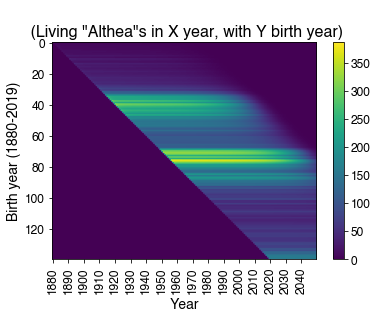

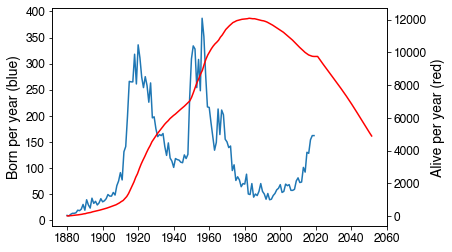

In [9]:
#OPTIONAL VISUALIZATION: THIS ONE IS HANDY

if 1:
    #Example life of name:

    nameind = 1948

    fig, ax = plt.subplots(1,1)
    im = plt.imshow(namelife_F_full[nameind,:,:])
    ax.set_title('\n (Living "' + str(namelife_F_name[nameind]) + '"s in X year, with Y birth year)')
    ax.set_xlabel('Year')
    ax.set_xticks(np.arange(0,2050-1880,10))
    ax.set_xticklabels(np.arange(1880,2050,10), rotation=90)

    plt.ylabel('Birth year (1880-2019)')
    plt.colorbar(im)
    plt.show()

    ax = plt.subplot(1,1,1)
    ax.plot(namebirth_F[nameind,:])
    ax2 = ax.twinx()
    ax2.plot(namelife_F_base[nameind,:], color='red')
    # ax.plot([139, 139],[0,4.5e10],color=[0,0,0,0.1])
    #ax.set_xlim([0,138])
    year_x = [0,20,40,60,80,100,120,140,160,180]
    ax.set_xticks(year_x)
    year_tick = (np.array(year_x)+1880).astype('str')
    ax.set_xticklabels(year_tick)
    ax.set_ylabel('Born per year (blue)')
    ax2.set_ylabel('Alive per year (red)')
    plt.show()

In [10]:
#Takes well under 1 minute now.

#Average life-weighted year-of birth for each name for each year:
#DOES NOT CHECK WHETHER ANYONE IS STILL ALIVE IN X YEAR BEFORE 
#MATH, SO EXPECT DIVIDE BY ZERO ERRORS. NaNs are totally fine for
#showing lack of alive people, but not pretty coding.

#It is possible to do this with matrix multiplication. It would
#take WAY longer to get running right than me just running this. 

agevec = np.arange(1880,2020).T

aliveshape = namelife_M_full.shape
namelife_M_yob = np.zeros(namelife_M_base.shape)
namelife_sum = np.sum(namelife_M_full, axis=1)
for rowind in np.arange(0,aliveshape[0]):
    tempsum = namelife_sum[rowind,:]
    namelife_M_yob[rowind,:] = np.matmul(agevec, namelife_M_full[rowind,:,:]) / \
                               namelife_sum[rowind,:]

aliveshape = namelife_F_full.shape
namelife_F_yob = np.zeros(namelife_F_base.shape)
namelife_sum = np.sum(namelife_F_full, axis=1)
for rowind in np.arange(0,aliveshape[0]):
    namelife_F_yob[rowind,:] = np.matmul(agevec, namelife_F_full[rowind,:,:]) / \
                                namelife_sum[rowind,:]

/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/Users/chmullens/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


In [11]:
if showplot:
    plt.plot(np.arange(1880, 2050), namelife_M_base[0,:])
    plt.plot(np.arange(1880, 2050), 
             -1*(namelife_M_yob[0,:] - np.arange(1880,2050)))
    plt.title(namelife_M_name[0])
    plt.legend(['Number alive','Avg age'])
    plt.show()

In [12]:
#General notes:

#This would be a good place in the future to normalize by ESTIMATED
#births in a given birth year. It's reasonable to only use SSA-named
#births, but it's more likely to be a good representation of the 
#population if I scale name-set births up by the ratio of estimated
#total births to recorded births.

#How to do that: "Calculate estimated births" each year 1880+, multiply
#pop of each name by the ratio of estimated total births to names
#dataset births. 
#Options for calculating estimated births:
#    -Derive number of births from the census (feasible)
#    -Take the number of people alive of a given age, then scale the 
#     names alive to match (would be inaccurate due to immigration)

In [13]:
#The oldest male and female names in the US:

#OPTIONAL VISUALIZATION

if showplot:
    namrange = 20 #how many to look at
    print('\n\nThese are mostly birth names that appeared in few years, \
    and were held by few people.')

    #Target year: 2020, aka location 1880+140
    nameF_ageind = np.argsort(namelife_F_yob[:,140])
    ax = plt.subplot(1,1,1)
    ax.plot(namelife_F_yob[nameF_ageind,140][0:namrange])
    ax.set_xticks(range(namrange))
    ax.set_xticklabels(namelife_F_name[nameF_ageind][0:namrange], rotation=90)
    ax.set_title('Oldest female birth names')
    ax.set_ylabel('Average year of birth')
    plt.show()

    nameM_ageind = np.argsort(namelife_M_yob[:,140])
    ax = plt.subplot(1,1,1)
    ax.plot(namelife_M_yob[nameM_ageind,140][0:namrange])
    ax.set_xticks(range(namrange))
    ax.set_xticklabels(namelife_M_name[nameM_ageind][0:namrange], rotation=90)
    ax.set_title('Oldest male birth names')
    ax.set_ylabel('Average year of birth')
    plt.show()

In [14]:
#Common names by age:

#OPTIONAL VISUALIZATION

if showplot:
    fig = plt.figure(figsize=[12,10], facecolor='white')
    ax = plt.subplot(2,1,1)
    plt.grid(b=True, axis='x', color='gray')
    ax2 = plt.subplot(2,1,2)
    plt.grid(b=True, axis='x', color='gray')


    n_hold_M = 750000
    n_hold_F = 500000
    numscale = 6000

    #Collect maximum number of holders alive for each name
    namelife_F_max = namelife_F_base.max(1)
    #Collect year index at which that occurred
    namelife_F_max_yr = np.argmax(namelife_F_base, axis=1)
    #Collect the avg. yob at the year index at which that occurred
    namelife_F_max_yob = namelife_F_yob[np.arange(0,len(namelife_F_max)),namelife_F_max_yr]
    #Collect the names for which that max was above the target threshold
    chunk_F = namelife_F_max >= n_hold_F
    #Select the YOB for data that met criteria, then collect year index that sorts it by YOB
    sort_yr_F = np.argsort(namelife_F_yob[chunk_F,2020-1880])
    #Select the number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_alive = namelife_F_base[chunk_F,2020-1880][sort_yr_F]
    #Select the maximum number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_maxalive = namelife_F_max[chunk_F][sort_yr_F]
    #Select the YOB at maximum number of individuals alive for data that met criteria, sort by above index
    sort_yr_F_maxalive_yob = namelife_F_max_yob[chunk_F][sort_yr_F]

    #Repeat above for M
    namelife_M_max = namelife_M_base.max(1)
    namelife_M_max_yr = np.argmax(namelife_M_base, axis=1)
    namelife_M_max_yob = namelife_M_yob[np.arange(0,len(namelife_M_max)),namelife_M_max_yr]
    chunk_M = namelife_M_max >= n_hold_M
    sort_yr_M = np.argsort(namelife_M_yob[chunk_M,2020-1880])
    sort_yr_M_alive = namelife_M_base[chunk_M,2020-1880][sort_yr_M]
    sort_yr_M_maxalive = namelife_M_max[chunk_M][sort_yr_M]
    sort_yr_M_maxalive_yob = namelife_M_max_yob[chunk_M][sort_yr_M]


    xlims = [-2,max([sum(chunk_F), sum(chunk_M)])+1]
    ylims = [1920, 2010]

    n_hold = 300000

    # lin_1 = ax.plot(alivelist_M_yob[chunk_M,2020-1880][sort_yr_M]+1880, color='blue', linewidth=1)
    dot_1a = ax.scatter(x=np.arange(0,sum(chunk_M)),
                        y=sort_yr_M_maxalive_yob,
                        s=sort_yr_M_maxalive/numscale, 
                        color=[[.95,.95,.95]], edgecolor='tab:blue',zorder=5,label='Peak holders')
    dot_1b = ax.scatter(x=np.arange(0,sum(chunk_M)),
                        y=namelife_M_yob[chunk_M,2020-1880][sort_yr_M],
                        s=sort_yr_M_alive/numscale,
                        color='tab:blue', edgecolor='tab:blue',zorder=6,label='Current holders')
    ax.set_xticks(range(sum(chunk_M)))
    ax.set_xticklabels(namelife_M_name[chunk_M].iloc[sort_yr_M], rotation=90)
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)
    # ax.legend()


    # lin_2 = ax2.plot(alivelist_F_yob[chunk_F,2020-1880][sort_yr_F]+1880, color='red', linewidth=1)
    dot_1a = ax2.scatter(x=np.arange(0,sum(chunk_F)),
                        y=sort_yr_F_maxalive_yob,
                        s=sort_yr_F_maxalive/numscale, 
                        color=[[.95,.95,.95]], edgecolor='tab:red',zorder=5,label='Peak holders')
    dot_1b = ax2.scatter(x=np.arange(0,sum(chunk_F)),
                        y=namelife_F_yob[chunk_F,2020-1880][sort_yr_F],
                        s=sort_yr_F_alive/numscale,
                        color='tab:red', edgecolor='tab:red',zorder=6,label='Current holders')
    ax2.set_xticks(range(sum(chunk_F)))
    ax2.set_xticklabels(namelife_F_name[chunk_F].iloc[sort_yr_F], rotation=90)
    ax2.set_ylim(ylims)
    ax2.set_xlim(xlims)

    # plt.grid(axis='y', color=0.9)

    #proxy size labels:
    legendpts = np.array([n_hold, n_hold*3, n_hold*10]).astype('int64')
    scatter_for_legend = ax.scatter(x=[0,0,0], y=[0,0,0], 
                                    s=legendpts/numscale,
                                    c=[[1,1,1,0],[1,1,1,0],[1,1,1,0]]
                                   )
    scatter_for_legend_2 = ax.scatter(x=[0], y=[0],
                                      s=[1.5*legendpts[1]/numscale],
                                      c=['tab:blue'])
    scatter_for_legend_3 = ax.scatter(x=[0], y=[0],
                                      s=[1.5*legendpts[1]/numscale],
                                      c=[[.95,.95,.95]],
                                      edgecolor=['tab:blue'])
    handles, labels = scatter_for_legend.legend_elements(prop="sizes", alpha=0.2)
    handles_2, labels_2 = scatter_for_legend_2.legend_elements(prop="sizes", alpha=1, color=[.25,.5,.85])
    handles_3, labels_3 = scatter_for_legend_3.legend_elements(prop="sizes", alpha=1, color=[.95,.95,.95])
    # legend = ax.legend(handles=handles+[]+handles_2+handles_3,
    #                    labels=['{0:,}'.format(m) for m in legendpts]+[]+['Living', 'Peak'],
    #                    loc="center right",
    #                    handletextpad=3,
    #                    labelspacing=1,
    #                    framealpha=1,
    #                    title="Number of holders"
    #                   )
    legend = ax.legend(handles=handles+[]+handles_2+handles_3,
                       labels=['{0:,}'.format(m) for m in legendpts]+[]+['Living', 'Peak'],
                       loc="center right",
                       handletextpad=3,
                       labelspacing=1,
                       framealpha=1,
                       title="Number of holders"
                      )

    ax.set_title('All US birth names that reached more than {0:,}(M) or {1:,}(F) holders alive'.format(n_hold_M,n_hold_F))
    ax.set_ylabel('Year of birth (M)')
    ax2.set_ylabel('Year of birth (F)')
    # fig.set_ylabel('Average year of birth for holders')
    # ax2.set_ylabel('Average year of birth for holders living in 2020')
    fig.tight_layout()

    plt.show()

In [15]:
#Assign names aliveness ranks by year
aliverank_M_yr = np.full(namelife_M_base.shape, np.nan)
for n in range(aliveshape[2]):
    tempset = namelife_M_base[:,n] != 0
    aliverank_M_yr[tempset,n] = np.argsort(-namelife_M_base[tempset,n])
aliverank_F_yr = np.full(namelife_F_base.shape, np.nan)
for n in range(aliveshape[2]):
    tempset = namelife_F_base[:,n] != 0
    aliverank_F_yr[tempset,n] = np.argsort(-namelife_F_base[tempset,n])

In [16]:
#Future comparisons:

#Stacked line plot of all high-count names (i.e. with >10,000 holders),
#with color of the swath for that name varying w/ avg age at the x-axis
#time. Large plot!

#Geographic names (cities, states, rivers?)
#Names and abbreviations (Lawrence and Larry, Christopher and Chris, 
#Robert and Bob/Rob, Richard and Rick/Dick, Harold and Harry, Thomas
#and Tom/Thom, etc.


# Begin visualization code

Below is the current visualization code. I am in the progress of optimizing this to work from a derived set of data, rather than calculating the full characteristic values for every name at every call. Currently, it uses a pair of matrices around (25000 | 40000) x 140 x 180 (~25k rows for male names, 40k rows for female names) which is a lot, but it could get by on the set of names/properties for each potential window and potential age. If I constrain the windows for year and age range to either 5 or 10 years and only save the top 100 names, then it's a (135+130) x (135+130) x 100 matrix for M and F each, cutting it down from >1 billion elements to ~15 million. 

From the user perspective, that would look like the user selecting a single year and a single age, then whether to use a window of 5 or 10 years around either.

In [17]:
#Goal colors: Plotly defaults, #EF553B (red), #636EFA (blue):
#https://www.rapidtables.com/convert/color/rgb-to-hsv.html
#HSV, red: 9deg, 75.3%, 93.7%
#HSV, blue: 236deg, 60.4%, 98.0%

In [18]:
#Convenience function to plot the births for a given name

def showname(name, sex):
    subdf = names_df_trim[(names_df_trim['Name']==name) & (names_df_trim['Sex']==sex)]
    plt.figure(figsize=[14,4])
    plt.bar(subdf['Year'],subdf['Number'])
    plt.xlim([1880,2020])
    plt.title(f'Number of {name} ({sex}) born per year')
    plt.show()

In [19]:
#Primary data visualization function: WORD CLOUD

def display_namecloud(namedict, agedict, target_range):
    
    #DISPLAY:
    #TODO: Use viridis_r for individual-name age colormap
    
    #Make a circle mask
    cscale = 1000
    x, y = np.ogrid[:cscale, :cscale]
    mask = (x - cscale/2) ** 2 + (y - cscale/2) ** 2 > (cscale/2-20) ** 2
    mask = 255 * mask.astype(int)

    built_cloud = WordCloud(background_color='white',
                            repeat=False, 
                            width=800, 
                            height=500,
                            max_font_size=250,
                            mask=mask)
    
    wcloud = built_cloud.generate_from_frequencies(namedict)

    fig, ax = plt.subplots(1,1, figsize=[10,10])
    ax.axis('off')
    #plt.imshow(wcloud, interpolation='bilinear')
    #plt.show()
    
    if target_range[2]=='F':
        hueval = 4
    else:
        hueval = 236
    
    #Alternative color pulled from:
    #https://amueller.github.io/word_cloud/auto_examples/a_new_hope.html
    #Also adapted from:
    #https://stackoverflow.com/questions/47143461/python-wordcloud-color-by-term-frequency
    
    #CONSIDER ALTERNATIVE:
    # colorsys.rgb_to_hls(200/255,100/255,200/255)
    
    #[120,360]
    hue_lim = [100,260] #cyan to magenta, through blue. Mean 240, full blue.
    sat_lim = [100,0]
    lit_lim = [80,0]
    age_lim = [target_range[1][0]-5,target_range[1][1]+5]
    def hue_scaler(num):
        #Simple linear transformation converts age from (n1)-5:(n2)+5 range to hsl_lim range
        tgt_hue = hue_lim[0] + (num - age_lim[0])*(hue_lim[1] - hue_lim[0]) / (age_lim[1] - age_lim[0])
        return tgt_hue
    def sat_scaler(num):
        #Scale from desat at old to colorful at young
        tgt_sat = sat_lim[0] + (num - age_lim[0])*(sat_lim[1] - sat_lim[0]) / (age_lim[1] - age_lim[0])
        #Scale saturation from middle (use 100,-100 for ex):
        #         if tgt_sat < (sat_lim[1] + sat_lim[0])/2:
        #             tgt_sat = sat_lim[1] - tgt_sat
        return min([100,max([tgt_sat,0])])
    def lit_scaler(num):
        tgt_lit = lit_lim[0] + (num - age_lim[0])*(lit_lim[1] - lit_lim[0]) / (age_lim[1] - age_lim[0])
        return min([100,max([tgt_lit,0])])
    
    def age_color_func(agedictionary):
        def my_tf_color_func_inner(word, font_size, position, orientation, random_state=None, **kwargs):
            temphue = hue_scaler(agedictionary[word])
            tempsat = sat_scaler(agedictionary[word])
            templit = lit_scaler(agedictionary[word])
            #print(agedictionary[word], tempcolor, tempsat)
            return f"hsl({hueval}, {tempsat:.0f}%, {templit:.0f}%)"
        return my_tf_color_func_inner
    
    plt.imshow(wcloud.recolor(color_func=age_color_func(agedict), random_state=3),
           interpolation="bilinear")
    plt.show()

In [20]:
#Primary data visualization function: SPARK(like) TREND LINES

def display_sparklines(namerange_data, target_range, n_names=15):
    
    #Define convenience variables:
    coh1 = target_range[0][0] - target_range[1][1] #Oldest cohort: first year minus oldest
    coh2 = target_range[0][1] - target_range[1][0] #Youngest cohort: last year minus youngest
    maxspecif = namerange_data[0].max() #Greatest name specificity, for scale
    
    #Initialize figure with subplots
    fig = make_subplots(n_names+1, 1, 
                        shared_xaxes=True,
                        specs = [[{}] for n in range(n_names+1)],
                        vertical_spacing = 0,
                       )
    
    #Set variables appropriately based on name sex
    if target_range[2]=='M':
        birthsource = namebirth_M
        linecol = 'blue'
        fillbase = 'rgb({0},{0},255)'
    else:
        birthsource = namebirth_F
        linecol = 'red'
        fillbase = 'rgb(255,{0},{0})'
    
    for i in np.arange(n_names)+1:
        #Define single-name convenience variables 
        peakval = birthsource[namerange_data[5][-1*i],:].max()
        yearscale = 1000*(target_range[0][1]-target_range[0][0]) #* (coh2 - coh1)
        avg_alive = namerange_data[1][-1*i]/()
        anno_text = '<b>' + namerange_data[4].iloc[-1*i] + '</b><br>' \
                    + '  Specificity: {0:.2f}<br>'.format(namerange_data[0][-1*i]/maxspecif) \
                    + '  Weight (~how many): {0:.0f}k'.format(namerange_data[1][-1*i]/yearscale)
        
        #Plotly plot generation
        #Add bounding box showing target birth years
        fig.add_trace(go.Scatter(x=[coh1, coh1, coh2, coh2],
                                 y=[0,1.2*peakval,1.2*peakval,0],
                                 fill="toself",
                                 mode='lines',
                                 line={'color':'gray'}
                                ), i+1, 1)
        #Add trace of name birth history
        fig.add_trace(go.Scatter(x=np.arange(1880,2050), 
                                 y=birthsource[namerange_data[5][-1*i],:],
                                 mode='lines', 
                                 line={'color':linecol,
                                       'width':max(5*peakval**0.75/100_000**0.75, 0.5)},
                                 name=namerange_data[4].iloc[-1*i],
                                 fill='tozeroy',
                                 fillcolor=fillbase.format(255 - 255*peakval/100_000),
                                ), i+1, 1)
        #Add text stating specificity/weight specifically
        fig.add_annotation(xref='x{}'.format(i+1), yref='y{}'.format(i+1),
                           x=2020, y=0.52*peakval,
                           text=anno_text,
                           showarrow=False,
                           align='left',
                           xshift=100)
        #Format subplot
        fig.update_xaxes(showgrid=False,
                         ticks='',
                         showticklabels=False,
                         range=[coh1-40, coh2+40],
                         domain=[0,.6],
                         zeroline=False,
                        )
        
    fig.update_yaxes(showgrid=False, ticks='', showticklabels=False)
    fig.add_annotation(xref='x1', yref='y1',
                       x=np.mean([coh1, coh2]), y=0.5*peakval,
                       text='<b>Names for ages {0}-{1} in {2}-{3} ({4}):</b>'
                           .format(target_range[1][0],
                                   target_range[1][1],
                                   target_range[0][0],
                                   target_range[0][1],
                                   target_range[2]
                                  ),
                       showarrow=False,
                       align='left',
                       xshift=100)
    fig.update_layout(template=None, 
                      height=n_names*(100*0.55), 
                      width=500,
                      margin={'t':0,'b':0},
                      showlegend=False,
                     )

    fig.show()

In [21]:
#Primary data visualization function: GENERATE VALUES AND CALL VIS-DISPLAY FUNCTION

def get_era_names(target_range, 
                  n_names=25, 
                  show_scores=False, 
                  justpopular=False, 
                  displayfunc=display_sparklines):

    #This function generates the numbers used in the visualization function.
    
    #We want to look at the 20-30 range for each of 4 years, for example
    #Year targets: n1-1880, n2-1880
    year1 = target_range[0][0] - 1880
    year2 = target_range[0][1] - 1880

    coh1 = year1 - target_range[1][1] #Oldest cohort: first year minus oldest
    coh2 = year2 - target_range[1][0] #Youngest cohort: last year minus youngest
    
    #POSSIBLE TUNE-UP TO INCREASE SPECIFICITY:
    #Weight by how many years each cohort was in that range, not just by
    #whether they were in the range at all.
    
    s = target_range[2]
    
    if s=='F':
        #How many person-years were lived in the target:
        totaltgt = np.sum(namelife_F_full[:, coh1:coh2, year1:year2], axis=(1,2))
        #How many person-years were lived outside the target:
        totalnon = np.sum(namelife_F_full, axis=(1,2))
        #(Could narrow to comparing against the time window only to
        #limit the impact of the same people being alive before/after,
        #but this way makes sure people born after get counted in)
    elif s=='M':
        totaltgt = np.sum(namelife_M_full[:, coh1:coh2, year1:year2], axis=(1,2))
        totalnon = np.sum(namelife_M_full, axis=(1,2))
    else:
        print('Gender options in social security name data are M or F')
        return None
        
    #Calculate what percent of name's person-years happened in that window
    name_specificity = totaltgt/totalnon
    #Weight by total number with that name in the window
    name_weight = totaltgt
    #Calculate score: sqrt(number in window) times the specificity
    name_score = 10 * np.sqrt(name_weight) * name_specificity**2
    #Grab the average age for all nameholders during the window
    if s=='F':
        #Calculate mean year of the range, then subtract the mean
        #year of birth (per name, :) across the range
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_F_yob[:,year1:year2+1], axis=1)
    else:
        name_ages = (1880*2+year1+year2)/2 - np.mean(namelife_M_yob[:,year1:year2+1], axis=1)
    
    #Grab the names themselves
    if s=='F':
        name_outs = namelife_F_name
    else:
        name_outs = namelife_M_name
    
    if justpopular:
        #If you're just looking for most popular:
        nameinds = np.argsort(name_weight)
    else:
        #If you're looking for most representative (DEFAULT):
        nameinds = np.argsort(name_score) #defaults to asc

    namedict = {}
    agedict = {}
    for n in range(n_names):
        dictkey = name_outs[nameinds].iloc[-(n+1)]
        if justpopular:
            namedict[dictkey] = int(name_weight[nameinds][-(n+1)])
        else:
            namedict[dictkey] = int(name_score[nameinds][-(n+1)])
        agedict[dictkey] = name_ages[nameinds][-(n+1)] 
        
    namerange_data = (name_specificity[nameinds],
                      name_weight[nameinds],
                      name_score[nameinds],
                      name_ages[nameinds],
                      name_outs[nameinds],
                      nameinds
                     )

    #Visualization subfunction: WORDCLOUD    
    display_namecloud(namedict, agedict, target_range)
    display_sparklines(namerange_data, target_range, n_names=n_names)
    
    #Visualization subfunction: DEFAULT SPARKLINE
    #displayfunc(namerange_data)

    if show_scores:
        print('Specificity, weight, score, avg. age, name:')
        for item in zip(np.round(name_specificity[nameinds][::-1][:n_names],3),
                 np.round(name_score[nameinds][::-1][:n_names],2),
                 np.round(name_ages[nameinds][::-1][:n_names],2),
                 name_outs[nameinds][::-1][:n_names]):
            print(item)
    
    return namerange_data






# Characteristic names: 

Based on a given era and a given age range, can we find names that feel right? 

We're looking for names that are at least fairly common, so you'd expect to see them, but also names that are *uncommon* outside the target range.

The second visualization is close to deployable, Plotly is simple to get html for.

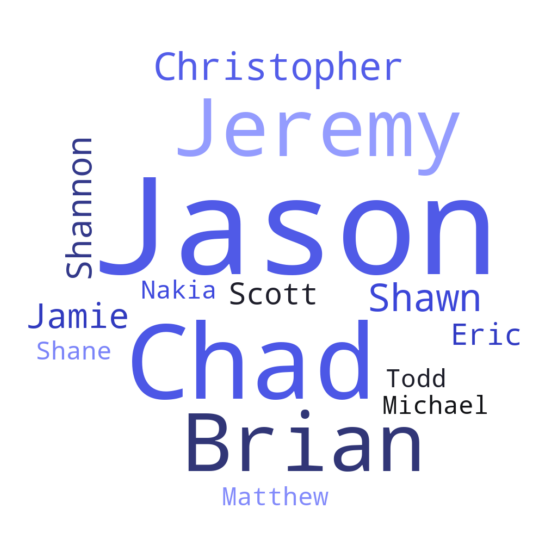

In [22]:
target_range = [[1995, 2000], [20,25], 'M'] #years, age, sex

namerange_data = get_era_names(target_range, n_names=15)

In [23]:
#OPTIONAL VISUALIZATION: Specificity vs. number alive. Good for
#eyeballing how the score algorithm balances between the two.

#Could use a tune-up. Size could show number alive, for example.
if showplot:
    ann_num = 10
    plt.figure(figsize=[10,6])
    plt.scatter(namerange_data[0], namerange_data[1], c=namerange_data[2])
    for n in range(-1*ann_num,0):
        plt.annotate(text=namerange_data[4].iloc[n], 
                     xy=(namerange_data[0][n], namerange_data[1][n]),
                     xytext=(2,2),
                     textcoords='offset points',
                     rotation=30
                    )
    plt.xlabel("Specificity: Fraction of name's years that were lived in range")
    plt.ylabel('Weight: Number of name-years lived')
    plt.ylim([-200000, 1.15*max(namerange_data[1])])
    plt.box()
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Characteristicness Score')
    plt.title('Years: {}, Ages: {}, Sex: {}'.format(target_range[0], target_range[1], target_range[2]))
    plt.show()





# Name clustering and prediction:

In short, based on the properties of the names we know of, predict whether a name will increase or decrease in a given year. Currently on version 1, a simple Ridge. Below are notes on how the clustering will work and future improvements and projects that would improve the function. 


### Notes on name similarity clustering:

**The goal:** Cluster names based on how similarly they are spelled or pronounced. 

Let's start with the spelling, since the pronunciation similarity has additional layers of complexity. 

Let's start with the spelling; I'll be using Levenshtein distance as a starting point, which is a very convenient measure of how similar two words are to one another, also known as the "edit distance". It doesn't take into account the fact that there some letters are more similar to one another than others (i.e. "a" is drastically more like "e" than "q"), but it's a great start, and I can update the distance algorithm as I go. (The more complex letter similarity is probably most appropriately handled in the pronunciation clustering, anyway.)

So! The core tech here is going to be **affinity propagation**. For that, we need similarity measures between each pair of words, which to reiterate will be the Levenshtein distance. 

Minor problem: Using the current set of names, the number of comparisons is big. The **total number of comparisons is O(n²)**, which is not good when you have a set of 100,000 names. I'm going to have to prune this. I'll be focusing on the most relevant names, i.e. those which met a certain threshold of use. One possible threshold: maximum number of people who have had that name at any time. You can see in the plot below what this ends up looking like. You can also see that the name distribution follows a pretty clear pattern. 

In short, to keep our number of comparisons reasonable, **we'll limit it based on peak holders alive.** We can calculate which clusters additional names would fit in pretty easily, but for the clustering itself, this may be close to the outer limits of what we can practically do with affinity propagation using this precomputed distance.

**PROBABLE FUTURE ADDITION:**  
Pre-group names with IDENTICAL predicted pronunciations, THEN get the top set. That will, for example, catch the literally 40 different ways of spelling "Abigail" under a single umbrella, or the "Brayden/Breighdon" etc. name clan.

## Collecting pronunciations for clustering:

In [24]:
#PRONUNCIATION:

#Calculate word pronunciation based on the Datamuse API response.
#Works fairly well, though some names such as Abrielle get lumped
#together with Gabrielle in pronunciation, as it assumes it has a
#leading G. 
#
#https://api.datamuse.com/words?sl=mackenzie&md=r
#
#This API call returns both a word's pronunciation and words that
#sound like it.

import string
from ediblepickle import checkpoint

#Generate checkpoint data for each function call, which goes in
#the "name_pronunciation_storage" directory. Note that this will
#run identical names twice, once each for male or female, but the
#Datamuse API does not use this information. Could be optimized, 
#but the load process is very quick. 

@checkpoint(key=string.Template('name_pronunc_{0}_{1}.pkl'), work_dir='name_pronunciation_storage', refresh=False)
def get_name_pronunc(name, sex):
    #Define core API call, which works great with the word itself at the end
    baseapi = 'https://api.datamuse.com/words?md=r&ipa=1&sl='
    #Get page response for api+name.
    
    #V1: Use futuressessions
    #REQUIRES THAT A FUTURESSESSION BE ACTIVE! "session = FuturesSession()"
    resp = session.get(baseapi + name)
    #Pull out just the content
    pagecont = resp.result().content
    pagetext = resp.result().text
    
    #V2: Use a standard request
    #resp = requests.get(baseapi + name)
    #pagecont = resp.content
    #pagetext = resp.text
    
    #Fairly messy way to do this, probably ought to use a class
    sylstart = pagetext.find('numSyllables')
    syl = int(pagetext[sylstart+14])
    arpastart = pagetext.find('pron:')
    arpastop = pagetext.find('"', arpastart)
    arpa = pagetext[arpastart+5:arpastop]
    ipastart = pagetext.find('ipa_pron:')
    ipastop = pagetext.find('"', ipastart)
    ipa = pagetext[ipastart+9:ipastop]
    
    #print(ipa)
    pronunc = []
    pronunc.append(syl)
    pronunc.append(arpa)
    pronunc.append(ipa)
    time.sleep(0.05)

    return pronunc, pagetext

In [25]:
%%time

redo_pronunc = False
#Should functionize this. Takes about a minute to run through
#the whole thing IF you're loading again, since the name data
#loads from checkpoint. If the data is not checkpointed yet,
#the initial collection takes multiple hours. 

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_F = {}
    all_pagecont_F = []

    for name in namelife_F_name:
        pronunc, pagecont = get_name_pronunc(name, 'F')
        all_pronunciations_F[name] = pronunc
        all_pagecont_F.append(pagecont)
        
    with open('all_pronunciations_F.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_F, fname)
        
else:
    with open('all_pronunciations_F.pkl', 'rb') as fname:
        all_pronunciations_F = pickle.load(fname)

if redo_pronunc:
    session = FuturesSession()
    all_pronunciations_M = {}
    all_pagecont_M = []

    for name in namelife_M_name:
        pronunc, pagecont = get_name_pronunc(name, 'M')
        all_pronunciations_M[name] = pronunc
        all_pagecont_M.append(pagecont)
        
    with open('all_pronunciations_M.pkl', 'wb') as fname:
        pickle.dump(all_pronunciations_M, fname)
        
else:
    with open('all_pronunciations_M.pkl', 'rb') as fname:
        all_pronunciations_M = pickle.load(fname)
    

CPU times: user 109 ms, sys: 88.7 ms, total: 197 ms
Wall time: 202 ms


In [26]:
#OLD CONTENT: (works, but not functionized)

# session = FuturesSession()
# baseapi = 'https://api.datamuse.com/words?md=r&sl='
#
# temptime = time.time()
# all_responses_F = []
# all_pronunciations_F = []
# for name in alivelist_F_name[:1000]:
#     resp = session.get(baseapi + name)
#     pagecont = resp.result().content
#     time.sleep(0.05)
#     all_responses_F.append(pagecont)
#
#     #find the pronunciation tag itself:
#     startpt = pagecont.find(b'tags')
#     endpt = pagecont.find(b']', startpt)
#     all_pronunciations_F.append(pagecont[startpt+8:endpt])
#   
# all_pronunciations_M = []
# for name in alivelist_M_name[:1000]:
#     resp = session.get(baseapi + name)
#     time.sleep(0.05)
#     all_pronunciations_M.append(resp)
#
# print(time.time() - temptime)




In [27]:
#     #saved earlier, copied here for reference convenience

#     names_df_trim = pd.read_pickle('names_df_trim.pkl')
#     #saved above if refresh
#     namelife_F_full = np.load('namelife_F_full.npy')
#     namelife_F_base = np.load('namelife_F_base.npy')
#     namelife_F_name = pd.read_pickle('namelife_F_name.pkl')
#     namebirth_F = np.load('namebirth_F.npy')
#     namelife_M_full = np.load('namelife_M_full.npy')
#     namelife_M_base = np.load('namelife_M_base.npy')
#     namelife_M_name = pd.read_pickle('namelife_M_name.pkl')
#     namebirth_M = np.load('namebirth_M.npy')

In short, the pronunciations are very reasonable in most cases, though they do look like they sometimes default to a known pronunciation when words are spelled similarly enough (for example, some of the "Abrielle"-style names actually get a "Gabrielle" pronunciation). There's a "Lebronjames" in

## Plan subset of data for clustering:

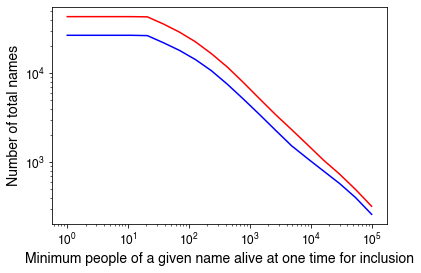

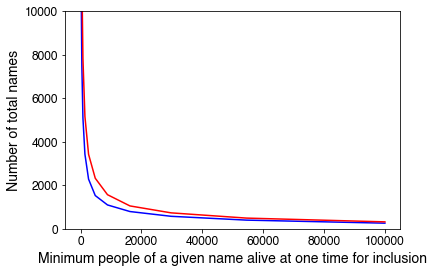

note: set is now lightly trimmed coming in, so small thresholds do little
Total male names >50: 20203
Total female names >50: 32700
Total male names >5000: 1500
Total female names >5000: 2265


In [28]:
#Compare how many names you keep depending on your cutoff threshold
#for whether a name has enough holders (requires hand-tuning, should
#include the code from the earlier )

commons_list_M = []
commons_list_F = []
#Test thresholds of 1-100000, using 20 log steps
testvals = np.logspace(0,5,20)
for n in testvals:
    commons_list_M.append(sum(namelife_M_base.max(1) > n))
    commons_list_F.append(sum(namelife_F_base.max(1) > n))
    
plt.loglog(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.show()
plt.plot(testvals, commons_list_M, 'b', testvals, commons_list_F, 'r')
plt.xlabel('Minimum people of a given name alive at one time for inclusion')
plt.ylabel('Number of total names')
plt.ylim([0,10000])
plt.show()

#A couple specific test values:
thresh1 = 50
thresh2 = 5000
commons_M_1 = namelife_M_base.max(1) > thresh1
commons_F_1 = namelife_F_base.max(1) > thresh1
commons_M_2 = namelife_M_base.max(1) > thresh2
commons_F_2 = namelife_F_base.max(1) > thresh2

#Total names:
print('note: set is now lightly trimmed coming in, so small thresholds do little')
print('Total male names >{}: '.format(thresh1) + str(sum(commons_M_1)))
print('Total female names >{}: '.format(thresh1) + str(sum(commons_F_1)))
print('Total male names >{}: '.format(thresh2) + str(sum(commons_M_2)))
print('Total female names >{}: '.format(thresh2) + str(sum(commons_F_2)))

In [29]:
#Name test sets:

thresh=5000

nametest_M_inds = namelife_M_base.max(1) > thresh

nametest_M_name = namelife_M_name[nametest_M_inds]
nametest_M_pron = pd.Series([all_pronunciations_M[tempname][2] for tempname in nametest_M_name])
nametest_M_pronA = pd.Series([all_pronunciations_M[tempname][1] for tempname in nametest_M_name])
nametest_M_num = namelife_M_base[nametest_M_inds].max(1)
nametest_M_birth = namebirth_M[nametest_M_inds,:]

nametest_F_inds = namelife_F_base.max(1) > thresh
nametest_F_name = namelife_F_name[nametest_F_inds]
nametest_F_pron = pd.Series([all_pronunciations_F[tempname][2] for tempname in nametest_F_name])
nametest_F_pronA = pd.Series([all_pronunciations_F[tempname][1] for tempname in nametest_F_name])
nametest_F_num = namelife_F_base[nametest_F_inds].max(1)
nametest_F_birth = namebirth_F[nametest_F_inds,:]

#Raw name test set:
nametest_S_name = np.concatenate([nametest_M_name, nametest_F_name])
nametest_S_pron = np.concatenate([nametest_M_pron, nametest_F_pron])
nametest_S_pronA = np.concatenate([nametest_M_pronA, nametest_F_pronA])

# Name fitting thoughts:

First up, basically time course fitting like this should maybe be done using a RNN (Recurrent Neural Network) in Tensor Flow, it's implemented well with Keras apparently. Second up, how do we get to a large set of predicted outcomes from a similarly-large set of data?

**1. What is the target outcome?**

First option: Predict how popular a given name *should* be in a given year, based on popularity of other names and the name's own popularity in the last, say, five years. Why is this hard? Large number of names. There's a high likelihood of overfitting, among other things. 

Second option: Much simpler, just use the time course correlation between different names over, say, the last 40 years to determine their similarity today. This allows grouping. 

Additional option: Predict name frequency in a given year based on number of each other name currently alive, and their ages (or age structure). This is likely to actually be possible and interesting. 

**2. What to compare?**

Options: Graph distance (Affinity Propagation, Spectral Clustering, Markov Clustering (MCL)?b)

More detailed spelling comparison: Bonus points for contiguous runs of letters that do not change? Shared syllable-equivalents?

Simple option: Semi-manual clustering. Names with identical pronunciation are automatically clustered, along with names with no more than one letter difference. 


**ASSORTED ADDITIONAL FEATURES:**  
-Letters (bag of words style) (include capitals for catching initial letters!)  
-Letter bigrams bag  
-Pronunciation bag  
-Pronunciation bigrams bag  

-Next-letter prediction? I've seen this done, could be interesting. 

-Clustering time-series!
https://www.researchgate.net/publication/4756297_Model-Based_Clustering_of_Multiple_Time_Series.
Looks like it would be a bit of a pain to implement, but potentially really interesting. 

In [30]:
from sklearn.cluster import AffinityPropagation

#Using the distance module for Levenshtein because sure
import distance

In [31]:
print(nametest_S_name.shape, nametest_M_name.shape, nametest_F_name.shape)

(3765,) (1500,) (2265,)


In [32]:
%%time

#This is a costly part. Takes about 7 minutes at a threshold of >5000 alive.

#Borrowing from code:
#https://stats.stackexchange.com/questions/123060/clustering-a-long-list-of-strings-words-into-similarity-groups
#https://stackoverflow.com/questions/21511801/text-clustering-with-levenshtein-distances

#pronA takes noticeably more time, since the strings are longer. 

lev_similarity_name = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_name] for nameM2 in nametest_M_name])
lev_similarity_pron = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pron] for nameM2 in nametest_M_pron])
lev_similarity_pronA = 1-np.array([[distance.nlevenshtein(nameM1,nameM2) for nameM1 in nametest_M_pronA] for nameM2 in nametest_M_pronA])

CPU times: user 7min, sys: 810 ms, total: 7min 1s
Wall time: 7min 2s


In [39]:
%%time

#Not very costly. Once the similarity matrices are built, the cluster fitting
#only takes a few seconds.

#Set up a near-default affinity propagation instance
affprop_M_name = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
affprop_M_pron = AffinityPropagation(affinity='precomputed', preference=0, random_state=None)
# affprop_M_pronA = AffinityPropagation(affinity='precomputed', preference=0) #Basically doesn't converge.

affprop_M_name.fit(lev_similarity_name)
affprop_M_pron.fit(lev_similarity_pron)
# affprop_M_pronA.fit(lev_similarity_pronA)

#The ARPABET pronunciation does not really converge on its own,
#looks like it may not cluster very neatly on its own. 

#However, as an additional perspective on pronunciation, it's 
#probably still useful to add. In practice, the clusters do 
#seem to make more sense when it's included.

#After fiddling with it a little, the most "sensible" clusters seem
#to come from weighting the pronunciations at about .75 apiece, so
#they make up more than half the total but less than double the
#spelling weight. 

affprop_M_triple = AffinityPropagation(affinity='precomputed', preference=0.1, random_state=None)
affprop_M_triple.fit(lev_similarity_name + 0.75*lev_similarity_pron + 0.75*lev_similarity_pronA)

CPU times: user 7.78 s, sys: 69.4 ms, total: 7.85 s
Wall time: 7.88 s


AffinityPropagation(affinity='precomputed', preference=0.1, random_state=None)

#### Affinity propagation notes:

The IPA pronunciation-difference Levenshtein similarity is not very good. It would probably be better to implement the ARPABET pronunciations, since that model contains useful information about sound similarity based on just the characters present in each sound's codeb. That will take a lot more work, since it'd be effectively two-level Levenshtein, I'd have to think about how to reconcile that. 

One way would be instead of "one-character substitution" you could implement "character difference". For example, the "A" in "Adrian" is "EY1", where the "A" in "Andrew" is "AE1". That would be a Levenshtein distance of 2 (one subtraction to E1, one addition to AE1, or other ways to get there). Okay so that's not necessarily the greatest, since it would give a normalized Levenshtein of 0.66 (2/3 difference) when the sounds are reasonably similar, but it's still better than the complete difference that IPA would give. Character addition/subtraction would still be a binary scale. 

(Tried to find a measure of how "far apart" different vowels are, but the data isn't included in a paper that does what looks like a good job of it: http://www.martijnwieling.nl/files/Interspeech2013-FTetal.pdf)

In [40]:
tgt_affprop = affprop_M_triple
tgt_namebirth = namebirth_M

print(len(np.unique(tgt_affprop.labels_)))
for cluster_id in np.unique(tgt_affprop.labels_):
    exemplar = nametest_M_name.iloc[tgt_affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(nametest_M_name.iloc[np.nonzero(tgt_affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print(" - *%s:* %s" % (exemplar, cluster_str))
    
#Functionally, some of this is tracking what sounds are popular, which is fine.

#The clusters are more or less sensible. Some names don't fit in very well; may
#want to consider once again trying to hunt down an algorithm that's more willing
#to leave solo clusters, because some of these names just flat don't fit very well
#with any other name. 

166
 - *Abdiel:* Abdiel, Abdul, Abdullah, Adriel, Uriel
 - *Addison:* Addison, Anderson, Atticus, Edison, Madison
 - *Aden:* Abe, Abel, Adan, Aden, Adolph, Aidan, Aiden, Alden, Amos, Aydan, Ayden, Aydin, Eden, Owen
 - *Alan:* Adam, Alan, Alec, Alex, Allan, Allen, Alva, Alvin, Asa, Atlas, Ethan, Ian, Milan, Olen
 - *Alexander:* Alexander, Alexandro, Alexzander
 - *Ali:* Al, Aldo, Ali, Alijah, Ari, Ashley, Eli, Ollie, Raleigh
 - *Alonso:* Adolfo, Adonis, Alfonso, Alfredo, Alonso, Alonzo, Alphonse, Alphonso, Alvaro, Antonio, Armando, Eliseo, Emiliano, Enzo, Orlando
 - *Amari:* Aarav, Amare, Amari, Armani, Isai, Jamari, Kamari, Malachi, Malakai, Omari
 - *Andres:* Anders, Andre, Andrea, Andreas, Andres, Andrew
 - *Anton:* Anson, Anthony, Antoine, Anton, Antony, Antwan, Antwon, Ashton, Unknown
 - *Archer:* Abner, Archer, Archie, Arthur, Asher, Oliver
 - *Arian:* Adrian, Adrien, Arian, Ariel, Arjun, Aron, Arron, Aryan, Orval, Uriah
 - *Bennie:* Ben, Benedict, Bennett, Bennie, Benny, Bentley,

In [41]:
#Example name comparison

testname1 = 'Andrew'
testname2 = 'Adrian'

print('Example name comparison with eye toward comparing sounds later:\n')
print(testname1)
print(all_pronunciations_M[testname1])
print(testname2)
print(all_pronunciations_M[testname2])
print('\nSpelling Lev:')
print(distance.nlevenshtein(testname1,testname2))
print('IPA Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][2], all_pronunciations_M[testname2][2]))
print('ARPABET Lev:')
print(distance.nlevenshtein(all_pronunciations_M[testname1][1], all_pronunciations_M[testname2][1]))

sound1 = all_pronunciations_M[testname1][1].split()[0]
sound2 = all_pronunciations_M[testname2][1].split()[0]
print('ARPABET first sound Lev: ' + sound1 + ' vs ' + sound2)
print(distance.nlevenshtein(sound1, sound2))

Example name comparison with eye toward comparing sounds later:

Andrew
[2, 'AE1 N D R UW0 ', 'ˈændru']
Adrian
[3, 'EY1 D R IY0 AH0 N ', 'ˈeɪdriʌn']

Spelling Lev:
0.6666666666666666
IPA Lev:
0.625
ARPABET Lev:
0.6111111111111112
ARPABET first sound Lev: AE1 vs EY1
0.6666666666666666


In [42]:
#Generate cluster timecourses:

cluster_courses = np.zeros([len(np.unique(tgt_affprop.labels_)),nametest_M_birth.shape[1]])
for i,cluster_id in enumerate(np.unique(tgt_affprop.labels_)):
    cc = nametest_M_birth[tgt_affprop.labels_==cluster_id,:]
    cluster_courses[i,:] = np.sum(cc, axis=0)
    
#Normalize to year total -> fraction of year's births in X cluster
cc_norm = cluster_courses/np.sum(cluster_courses, axis=0)
#Normalize from fraction of year to standard scale
cc_norm2 = (cc_norm - np.mean(cc_norm, axis=1).reshape(-1,1))/np.std(cc_norm, axis=1).reshape(-1,1)

# plt.plot(cc_norm.T)
# plt.show()

Aarav
-11.229992210729286


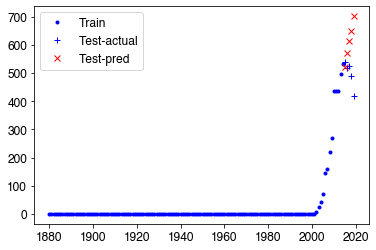

Aaron
-1.389897166991637


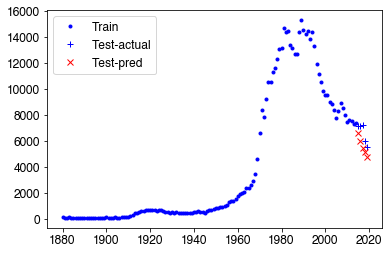

Abdiel
-1.3584061092677606


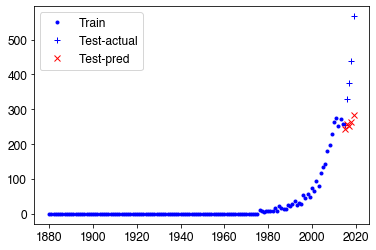

Abdul
-451.09017315007037


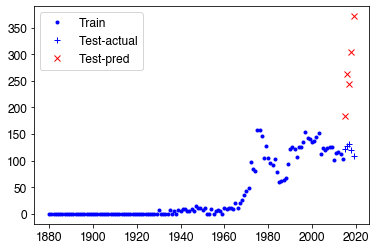

Abdullah
-52.832880989004536


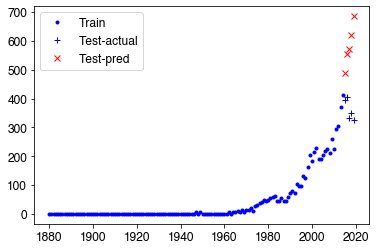

Abe
-60.366502279963534


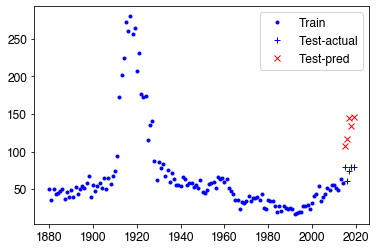

Abel
-12.747988938057643


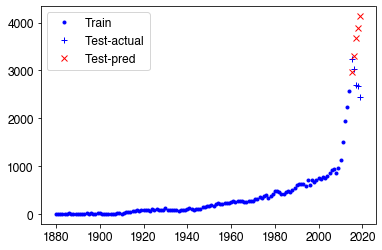

Abner
-186.03799125566456


Abraham
-2.9793298109260578


Abram
-11.9382441707096


Ace
0.6234371346231002


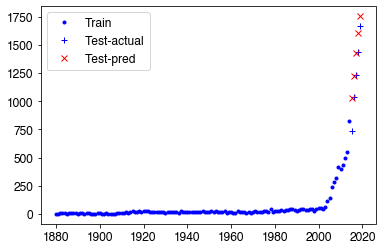

Adam
-15.361951574133354


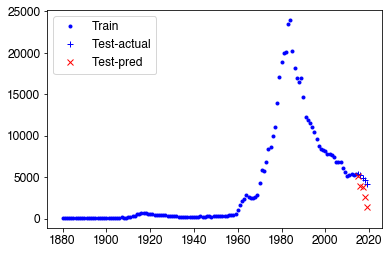

Adan
-5.568630248389889


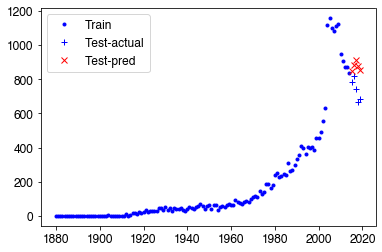

Addison
-1.205475448001136


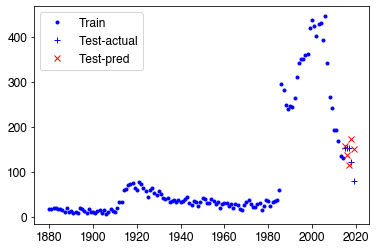

Aden
-4.019172273981202


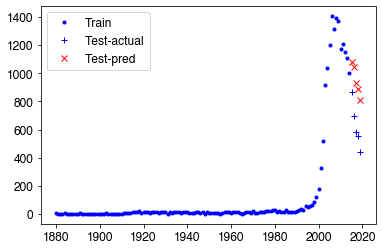

Adolfo
-49.861603489368655


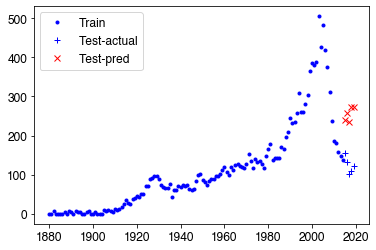

Adolph
-4256.086681146616


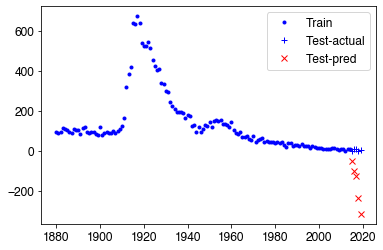

Adonis
-3.8233512409299175


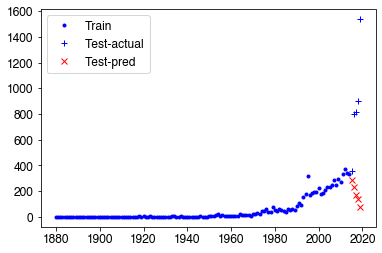

Adrian
0.2915178318723045


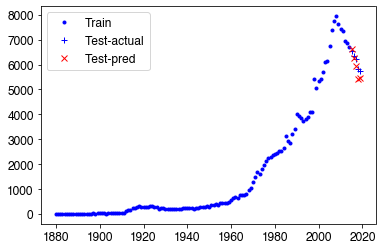

Adriel
-4.663510136196241


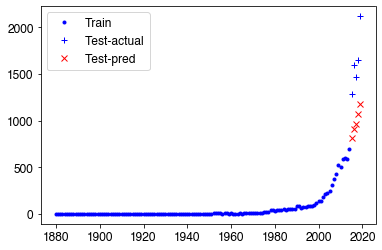

Adrien
-352.7182376451182


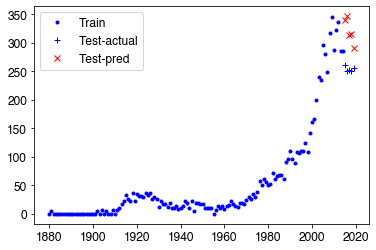

Agustin
-62.36007558426367


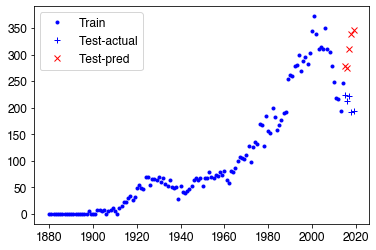

Ahmad
-9.542372665368775


Ahmed
-5.297840721508


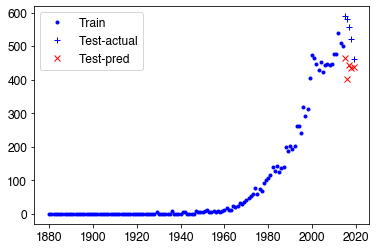

Aidan
-15.869793806802527


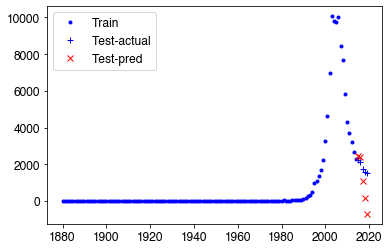

Aiden
-0.9128865225182701


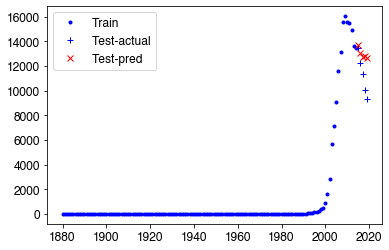

Akeem
-37.92227076130853


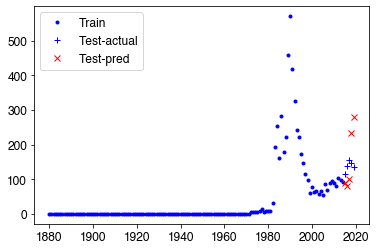

Al
-1273.8721544998982


Alan
-47.201906559997916


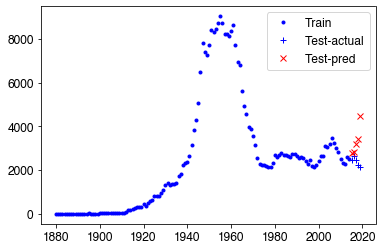

Albert
-649.5491839834087


In [43]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split

#Fit first-10 with visual verification:
name_linmodels = []

#The scores are often terrible, because it's comparing versus
#using the mean of the KNOWN data, but visually inspecting the
#first 30 or so it's actually doing a reasonable job in most
#cases. 
for n in range(30):
    lin_mod = Ridge(alpha=0.01)

    y_examp = nametest_M_birth[n,:].T
    X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

    #Random split:
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.25)
    #Year split:
    X_train, X_test, y_train, y_test = X_examp[:-5], X_examp[-5:], y_examp[:-5], y_examp[-5:]

    lin_mod.fit(X_train, y_train)
    
    y_pred = lin_mod.predict(X_test)
    
    print(nametest_M_name.iloc[n])
    print(lin_mod.score(X_test, y_test))
    
    plt.plot(X_train[:,-1], y_train, 'b.')
    plt.plot(X_test[:,-1], y_test, 'b+')
    plt.plot(X_test[:,-1], y_pred, 'rx')
    plt.legend(['Train','Test-actual','Test-pred'])
    plt.show()
    

Aarav: train 0.999, test 0.992, val -0.583 (0)


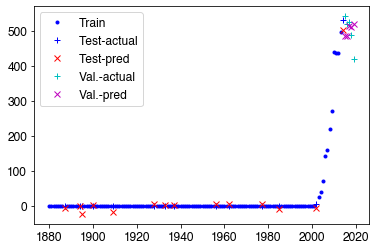

Aaron: train 1.000, test 0.995, val 0.231 (1)
Abdiel: train 0.999, test 0.991, val -0.511 (2)
Abdul: train 0.997, test 0.977, val -21.802 (3)
Abdullah: train 1.000, test 0.983, val -36.031 (4)
Abe: train 0.993, test 0.921, val -22.877 (5)
Abel: train 1.000, test 0.993, val -12.783 (6)
Abner: train 0.996, test 0.823, val -48.090 (7)
Abraham: train 1.000, test 0.992, val -3.837 (8)
Abram: train 0.999, test 0.982, val -16.240 (9)
Ace: train 0.999, test 0.990, val 0.795 (10)
Adam: train 1.000, test 0.996, val -8.201 (11)
Adan: train 0.999, test 0.992, val -16.879 (12)
Addison: train 0.999, test 0.953, val -2.626 (13)
Aden: train 1.000, test 0.994, val -5.093 (14)
Adolfo: train 0.998, test 0.946, val -15.002 (15)
Adolph: train 0.996, test 0.860, val -899.392 (16)
Adonis: train 0.996, test 0.937, val -1.964 (17)
Adrian: train 1.000, test 0.999, val 0.243 (18)
Adriel: train 1.000, test 0.994, val -5.384 (19)
Adrien: train 0.998, test 0.949, val -280.717 (20)


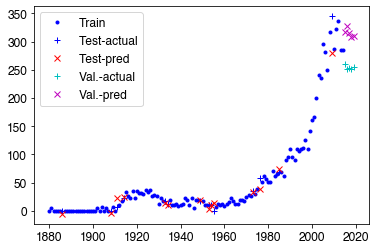

Agustin: train 0.999, test 0.985, val -58.407 (21)
Ahmad: train 0.999, test 0.953, val -12.279 (22)
Ahmed: train 0.999, test 0.994, val -4.944 (23)
Aidan: train 0.999, test 0.893, val -80.773 (24)
Aiden: train 1.000, test 0.997, val -1.383 (25)
Akeem: train 0.993, test 0.904, val -44.171 (26)
Al: train 0.997, test 0.912, val -387.908 (27)
Alan: train 0.999, test 0.982, val -27.182 (28)
Albert: train 0.999, test 0.988, val -90.849 (29)
Alberto: train 1.000, test 0.997, val -4.307 (30)
Alden: train 0.997, test 0.901, val -7.313 (31)
Aldo: train 0.994, test 0.932, val -7.873 (32)
Alec: train 0.999, test 0.998, val -3.323 (33)
Alejandro: train 1.000, test 0.993, val -5.669 (34)
Alessandro: train 1.000, test 0.965, val -5.709 (35)
Alex: train 1.000, test 0.995, val -4.195 (36)
Alexander: train 1.000, test 1.000, val -3.228 (37)
Alexandro: train 0.999, test 0.978, val -94.740 (38)
Alexis: train 0.998, test 0.906, val -6.868 (39)
Alexzander: train 1.000, test 0.999, val -10.121 (40)


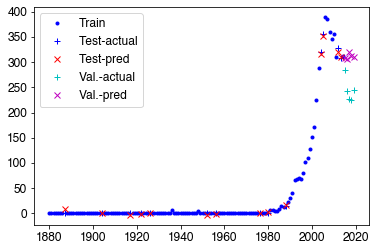

Alfonso: train 0.999, test 0.955, val -0.185 (41)
Alfred: train 0.998, test 0.887, val -69.234 (42)
Alfredo: train 0.999, test 0.994, val -54.415 (43)
Ali: train 1.000, test 0.996, val -32.775 (44)
Alijah: train 1.000, test 0.000, val -35.976 (45)
Allan: train 0.998, test 0.979, val -27.171 (46)
Allen: train 0.999, test 0.990, val -9.812 (47)
Alonso: train 0.999, test 0.991, val -0.897 (48)
Alonzo: train 0.995, test 0.977, val -5.177 (49)
Alphonse: train 0.996, test 0.939, val -59.213 (50)
Alphonso: train 0.996, test 0.936, val -18.117 (51)
Alton: train 0.998, test 0.950, val -93.066 (52)
Alva: train 0.996, test 0.791, val -168.153 (53)
Alvaro: train 0.998, test 0.980, val -52.995 (54)
Alvin: train 0.999, test 0.989, val -50.456 (55)
Amare: train 0.999, test 0.769, val -29.160 (56)
Amari: train 1.000, test 0.982, val -13.617 (57)
Amir: train 1.000, test 0.998, val -2.784 (58)
Amos: train 0.995, test 0.869, val -74.211 (59)
Anders: train 0.998, test 0.883, val -28.616 (60)


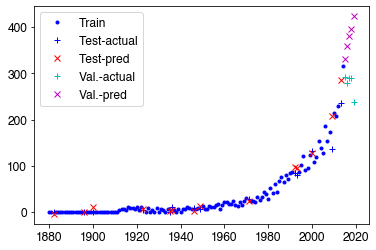

Anderson: train 1.000, test 0.804, val -20.817 (61)
Andre: train 1.000, test 0.993, val -20.492 (62)
Andrea: train 0.997, test 0.940, val -35.371 (63)
Andreas: train 0.999, test 0.923, val -41.490 (64)
Andres: train 1.000, test 0.990, val -30.479 (65)
Andrew: train 1.000, test 0.999, val 0.837 (66)
Andy: train 0.999, test 0.987, val -15.219 (67)
Angel: train 1.000, test 0.997, val -1.396 (68)
Angelo: train 0.999, test 0.970, val -4.078 (69)
Anson: train 0.996, test 0.911, val -0.714 (70)
Anthony: train 1.000, test 0.995, val 0.875 (71)
Antoine: train 1.000, test 0.993, val -8.839 (72)
Anton: train 0.992, test 0.820, val -125.273 (73)
Antonio: train 1.000, test 0.997, val 0.133 (74)
Antony: train 0.999, test 0.959, val -47.652 (75)
Antwan: train 0.999, test 0.998, val -37.798 (76)
Antwon: train 0.998, test 0.977, val -0.877 (77)
Archer: train 0.999, test 0.977, val -1.025 (78)
Archie: train 0.998, test 0.974, val 0.785 (79)
Ari: train 1.000, test 0.996, val -9.304 (80)


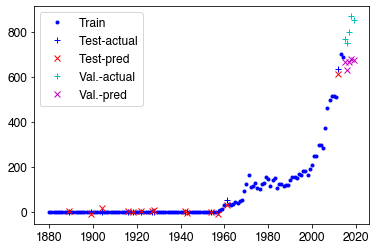

Arian: train 0.998, test 0.658, val 0.417 (81)
Aric: train 0.998, test 0.958, val -28.196 (82)
Ariel: train 0.998, test 0.969, val -9.825 (83)
Arjun: train 1.000, test 0.985, val -479.020 (84)
Arlo: train 0.996, test 0.654, val 0.087 (85)
Armand: train 0.994, test 0.940, val -170.914 (86)
Armando: train 1.000, test 0.995, val -24.037 (87)
Armani: train 0.999, test 0.866, val -0.821 (88)
Arnold: train 0.999, test 0.983, val -1139.686 (89)
Arnulfo: train 0.992, test 0.932, val -29.715 (90)
Aron: train 0.999, test 0.979, val -3.409 (91)
Arron: train 0.998, test 0.949, val -39.966 (92)
Arthur: train 0.999, test 0.989, val -10.429 (93)
Arturo: train 1.000, test 0.996, val -49.196 (94)
Aryan: train 0.999, test 0.992, val -1.057 (95)
Asa: train 0.999, test 0.976, val -60.934 (96)
Asher: train 1.000, test 0.991, val -3.272 (97)
Ashley: train 0.999, test 0.970, val -117.385 (98)
Ashton: train 0.999, test 0.979, val -100.043 (99)
Atlas: train 0.996, test -11.659, val -0.815 (100)


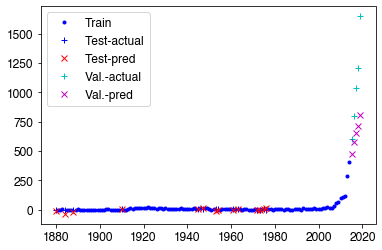

Atticus: train 0.999, test 0.828, val -16.869 (101)
Aubrey: train 0.998, test 0.955, val -10.103 (102)
August: train 0.997, test 0.872, val -7.125 (103)
Augustine: train 0.996, test 0.841, val -14.003 (104)
Augustus: train 0.995, test 0.678, val -33.176 (105)
Aurelio: train 0.987, test 0.900, val -1.109 (106)
Austen: train 0.999, test 0.995, val -2.160 (107)
Austin: train 1.000, test 0.987, val 0.400 (108)
Avery: train 1.000, test 0.921, val -60.685 (109)
Axel: train 0.999, test -1.591, val 0.754 (110)
Ayaan: train 1.000, test 0.392, val -8.564 (111)
Aydan: train 1.000, test 0.989, val -1.896 (112)
Ayden: train 1.000, test 0.968, val -8.303 (113)
Aydin: train 1.000, test 0.857, val -4.075 (114)
Baby: train 0.998, test 0.990, val -23.544 (115)
Bailey: train 0.998, test 0.979, val -648.752 (116)
Barney: train 0.995, test 0.895, val -462.538 (117)
Baron: train 0.992, test 0.895, val -4.699 (118)
Barrett: train 0.999, test 0.922, val -0.479 (119)
Barry: train 0.999, test 0.987, val -1062.2

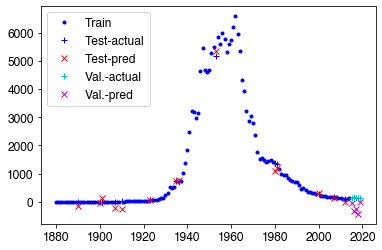

Bart: train 0.995, test 0.966, val -695.934 (121)
Barton: train 0.996, test 0.977, val -117.776 (122)
Basil: train 0.992, test 0.883, val -48.260 (123)
Beau: train 0.998, test 0.959, val -3.624 (124)
Beckett: train 1.000, test 0.991, val -33.424 (125)
Beckham: train 0.999, test -2.539, val -6.962 (126)
Ben: train 0.995, test 0.872, val -266.194 (127)
Benedict: train 0.982, test 0.785, val -22.635 (128)
Benito: train 0.995, test 0.950, val -74.311 (129)
Benjamin: train 1.000, test 0.997, val -6.056 (130)
Bennett: train 1.000, test 0.982, val 0.554 (131)
Bennie: train 0.998, test 0.983, val -394.842 (132)
Benny: train 0.999, test 0.991, val -4.549 (133)
Benson: train 0.999, test 0.667, val -6.915 (134)
Bentley: train 0.999, test -71.801, val -5.082 (135)
Benton: train 0.996, test 0.947, val -0.553 (136)
Bernard: train 0.999, test 0.965, val -380.949 (137)
Bernardo: train 0.997, test 0.965, val -43.496 (138)
Bernie: train 0.995, test 0.936, val -43.209 (139)
Bert: train 0.995, test 0.934,

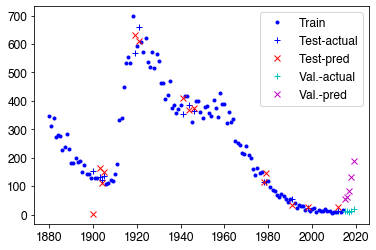

Bertram: train 0.995, test 0.969, val -4.624 (141)
Bill: train 0.999, test 0.988, val -4130.717 (142)
Billie: train 0.998, test 0.985, val -4667.088 (143)
Billy: train 0.999, test 0.990, val -14392.413 (144)
Blaine: train 0.998, test 0.978, val -1.758 (145)
Blair: train 0.995, test 0.967, val -10.538 (146)
Blaise: train 0.999, test 0.946, val -2.996 (147)
Blake: train 1.000, test 0.997, val -0.134 (148)
Blaze: train 1.000, test 0.979, val 0.248 (149)
Bo: train 0.999, test 0.960, val -129.237 (150)
Bob: train 0.999, test 0.989, val -15425.309 (151)
Bobbie: train 0.998, test 0.973, val -257.952 (152)
Bobby: train 1.000, test 0.995, val -507.748 (153)
Bodhi: train 0.998, test 0.799, val -0.838 (154)
Booker: train 0.993, test 0.610, val -9.645 (155)
Boston: train 0.999, test 0.959, val -187.670 (156)
Bowen: train 0.998, test 0.981, val 0.713 (157)
Boyd: train 0.997, test 0.969, val -28.337 (158)
Brad: train 0.999, test 0.980, val -101.896 (159)
Braden: train 1.000, test 0.996, val -3.590 (

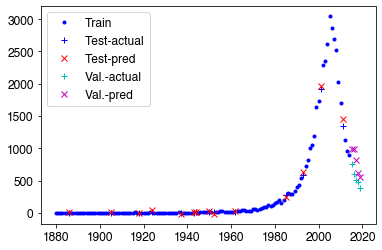

Bradford: train 0.999, test 0.969, val -63.529 (161)
Bradley: train 1.000, test 0.998, val -4.478 (162)
Bradly: train 0.999, test 0.960, val -37.110 (163)
Brady: train 0.999, test 0.986, val 0.712 (164)
Braeden: train 1.000, test 0.976, val 0.617 (165)
Braiden: train 1.000, test 0.988, val 0.511 (166)
Brandan: train 0.999, test 0.929, val -15.088 (167)
Branden: train 1.000, test 0.991, val 0.506 (168)
Brandon: train 1.000, test 0.999, val -8.255 (169)
Brandt: train 0.997, test 0.947, val -5.627 (170)
Branson: train 0.999, test 0.089, val -21.701 (171)
Brant: train 0.998, test 0.950, val -1.747 (172)
Brantley: train 0.998, test -22.003, val -18.030 (173)
Braxton: train 1.000, test 0.996, val -46.468 (174)
Brayan: train 1.000, test 0.985, val -1.806 (175)
Brayden: train 1.000, test 0.994, val 0.903 (176)
Braydon: train 1.000, test 0.991, val 0.802 (177)
Braylen: train 0.999, test 0.936, val -1.365 (178)
Braylon: train 0.998, test 0.948, val -0.355 (179)
Brendan: train 0.999, test 0.981, 

Brenden: train 1.000, test 0.969, val -30.900 (181)
Brendon: train 0.999, test 0.968, val -17.674 (182)
Brennan: train 1.000, test 0.994, val 0.404 (183)
Brennen: train 0.999, test 0.975, val -33.737 (184)
Brent: train 1.000, test 0.986, val -386.145 (185)
Brenton: train 0.988, test 0.472, val -802.379 (186)
Bret: train 0.993, test 0.738, val -230.710 (187)
Brett: train 1.000, test 0.988, val -151.850 (188)
Brian: train 1.000, test 0.998, val -2.971 (189)
Brice: train 0.999, test 0.958, val 0.763 (190)
Britton: train 0.999, test 0.965, val -7.629 (191)
Brock: train 0.999, test 0.954, val 0.655 (192)
Broderick: train 0.997, test 0.979, val -9.653 (193)
Brodie: train 0.999, test 0.954, val -10.363 (194)
Brody: train 0.999, test 0.992, val -0.927 (195)
Bronson: train 0.998, test 0.991, val -11.624 (196)
Brooks: train 0.999, test 0.961, val 0.656 (197)
Bruce: train 1.000, test 0.995, val -30.286 (198)
Bruno: train 0.996, test 0.829, val -5.585 (199)
Bryan: train 1.000, test 0.997, val 0.77

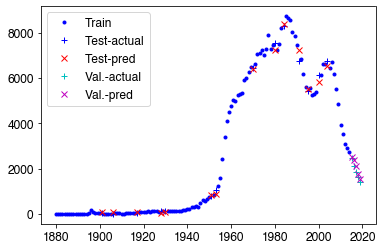

Bryant: train 0.999, test 0.951, val 0.452 (201)
Bryce: train 1.000, test 0.994, val 0.848 (202)
Brycen: train 1.000, test 0.993, val -52.050 (203)
Bryon: train 0.999, test 0.962, val -17.150 (204)
Bryson: train 1.000, test 0.979, val -0.249 (205)
Bud: train 0.994, test 0.938, val -3.391 (206)
Buddy: train 0.998, test 0.977, val -34.021 (207)
Buford: train 0.997, test 0.950, val -184.489 (208)
Burl: train 0.997, test 0.899, val -152.486 (209)
Burt: train 0.991, test 0.884, val -406.912 (210)
Burton: train 0.998, test 0.986, val -41.256 (211)
Buster: train 0.995, test 0.963, val -36.879 (212)
Byron: train 0.998, test 0.987, val -17.911 (213)
Cade: train 0.999, test 0.989, val -1.956 (214)
Caden: train 1.000, test 0.999, val 0.557 (215)
Caiden: train 1.000, test 0.998, val -9.561 (216)
Cain: train 0.999, test 0.985, val -19.985 (217)
Cale: train 0.999, test 0.968, val 0.530 (218)
Caleb: train 1.000, test 0.995, val 0.318 (219)
Callen: train 0.999, test 0.180, val -120.500 (220)


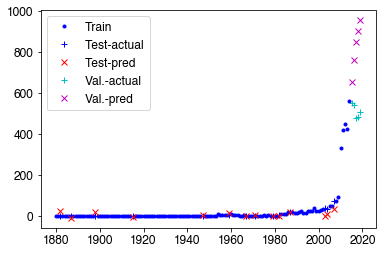

Callum: train 1.000, test 0.994, val 0.039 (221)
Calvin: train 0.995, test 0.919, val -16.916 (222)
Camden: train 1.000, test 0.987, val -9.228 (223)
Cameron: train 1.000, test 0.994, val -0.339 (224)
Camilo: train 0.997, test 0.935, val -1.412 (225)
Camren: train 1.000, test 0.996, val -3.171 (226)
Camron: train 0.999, test 0.912, val -1.366 (227)
Cannon: train 1.000, test 0.228, val -11.898 (228)
Carey: train 0.997, test 0.979, val -34.001 (229)
Carl: train 0.999, test 0.976, val -47.443 (230)
Carlo: train 0.996, test 0.921, val -4.508 (231)
Carlos: train 1.000, test 0.996, val -0.053 (232)
Carlton: train 0.998, test 0.983, val -56.354 (233)
Carmelo: train 0.998, test 0.839, val -541.737 (234)
Carmen: train 0.997, test 0.992, val -107.102 (235)
Carmine: train 0.996, test 0.908, val -202.324 (236)
Carol: train 0.997, test 0.854, val 0.000 (237)
Carrol: train 0.996, test 0.969, val 0.000 (238)
Carroll: train 0.999, test 0.968, val -470.393 (239)
Carson: train 1.000, test 0.897, val -10

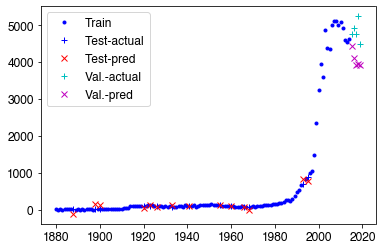

Carter: train 1.000, test 0.967, val -32.740 (241)
Cary: train 0.995, test 0.960, val -244.427 (242)
Case: train 1.000, test 0.926, val -93.802 (243)
Casey: train 1.000, test 0.995, val -10.740 (244)
Cash: train 0.999, test 0.979, val -12.378 (245)
Cason: train 1.000, test 0.971, val -9.888 (246)
Cassius: train 0.998, test 0.933, val 0.839 (247)
Cayden: train 1.000, test 0.814, val 0.844 (248)
Cecil: train 0.999, test 0.713, val -601.327 (249)
Cedric: train 0.999, test 0.995, val -64.500 (250)
Cedrick: train 0.998, test 0.944, val -10.108 (251)
Cesar: train 1.000, test 0.995, val -0.268 (252)
Chad: train 1.000, test 0.998, val -3.960 (253)
Chadwick: train 0.999, test 0.975, val -17.657 (254)
Chaim: train 0.999, test 0.991, val -11.283 (255)
Chance: train 0.998, test 0.988, val -1.917 (256)
Chandler: train 0.999, test 0.982, val 0.246 (257)
Channing: train 0.998, test 0.891, val -0.960 (258)
Charles: train 0.999, test 0.992, val -15.103 (259)
Charley: train 0.995, test 0.914, val -70.84

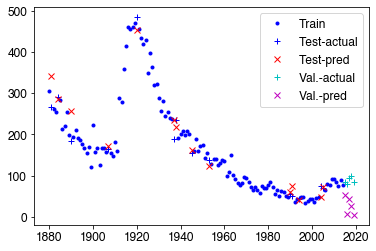

Charlie: train 0.998, test 0.979, val -11.064 (261)
Chase: train 1.000, test 0.994, val 0.696 (262)
Chauncey: train 0.992, test 0.924, val -120.432 (263)
Chaz: train 0.999, test 0.943, val -1.243 (264)
Chester: train 0.998, test 0.968, val -7110.763 (265)
Chet: train 0.997, test 0.890, val -50.172 (266)
Chris: train 1.000, test 0.995, val -6.494 (267)
Christian: train 1.000, test 0.995, val 0.920 (268)
Christopher: train 1.000, test 0.997, val 0.106 (269)
Chuck: train 0.999, test 0.987, val -3125.308 (270)
Clair: train 0.996, test 0.983, val -458.646 (271)
Clarence: train 0.999, test 0.988, val -396.252 (272)
Clark: train 0.997, test 0.884, val -190.194 (273)
Claud: train 0.997, test 0.923, val 0.000 (274)
Claude: train 0.998, test 0.982, val -1481.508 (275)
Clay: train 0.999, test 0.978, val -100.757 (276)
Clayton: train 0.999, test 0.991, val -37.062 (277)
Clement: train 0.997, test 0.945, val -144.099 (278)
Cleo: train 0.995, test 0.927, val -12.337 (279)
Cletus: train 0.995, test 0

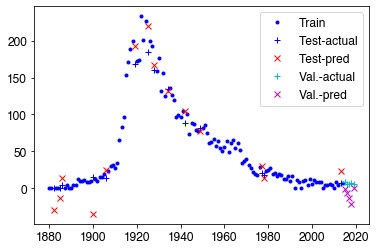

Cleveland: train 0.997, test 0.956, val -210.985 (281)
Cliff: train 0.995, test 0.935, val -59.989 (282)
Clifford: train 0.998, test 0.986, val -347.815 (283)
Clifton: train 0.997, test 0.927, val -579.579 (284)
Clint: train 0.999, test 0.967, val -186.986 (285)
Clinton: train 0.999, test 0.983, val -39.983 (286)
Clyde: train 0.999, test 0.950, val -37.892 (287)
Coby: train 0.999, test 0.988, val -94.471 (288)
Cody: train 1.000, test 0.988, val -41.149 (289)
Cohen: train 0.999, test -2.223, val -69.162 (290)
Colby: train 0.996, test 0.839, val -115.357 (291)
Cole: train 1.000, test 0.997, val -6.951 (292)
Coleman: train 0.998, test 0.978, val -4.310 (293)
Colin: train 0.999, test 0.995, val -0.177 (294)
Collin: train 1.000, test 0.969, val 0.085 (295)
Colt: train 0.998, test 0.900, val -3.328 (296)
Colten: train 1.000, test 0.989, val -0.612 (297)
Colton: train 1.000, test 0.991, val -0.684 (298)
Columbus: train 0.997, test 0.977, val -47.364 (299)
Conner: train 1.000, test 0.993, val 

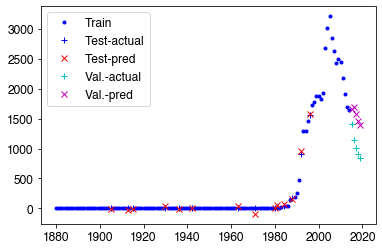

Connie: train 0.995, test 0.925, val 0.000 (301)
Connor: train 1.000, test 0.989, val 0.723 (302)
Conor: train 0.998, test 0.967, val -5.017 (303)
Conrad: train 0.996, test 0.956, val -18.136 (304)
Cooper: train 1.000, test 0.937, val -0.145 (305)
Corbin: train 0.999, test -1.384, val -20.985 (306)
Cordell: train 0.996, test 0.493, val -1.645 (307)
Corey: train 1.000, test 0.993, val -137.457 (308)
Cornelius: train 0.996, test 0.933, val -1.227 (309)
Cornell: train 0.994, test 0.971, val -124.687 (310)
Cortez: train 0.999, test 0.993, val -9.340 (311)
Cory: train 1.000, test 0.983, val -30.683 (312)
Coty: train 0.999, test 0.945, val -806.850 (313)
Courtney: train 0.999, test 0.830, val -23.443 (314)
Coy: train 0.992, test 0.851, val -209.680 (315)
Craig: train 1.000, test 0.997, val -708.523 (316)
Cristian: train 1.000, test 0.991, val -49.007 (317)
Cristobal: train 0.997, test 0.780, val -7.912 (318)
Cristopher: train 0.999, test 0.992, val -7.369 (319)
Cruz: train 1.000, test 0.994,

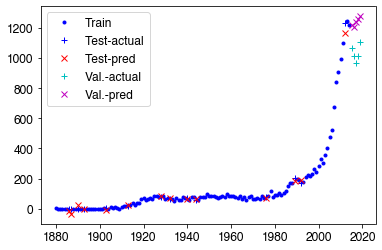

Cullen: train 0.999, test 0.874, val -16.242 (321)
Curt: train 0.999, test 0.988, val -233.188 (322)
Curtis: train 1.000, test 0.990, val -22.904 (323)
Cyril: train 0.995, test 0.983, val -1.638 (324)
Cyrus: train 0.999, test 0.978, val -9.444 (325)
Dakota: train 1.000, test 0.988, val -327.207 (326)
Dale: train 1.000, test 0.990, val -276.864 (327)
Dallas: train 0.999, test 0.990, val -32.821 (328)
Dalton: train 1.000, test 0.957, val -9.810 (329)
Damian: train 1.000, test 0.993, val -21.254 (330)
Damien: train 1.000, test 0.983, val -2.676 (331)
Damion: train 1.000, test 0.979, val -289.325 (332)
Damon: train 0.999, test 0.995, val -53.782 (333)
Dan: train 0.999, test 0.990, val -973.922 (334)
Dana: train 0.999, test 0.988, val -608.150 (335)
Dandre: train 0.999, test 0.990, val -56.132 (336)
Dane: train 0.996, test 0.951, val -0.106 (337)
Dangelo: train 0.992, test 0.884, val -36.478 (338)
Danial: train 0.998, test 0.964, val 0.545 (339)
Daniel: train 1.000, test 0.999, val -0.053 (

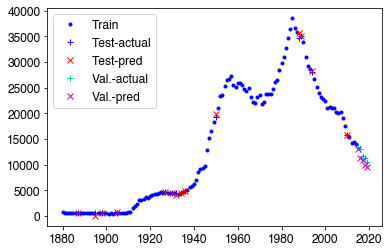

Dannie: train 0.997, test 0.970, val -9.360 (341)
Danny: train 1.000, test 0.990, val -30.184 (342)
Dante: train 0.999, test 0.984, val -80.342 (343)
Daquan: train 0.999, test -1.010, val -51.243 (344)
Daren: train 0.998, test 0.719, val -43.981 (345)
Darian: train 1.000, test 0.975, val -8.460 (346)
Darien: train 0.999, test 0.988, val -62.247 (347)
Darin: train 0.998, test 0.983, val -4.796 (348)
Dario: train 0.999, test 0.970, val -13.953 (349)
Darion: train 0.999, test 0.986, val -56.964 (350)
Darius: train 0.999, test 0.993, val -30.981 (351)
Darnell: train 0.999, test 0.986, val -40.558 (352)
Daron: train 0.999, test 0.948, val -2.628 (353)
Darrel: train 0.999, test 0.975, val -289.836 (354)
Darrell: train 0.999, test 0.997, val -5.279 (355)
Darren: train 0.998, test 0.988, val -1.751 (356)
Darrick: train 0.999, test 0.989, val -44.549 (357)
Darrin: train 0.996, test 0.921, val -445.505 (358)
Darrius: train 0.998, test 0.969, val -98.074 (359)
Darron: train 0.997, test 0.914, val

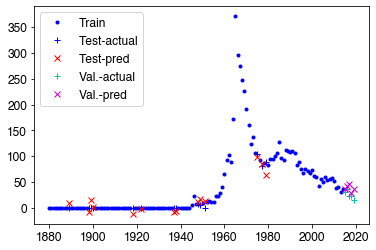

Darryl: train 0.998, test 0.911, val -51.994 (361)
Darwin: train 0.997, test 0.954, val -42.254 (362)
Daryl: train 0.999, test 0.983, val -13.963 (363)
Dashawn: train 0.999, test 0.990, val -42.469 (364)
Dave: train 0.999, test 0.990, val -504.301 (365)
Davian: train 0.999, test 0.070, val -95.618 (366)
David: train 1.000, test 0.997, val 0.277 (367)
Davin: train 1.000, test 0.997, val 0.939 (368)
Davion: train 1.000, test 0.944, val -0.264 (369)
Davis: train 0.999, test 0.987, val -0.349 (370)
Davon: train 0.999, test 0.991, val -4.529 (371)
Dawson: train 0.998, test 0.867, val -11.860 (372)
Dax: train 0.999, test 0.918, val 0.581 (373)
Daxton: train 0.999, test 0.987, val -0.434 (374)
Dayton: train 0.999, test 0.983, val -1.826 (375)
Deacon: train 0.999, test -0.705, val -72.700 (376)
Dean: train 0.999, test 0.994, val -16.817 (377)
Deandre: train 0.999, test 0.986, val -2.775 (378)
Deangelo: train 0.998, test 0.980, val -33.522 (379)
Declan: train 0.999, test -238.608, val -32.092 (

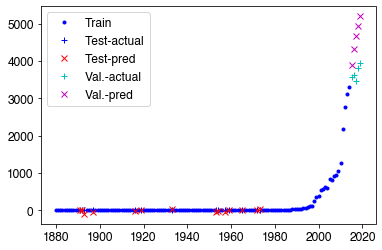

Dee: train 0.986, test 0.808, val -672.804 (381)
Deion: train 0.996, test 0.908, val -1.704 (382)
Dejuan: train 0.999, test 0.940, val -207.142 (383)
Delbert: train 0.999, test 0.987, val -1180.356 (384)
Delmar: train 0.998, test 0.936, val -16.402 (385)
Delmer: train 0.997, test 0.948, val -517.689 (386)
Demarco: train 0.999, test 0.986, val -4.489 (387)
Demarcus: train 1.000, test 0.994, val -1.166 (388)
Demario: train 1.000, test 0.915, val -0.199 (389)
Demetrius: train 0.999, test 0.982, val -28.191 (390)
Demond: train 0.994, test 0.934, val -30.891 (391)
Denis: train 0.996, test 0.965, val -1.169 (392)
Dennis: train 0.999, test 0.988, val -282.866 (393)
Denny: train 0.996, test 0.973, val -1.413 (394)
Denver: train 0.992, test 0.758, val -4.691 (395)
Denzel: train 0.997, test 0.974, val -898.128 (396)
Deon: train 0.999, test 0.982, val -12.491 (397)
Deonte: train 0.999, test 0.999, val -29.811 (398)
Dereck: train 0.999, test 0.983, val -21.313 (399)
Derek: train 0.999, test 0.974,

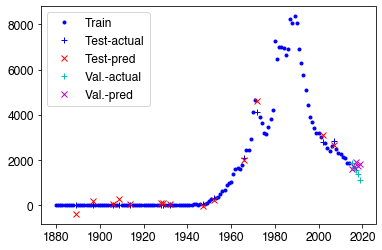

Derick: train 1.000, test 0.981, val -14.748 (401)
Derik: train 0.998, test 0.954, val -132.466 (402)
Deron: train 0.997, test 0.832, val -22.938 (403)
Derrick: train 1.000, test 0.997, val -31.358 (404)
Deshaun: train 0.999, test 0.994, val -51.460 (405)
Deshawn: train 1.000, test 0.984, val 0.129 (406)
Desmond: train 0.998, test 0.987, val -3.499 (407)
Destin: train 0.999, test 0.902, val -57.436 (408)
Devan: train 1.000, test 0.994, val -8.991 (409)
Devante: train 0.976, test -0.020, val -211.105 (410)
Deven: train 1.000, test 0.980, val -3.365 (411)
Devin: train 1.000, test 0.995, val -37.010 (412)
Devon: train 1.000, test 0.998, val -60.528 (413)
Devonte: train 0.990, test 0.959, val -199.843 (414)
Devyn: train 0.999, test 0.997, val -1.301 (415)
Dewayne: train 0.998, test 0.986, val -4.059 (416)
Dewey: train 0.993, test 0.816, val -199.678 (417)
Dexter: train 0.996, test 0.885, val -44.023 (418)
Dick: train 0.999, test 0.922, val 0.000 (419)
Diego: train 1.000, test 0.992, val -4

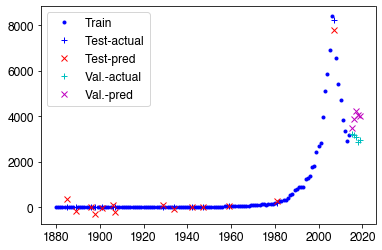

Dillan: train 0.999, test 0.970, val -1.574 (421)
Dillon: train 0.999, test 0.986, val -2.394 (422)
Dimitri: train 0.997, test 0.932, val -73.404 (423)
Dino: train 0.997, test 0.810, val -50.984 (424)
Dion: train 0.997, test 0.980, val -257.971 (425)
Dirk: train 0.996, test 0.881, val -15.956 (426)
Domenic: train 0.995, test 0.930, val -15.282 (427)
Domingo: train 0.994, test 0.878, val 0.299 (428)
Dominic: train 1.000, test 0.996, val -5.750 (429)
Dominick: train 0.999, test 0.995, val 0.973 (430)
Dominik: train 1.000, test 0.991, val -4.020 (431)
Dominique: train 0.999, test 0.992, val -10.722 (432)
Don: train 1.000, test 0.996, val -494.817 (433)
Donald: train 1.000, test 0.993, val -42.284 (434)
Donavan: train 0.999, test 0.989, val -3.014 (435)
Donn: train 0.987, test 0.747, val -154.021 (436)
Donnell: train 0.997, test 0.993, val -19.033 (437)
Donnie: train 1.000, test 0.993, val -25.582 (438)
Donny: train 0.997, test 0.934, val -80.046 (439)
Donovan: train 1.000, test 0.976, val

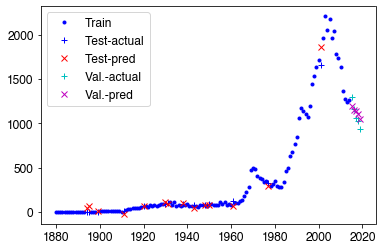

Dontae: train 0.998, test 0.963, val -25.728 (441)
Donte: train 0.999, test 0.980, val -1.223 (442)
Dorian: train 0.999, test 0.985, val -3.535 (443)
Doug: train 0.998, test 0.996, val -1250.275 (444)
Douglas: train 0.997, test 0.984, val -3071.146 (445)
Doyle: train 0.998, test 0.957, val -2967.954 (446)
Drake: train 1.000, test 0.990, val -29.806 (447)
Draven: train 0.999, test 0.990, val 0.386 (448)
Drew: train 0.999, test 0.976, val -17.389 (449)
Duane: train 0.999, test 0.997, val -17.412 (450)
Dudley: train 0.995, test 0.949, val -401.801 (451)
Duke: train 0.995, test 0.777, val -4.075 (452)
Duncan: train 0.998, test 0.958, val -3.211 (453)
Dustin: train 1.000, test 0.992, val -70.283 (454)
Dusty: train 0.997, test 0.983, val -303.654 (455)
Dwain: train 0.996, test 0.972, val -277.657 (456)
Dwayne: train 0.999, test 0.940, val -65.145 (457)
Dwight: train 0.998, test 0.882, val -312.727 (458)
Dylan: train 1.000, test 0.988, val 0.883 (459)
Ean: train 0.999, test 0.987, val -16.415

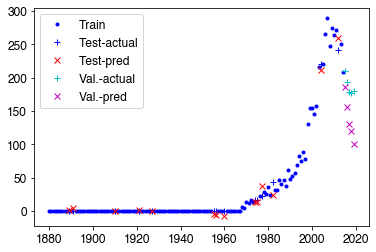

Earl: train 0.999, test 0.993, val -762.172 (461)
Earle: train 0.995, test 0.877, val 0.000 (462)
Earnest: train 0.998, test 0.994, val -106.917 (463)
Easton: train 1.000, test 0.998, val -25.157 (464)
Ed: train 0.998, test 0.965, val -1127.428 (465)
Eddie: train 0.999, test 0.995, val -138.853 (466)
Eddy: train 0.997, test 0.957, val -2.753 (467)
Eden: train 0.999, test 0.987, val -30.036 (468)
Edgar: train 0.998, test 0.965, val 0.077 (469)
Edgardo: train 0.998, test 0.916, val -25.436 (470)
Edison: train 0.997, test 0.976, val -3.889 (471)
Edmond: train 0.995, test 0.932, val -12.201 (472)
Edmund: train 0.998, test 0.967, val -28.946 (473)
Eduardo: train 0.999, test 0.990, val -0.704 (474)
Edward: train 0.999, test 0.967, val -9.820 (475)
Edwardo: train 0.996, test 0.939, val -101.554 (476)
Edwin: train 0.998, test 0.979, val -7.330 (477)
Efrain: train 0.999, test 0.988, val -16.875 (478)
Efren: train 0.998, test 0.957, val -27.565 (479)
Elbert: train 0.997, test 0.974, val -162.753

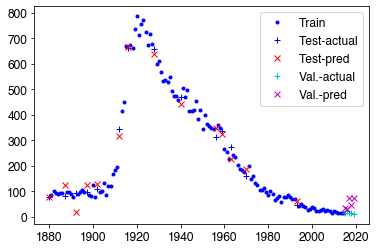

Eldon: train 0.998, test 0.965, val -68.846 (481)
Eli: train 1.000, test 0.996, val -1.650 (482)
Elian: train 0.983, test 0.896, val 0.389 (483)
Elias: train 1.000, test 0.970, val 0.443 (484)
Eliezer: train 0.998, test 0.741, val -332.056 (485)
Elijah: train 1.000, test 0.999, val -0.651 (486)
Eliot: train 0.995, test 0.850, val 0.311 (487)
Eliseo: train 0.998, test 0.961, val -6.568 (488)
Elisha: train 0.999, test 0.982, val -1.275 (489)
Elliot: train 0.999, test 0.927, val -2.543 (490)
Elliott: train 0.999, test 0.993, val -0.141 (491)
Ellis: train 0.996, test 0.949, val 0.186 (492)
Ellsworth: train 0.996, test 0.880, val -419.568 (493)
Elmer: train 0.998, test 0.967, val -292.375 (494)
Elmo: train 0.997, test 0.945, val 0.000 (495)
Eloy: train 0.995, test 0.939, val -58.323 (496)
Elroy: train 0.996, test 0.944, val -421.500 (497)
Elton: train 0.996, test 0.938, val -87.023 (498)
Elvin: train 0.995, test 0.968, val -62.656 (499)
Elvis: train 0.985, test 0.744, val -172.308 (500)


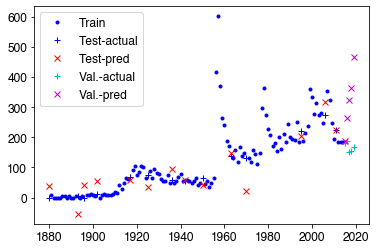

Elwood: train 0.998, test 0.977, val -68.723 (501)
Emanuel: train 0.999, test 0.975, val -8.216 (502)
Emerson: train 0.999, test 0.885, val -0.995 (503)
Emery: train 0.995, test 0.928, val -121.232 (504)
Emil: train 0.997, test 0.988, val -17.687 (505)
Emiliano: train 1.000, test 0.980, val 0.844 (506)
Emilio: train 0.999, test 0.988, val -2.500 (507)
Emmanuel: train 1.000, test 0.996, val -16.058 (508)
Emmett: train 0.999, test 0.997, val -2.239 (509)
Emmitt: train 0.997, test 0.983, val -0.615 (510)
Emory: train 0.993, test 0.895, val -8.832 (511)
Enoch: train 0.993, test 0.877, val -22.336 (512)
Enrique: train 1.000, test 0.993, val -5.342 (513)
Enzo: train 1.000, test 0.963, val -0.501 (514)
Ephraim: train 0.998, test 0.966, val -13.203 (515)
Eric: train 1.000, test 0.998, val -7.793 (516)
Erich: train 0.998, test 0.946, val -128.097 (517)
Erick: train 1.000, test 0.998, val -3.960 (518)
Erik: train 0.999, test 0.990, val -108.791 (519)
Erin: train 0.999, test 0.974, val -17.443 (5

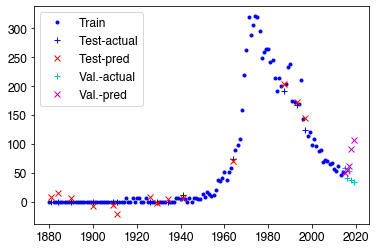

Ernest: train 0.999, test 0.991, val -95.076 (521)
Ernesto: train 0.999, test 0.990, val -7.853 (522)
Ernie: train 0.998, test 0.939, val -137.264 (523)
Errol: train 0.993, test 0.821, val -31.490 (524)
Ervin: train 0.998, test 0.953, val -90.251 (525)
Erwin: train 0.996, test 0.974, val -103.803 (526)
Esteban: train 0.999, test 0.641, val -71.672 (527)
Estevan: train 0.999, test 0.977, val -1.647 (528)
Ethan: train 1.000, test 0.999, val -3.512 (529)
Eugene: train 0.999, test 0.986, val -1986.099 (530)
Evan: train 1.000, test 0.992, val 0.941 (531)
Everett: train 0.998, test 0.967, val -0.259 (532)
Everette: train 0.993, test 0.806, val -1.189 (533)
Ezekiel: train 1.000, test 0.773, val -1.735 (534)
Ezequiel: train 1.000, test 0.993, val -2.271 (535)
Ezra: train 1.000, test 0.991, val 0.641 (536)
Fabian: train 1.000, test 0.992, val -94.283 (537)
Federico: train 0.995, test 0.714, val -1.946 (538)
Felipe: train 0.999, test 0.956, val -86.026 (539)
Felix: train 0.998, test 0.974, val -

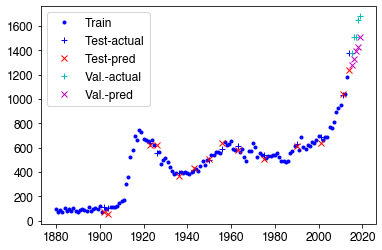

Ferdinand: train 0.993, test 0.712, val -14.927 (541)
Fernando: train 0.999, test 0.997, val -1.427 (542)
Fidel: train 0.996, test 0.852, val -27.893 (543)
Finley: train 0.999, test 0.916, val -32.096 (544)
Finn: train 1.000, test 0.995, val -5.752 (545)
Finnegan: train 0.999, test 0.996, val -6.548 (546)
Fletcher: train 0.995, test 0.855, val -1.454 (547)
Floyd: train 0.999, test 0.971, val -434.333 (548)
Forest: train 0.994, test 0.932, val 0.155 (549)
Forrest: train 0.997, test 0.896, val 0.188 (550)
Foster: train 0.995, test 0.933, val -37.676 (551)
Francesco: train 0.998, test 0.982, val -188.764 (552)
Francis: train 0.999, test 0.978, val -232.250 (553)
Francisco: train 1.000, test 0.997, val -11.908 (554)
Franco: train 0.998, test 0.986, val -2.354 (555)
Frank: train 0.999, test 0.991, val -53.583 (556)
Frankie: train 0.999, test 0.987, val -47.522 (557)
Franklin: train 0.983, test 0.835, val -410.503 (558)
Fred: train 0.999, test 0.990, val -3277.018 (559)
Freddie: train 1.000,

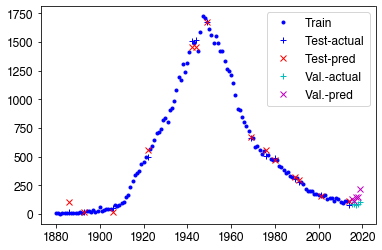

Freddy: train 0.999, test 0.988, val 0.341 (561)
Frederic: train 0.996, test 0.859, val -67.967 (562)
Frederick: train 0.999, test 0.992, val -727.510 (563)
Fredric: train 0.993, test 0.940, val -347.426 (564)
Fredrick: train 0.999, test 0.964, val -55.460 (565)
Freeman: train 0.995, test 0.985, val -2.817 (566)
Gabriel: train 1.000, test 0.999, val 0.834 (567)
Gael: train 0.994, test 0.129, val -47.925 (568)
Gage: train 1.000, test 0.995, val -1.500 (569)
Gail: train 0.994, test 0.915, val 0.000 (570)
Gale: train 0.996, test 0.976, val -548.142 (571)
Galen: train 0.995, test 0.963, val -137.653 (572)
Gannon: train 0.990, test 0.498, val -120.085 (573)
Garland: train 0.997, test 0.975, val -1211.685 (574)
Garret: train 0.999, test 0.853, val -7.864 (575)
Garrett: train 1.000, test 0.998, val -13.639 (576)
Garrick: train 0.990, test 0.542, val -545.494 (577)
Garrison: train 0.998, test 0.972, val -10.510 (578)
Garry: train 0.999, test 0.996, val -4537.668 (579)
Garth: train 0.988, test 

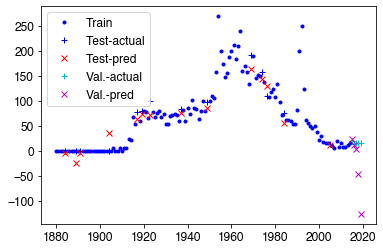

Gary: train 0.999, test 0.997, val -180.817 (581)
Gavin: train 1.000, test 0.997, val 0.877 (582)
Genaro: train 0.995, test 0.925, val -42.840 (583)
Gene: train 0.998, test 0.985, val -684.612 (584)
Geoffrey: train 1.000, test 0.966, val -13.790 (585)
George: train 0.999, test 0.980, val -257.198 (586)
Gerald: train 0.999, test 0.991, val -1015.502 (587)
Gerard: train 0.999, test 0.993, val -30.353 (588)
Gerardo: train 0.999, test 0.998, val -13.051 (589)
German: train 0.999, test 0.942, val -26.052 (590)
Gerry: train 0.998, test 0.938, val -73.215 (591)
Giancarlo: train 1.000, test 0.956, val 0.833 (592)
Gianni: train 0.998, test 0.975, val -0.371 (593)
Gideon: train 1.000, test 0.969, val -7.709 (594)
Gilbert: train 0.999, test 0.979, val -30.104 (595)
Gilberto: train 0.999, test 0.979, val -18.382 (596)
Gino: train 0.997, test 0.981, val -2.982 (597)
Giovani: train 1.000, test 0.959, val 0.291 (598)
Giovanni: train 1.000, test 0.997, val -21.137 (599)
Giovanny: train 0.999, test -2.

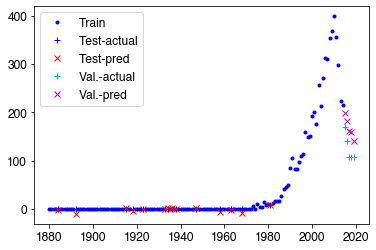

Giuseppe: train 0.999, test 0.958, val -19.180 (601)
Glen: train 0.999, test 0.986, val -22.586 (602)
Glenn: train 0.999, test 0.988, val -219.386 (603)
Gonzalo: train 0.997, test 0.973, val -2.361 (604)
Gordon: train 0.999, test 0.993, val -16.947 (605)
Grady: train 0.999, test 0.983, val -0.803 (606)
Graham: train 1.000, test 0.961, val -21.857 (607)
Grant: train 0.999, test 0.988, val -6.483 (608)
Grayson: train 1.000, test 0.966, val -66.795 (609)
Greg: train 1.000, test 0.990, val -2544.200 (610)
Gregg: train 1.000, test 0.992, val -101.647 (611)
Gregorio: train 0.995, test 0.837, val -45.163 (612)
Gregory: train 1.000, test 0.997, val -1.875 (613)
Greyson: train 1.000, test 0.996, val 0.197 (614)
Griffin: train 1.000, test 0.993, val -28.652 (615)
Grover: train 0.998, test 0.961, val -93.178 (616)
Guadalupe: train 0.996, test 0.935, val -33.253 (617)
Guillermo: train 0.999, test 0.966, val -10.142 (618)
Gunnar: train 0.999, test 0.990, val -8.875 (619)
Gunner: train 1.000, test 0

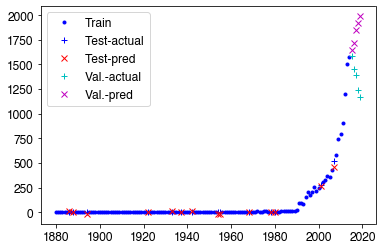

Gus: train 0.994, test 0.947, val -6.219 (621)
Gustavo: train 0.999, test 0.993, val -34.636 (622)
Guy: train 0.999, test 0.990, val -209.246 (623)
Hakeem: train 0.994, test 0.844, val -15.236 (624)
Hal: train 0.996, test 0.953, val -274.267 (625)
Hamza: train 1.000, test 0.990, val -10.799 (626)
Hank: train 0.997, test 0.978, val 0.075 (627)
Hans: train 0.998, test 0.930, val -7.518 (628)
Harlan: train 0.997, test 0.950, val -16.311 (629)
Harley: train 0.998, test 0.939, val -2.565 (630)
Harold: train 0.999, test 0.955, val -8292.932 (631)
Harper: train 0.999, test 0.993, val -1.643 (632)
Harris: train 0.995, test 0.952, val -80.598 (633)
Harrison: train 0.999, test 0.977, val -59.878 (634)
Harry: train 0.999, test 0.824, val -199.955 (635)
Harvey: train 0.999, test 0.982, val -82.524 (636)
Hassan: train 0.999, test 0.965, val -74.098 (637)
Hayden: train 1.000, test 0.962, val -18.278 (638)
Hayes: train 0.999, test 0.988, val 0.508 (639)
Heath: train 0.999, test 0.994, val -7.751 (640

Hector: train 1.000, test 0.988, val -140.823 (641)
Hendrix: train 0.997, test -8.576, val 0.780 (642)
Henry: train 0.999, test 0.966, val -8.573 (643)
Herbert: train 0.997, test 0.932, val -1774.822 (644)
Heriberto: train 0.998, test 0.986, val -10.613 (645)
Herman: train 0.999, test 0.829, val -1623.483 (646)
Herschel: train 0.995, test 0.952, val -130.229 (647)
Hershel: train 0.994, test 0.892, val -237.300 (648)
Hezekiah: train 0.998, test 0.909, val -1.385 (649)
Hiram: train 0.982, test 0.582, val -3.527 (650)
Holden: train 1.000, test 0.997, val -0.097 (651)
Hollis: train 0.996, test 0.930, val -0.200 (652)
Homer: train 0.999, test 0.967, val -2048.502 (653)
Horace: train 0.998, test 0.982, val -759.417 (654)
Houston: train 0.998, test 0.939, val -11.825 (655)
Howard: train 0.999, test 0.995, val -1105.751 (656)
Hoyt: train 0.994, test 0.932, val -38.352 (657)
Hubert: train 0.999, test 0.982, val -604.340 (658)
Hudson: train 1.000, test 0.990, val -6.275 (659)
Huey: train 0.957, 

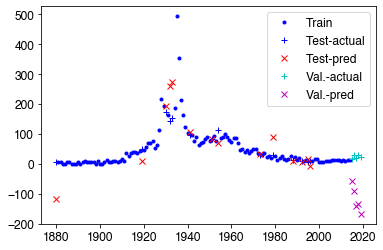

Hugh: train 0.998, test 0.956, val -689.112 (661)
Hugo: train 0.999, test 0.987, val -14.006 (662)
Humberto: train 0.998, test 0.985, val -24.252 (663)
Hunter: train 1.000, test 0.996, val 0.268 (664)
Ian: train 1.000, test 0.995, val -0.076 (665)
Ibrahim: train 1.000, test 0.993, val -0.840 (666)
Ignacio: train 0.998, test 0.980, val -30.718 (667)
Iker: train 0.998, test 0.967, val -4.833 (668)
Immanuel: train 0.999, test 0.992, val -2.044 (669)
Ira: train 0.998, test 0.949, val -7.018 (670)
Irvin: train 0.996, test 0.954, val -111.339 (671)
Irving: train 0.998, test 0.974, val -118.344 (672)
Irwin: train 0.998, test 0.920, val -29.339 (673)
Isaac: train 1.000, test 0.997, val -1.191 (674)
Isai: train 0.999, test 0.995, val -87.104 (675)
Isaiah: train 1.000, test 0.996, val 0.846 (676)
Isaias: train 1.000, test 0.986, val -6.840 (677)
Ishmael: train 0.998, test 0.598, val -78.189 (678)
Isiah: train 0.999, test 0.977, val -187.121 (679)
Isidro: train 0.997, test 0.938, val -26.498 (680

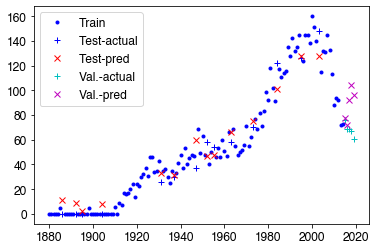

Ismael: train 1.000, test 0.992, val -0.657 (681)
Israel: train 1.000, test 0.996, val -11.241 (682)
Issac: train 1.000, test 0.982, val -4.361 (683)
Ivan: train 1.000, test 0.983, val -16.329 (684)
Ivory: train 0.989, test 0.889, val -50.298 (685)
Izaiah: train 1.000, test 0.998, val -74.828 (686)
Jabari: train 0.999, test 0.975, val -49.779 (687)
Jace: train 1.000, test 0.974, val -36.907 (688)
Jack: train 0.999, test 0.989, val -12.649 (689)
Jackie: train 0.999, test 0.983, val -82.667 (690)
Jackson: train 1.000, test 0.999, val -2.843 (691)
Jacky: train 0.996, test 0.936, val -64.178 (692)
Jacob: train 1.000, test 0.996, val 0.898 (693)
Jacoby: train 0.999, test -9.691, val -6.247 (694)
Jacques: train 0.996, test 0.953, val 0.087 (695)
Jade: train 0.998, test 0.945, val -12.932 (696)
Jaden: train 0.999, test 0.989, val -28.137 (697)
Jadon: train 1.000, test 0.987, val -2.691 (698)
Jagger: train 0.998, test 0.668, val -1.093 (699)
Jaiden: train 1.000, test 1.000, val 0.874 (700)


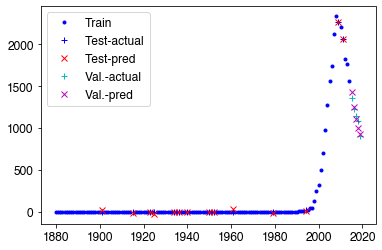

Jaime: train 1.000, test 0.991, val 0.436 (701)
Jair: train 0.998, test 0.277, val -104.282 (702)
Jairo: train 0.999, test 0.988, val -0.183 (703)
Jake: train 1.000, test 0.997, val 0.281 (704)
Jakob: train 0.999, test 0.987, val -19.164 (705)
Jalen: train 0.998, test 0.958, val -207.294 (706)
Jamaal: train 0.989, test 0.910, val -162.625 (707)
Jamal: train 1.000, test 0.998, val -5.268 (708)
Jamar: train 1.000, test 0.983, val -2.247 (709)
Jamarcus: train 0.999, test 0.988, val -3.964 (710)
Jamari: train 1.000, test 0.996, val -103.299 (711)
Jamarion: train 0.999, test 0.785, val 0.723 (712)
Jamel: train 0.999, test 0.985, val 0.148 (713)
James: train 0.999, test 0.997, val -4.630 (714)
Jameson: train 1.000, test 0.953, val 0.699 (715)
Jamey: train 0.999, test 0.976, val -329.926 (716)
Jamie: train 0.999, test 0.969, val -189.245 (717)
Jamil: train 0.999, test 0.987, val -60.626 (718)
Jamir: train 0.999, test 0.986, val -8.341 (719)
Jamison: train 0.999, test 0.881, val -20.954 (720)


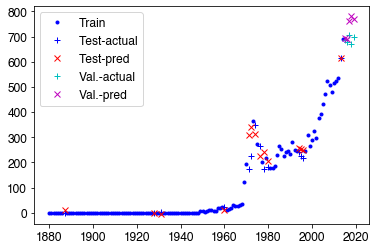

Jan: train 0.994, test 0.950, val -93.958 (721)
Jaquan: train 0.999, test 0.992, val -2.847 (722)
Jared: train 1.000, test 0.993, val -16.428 (723)
Jarod: train 0.997, test 0.023, val -31.361 (724)
Jaron: train 0.998, test 0.913, val -15.955 (725)
Jarred: train 1.000, test 0.986, val -5.366 (726)
Jarrett: train 0.999, test 0.979, val -60.238 (727)
Jarrod: train 0.999, test 0.988, val -60.646 (728)
Jarvis: train 0.999, test 0.943, val -6.410 (729)
Jase: train 0.994, test 0.236, val -16.862 (730)
Jasiah: train 1.000, test 0.984, val -20.808 (731)
Jason: train 1.000, test 0.993, val -3.474 (732)
Jasper: train 0.999, test 0.957, val 0.781 (733)
Javier: train 1.000, test 0.998, val -42.165 (734)
Javion: train 0.999, test 0.975, val -0.002 (735)
Javon: train 1.000, test 0.983, val -5.097 (736)
Jax: train 0.999, test 0.719, val -45.862 (737)
Jaxon: train 1.000, test 0.999, val -44.378 (738)
Jaxson: train 1.000, test 0.897, val -107.532 (739)
Jaxton: train 1.000, test 0.983, val -1.335 (740)


Jay: train 0.999, test 0.996, val -68.417 (741)
Jayce: train 1.000, test 0.967, val -10.845 (742)
Jayceon: train 0.993, test -28.445, val -42.055 (743)
Jayden: train 1.000, test 0.979, val 0.471 (744)
Jaydon: train 1.000, test 0.947, val -2.502 (745)
Jaylen: train 1.000, test 0.000, val -10.935 (746)
Jaylin: train 0.999, test 0.990, val -11.349 (747)
Jaylon: train 1.000, test 0.987, val -38.237 (748)
Jayson: train 1.000, test 0.989, val -3.198 (749)
Jean: train 0.995, test 0.928, val -8.186 (750)
Jed: train 0.996, test 0.885, val -67.947 (751)
Jedidiah: train 0.999, test 0.993, val -88.071 (752)
Jeff: train 0.999, test 0.988, val -2871.058 (753)
Jefferson: train 0.995, test 0.977, val -37.532 (754)
Jeffery: train 0.999, test 0.993, val -68.147 (755)
Jeffrey: train 1.000, test 0.997, val -22.484 (756)
Jeffry: train 0.999, test 0.995, val -6.523 (757)
Jensen: train 1.000, test 0.880, val 0.474 (758)
Jerald: train 0.998, test 0.988, val -6918.655 (759)
Jeremiah: train 1.000, test 0.940, v

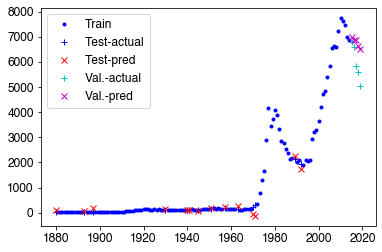

Jeremy: train 1.000, test 0.997, val -52.999 (761)
Jermaine: train 0.998, test 0.976, val -0.350 (762)
Jerod: train 0.999, test 0.959, val -572.935 (763)
Jerold: train 0.996, test 0.962, val -132.822 (764)
Jerome: train 0.999, test 0.991, val -71.491 (765)
Jerrell: train 0.997, test 0.911, val -15.779 (766)
Jerrod: train 0.999, test 0.994, val -99.490 (767)
Jerrold: train 0.996, test 0.936, val -72.676 (768)
Jerry: train 0.999, test 0.985, val -262.125 (769)
Jess: train 0.982, test 0.036, val -26.395 (770)
Jesse: train 1.000, test 0.993, val -9.067 (771)
Jessie: train 0.998, test 0.991, val -2.339 (772)
Jesus: train 1.000, test 0.994, val -4.761 (773)
Jett: train 0.999, test 0.987, val 0.177 (774)
Jim: train 0.999, test 0.988, val -14888.768 (775)
Jimmie: train 0.999, test 0.996, val -777.667 (776)
Jimmy: train 0.999, test 0.993, val -5.720 (777)
Joan: train 0.996, test 0.939, val -21.768 (778)
Joaquin: train 0.999, test 0.991, val -38.673 (779)
Jody: train 0.999, test 0.937, val -692.

Joe: train 0.999, test 0.992, val -97.143 (781)
Joel: train 1.000, test 0.996, val -4.384 (782)
Joesph: train 0.997, test 0.964, val -61.064 (783)
Joey: train 0.999, test 0.976, val -57.922 (784)
Johan: train 0.999, test 0.838, val -8.225 (785)
John: train 0.999, test 0.995, val -99.313 (786)
Johnathan: train 1.000, test 0.999, val -3.568 (787)
Johnathon: train 1.000, test 0.991, val -39.362 (788)
Johnie: train 0.998, test 0.992, val -1258.832 (789)
Johnnie: train 0.999, test 0.983, val -339.924 (790)
Johnny: train 1.000, test 0.991, val -49.151 (791)
Johnpaul: train 0.994, test 0.940, val -389.972 (792)
Jon: train 1.000, test 0.992, val -61.380 (793)
Jonah: train 0.999, test 0.996, val 0.540 (794)
Jonas: train 0.998, test 0.931, val -3.425 (795)
Jonathan: train 1.000, test 0.997, val 0.376 (796)
Jonathon: train 1.000, test 0.996, val -29.688 (797)
Jordan: train 0.999, test 0.995, val -43.344 (798)
Jorden: train 0.999, test 0.991, val -0.666 (799)
Jordon: train 0.999, test 0.985, val -

Jordy: train 0.995, test 0.821, val -43.285 (801)
Jordyn: train 0.999, test 0.394, val 0.643 (802)
Jorge: train 1.000, test 0.992, val -5.425 (803)
Jose: train 1.000, test 0.997, val -6.032 (804)
Josef: train 0.999, test 0.967, val -55.601 (805)
Joseph: train 0.999, test 0.993, val -5.094 (806)
Josh: train 0.998, test 0.963, val -48.596 (807)
Joshua: train 1.000, test 0.997, val 0.093 (808)
Josiah: train 1.000, test 0.999, val -3.871 (809)
Josue: train 1.000, test 0.999, val -18.340 (810)
Jovan: train 1.000, test 0.980, val -1.501 (811)
Jovani: train 0.999, test 0.993, val -13.533 (812)
Jovanni: train 0.999, test 0.943, val -1.546 (813)
Juan: train 1.000, test 0.995, val -13.118 (814)
Judah: train 1.000, test 0.993, val 0.899 (815)
Jude: train 1.000, test 0.963, val -32.318 (816)
Judson: train 0.988, test 0.786, val -2.313 (817)
Julian: train 1.000, test 0.997, val -4.984 (818)
Julien: train 1.000, test 0.989, val -44.540 (819)
Julio: train 0.999, test 0.991, val -40.487 (820)


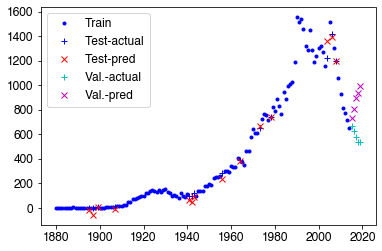

Julius: train 0.997, test 0.922, val -21.043 (821)
Junior: train 0.998, test 0.979, val -697.481 (822)
Justice: train 0.999, test 0.987, val -20.223 (823)
Justin: train 1.000, test 0.997, val -91.866 (824)
Justus: train 0.999, test 0.972, val -20.404 (825)
Kade: train 0.999, test 0.995, val -3.164 (826)
Kaden: train 1.000, test 0.281, val -1.737 (827)
Kai: train 1.000, test 0.482, val 0.900 (828)
Kaiden: train 1.000, test 0.999, val -61.742 (829)
Kale: train 0.999, test 0.970, val -0.272 (830)
Kaleb: train 1.000, test 0.988, val 0.033 (831)
Kalvin: train 0.999, test 0.979, val -30.106 (832)
Kamari: train 1.000, test 0.000, val -3.512 (833)
Kamden: train 1.000, test 0.997, val -12.350 (834)
Kameron: train 1.000, test 0.997, val -0.365 (835)
Kamron: train 1.000, test 0.979, val -0.073 (836)
Kane: train 0.999, test 0.969, val -7.508 (837)
Kareem: train 0.998, test 0.841, val 0.149 (838)
Karim: train 0.999, test 0.986, val -2.640 (839)
Karl: train 0.999, test 0.993, val -35.358 (840)


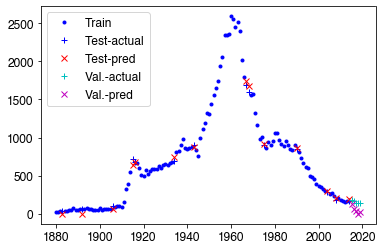

Karson: train 1.000, test 0.989, val -0.227 (841)
Karter: train 0.997, test 0.000, val -310.949 (842)
Kasen: train 1.000, test 0.999, val 0.802 (843)
Kasey: train 0.998, test 0.984, val -401.266 (844)
Kash: train 0.999, test -1.635, val 0.651 (845)
Kason: train 1.000, test 0.960, val -22.089 (846)
Kayden: train 1.000, test 0.998, val -230.934 (847)
Kayson: train 0.999, test -3.051, val -4.029 (848)
Keagan: train 1.000, test 0.966, val -2.119 (849)
Keanu: train 0.997, test 0.970, val -5.932 (850)
Keaton: train 1.000, test 0.998, val -4.001 (851)
Keegan: train 1.000, test 0.994, val -8.543 (852)
Keenan: train 0.999, test 0.946, val -116.623 (853)
Keith: train 1.000, test 0.996, val -57.912 (854)
Kellan: train 0.998, test 0.601, val -1.432 (855)
Kellen: train 0.999, test 0.947, val 0.884 (856)
Kelly: train 0.999, test 0.983, val -285.321 (857)
Kelton: train 0.999, test 0.969, val -22.215 (858)
Kelvin: train 0.999, test 0.996, val -2.897 (859)
Ken: train 0.999, test 0.995, val -41.911 (860

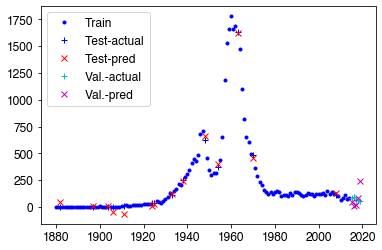

Kendall: train 0.999, test 0.978, val -5.401 (861)
Kendrick: train 0.999, test 0.993, val -18.395 (862)
Kennedy: train 0.992, test 0.923, val 0.225 (863)
Kenneth: train 1.000, test 0.986, val -4.280 (864)
Kennith: train 0.996, test 0.952, val -26.775 (865)
Kenny: train 0.999, test 0.987, val -2.403 (866)
Kent: train 0.999, test 0.983, val -408.119 (867)
Kenton: train 0.997, test 0.943, val -3.654 (868)
Kenyon: train 0.998, test 0.946, val -33.898 (869)
Keon: train 1.000, test 0.988, val -31.119 (870)
Kermit: train 0.992, test 0.955, val -2039.192 (871)
Kerry: train 0.998, test 0.991, val -652.652 (872)
Keshawn: train 0.999, test 0.884, val -205.386 (873)
Keven: train 0.998, test 0.952, val -21.666 (874)
Kevin: train 1.000, test 0.977, val -2.108 (875)
Kevon: train 0.987, test 0.644, val -425.936 (876)
Keyon: train 0.999, test 0.980, val 0.459 (877)
Khalid: train 0.998, test 0.943, val -4.233 (878)
Khalil: train 0.994, test 0.919, val -5.277 (879)
Kian: train 1.000, test 0.995, val -30.

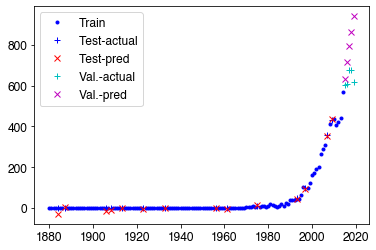

Kieran: train 1.000, test 0.990, val -10.834 (881)
Killian: train 0.998, test 0.873, val -3.075 (882)
Kim: train 0.996, test 0.583, val -15580.145 (883)
King: train 1.000, test 0.669, val -163.131 (884)
Kingston: train 0.999, test -70.480, val -3.258 (885)
Kip: train 0.998, test 0.934, val -9.217 (886)
Kirby: train 0.996, test 0.883, val -423.765 (887)
Kirk: train 0.999, test 0.992, val -139.045 (888)
Knox: train 0.999, test 0.971, val -1.124 (889)
Kobe: train 0.997, test 0.787, val -252.921 (890)
Koby: train 0.999, test 0.986, val -366.762 (891)
Kody: train 1.000, test 0.996, val -31.748 (892)
Kolby: train 0.998, test 0.989, val -1.381 (893)
Kole: train 1.000, test 0.940, val -88.368 (894)
Kolton: train 1.000, test 0.997, val -0.289 (895)
Konner: train 0.999, test 0.991, val -0.901 (896)
Konnor: train 1.000, test 0.992, val 0.225 (897)
Korbin: train 0.999, test 0.993, val -19.325 (898)
Korey: train 0.998, test 0.945, val -16.408 (899)
Kory: train 1.000, test 0.995, val -5.444 (900)


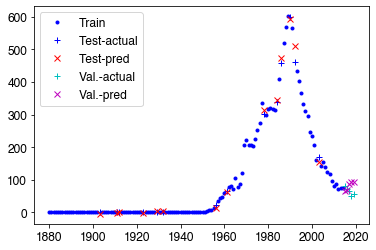

Kraig: train 0.997, test 0.981, val -0.664 (901)
Kris: train 0.999, test 0.928, val -26.657 (902)
Kristian: train 1.000, test 0.992, val -0.448 (903)
Kristofer: train 0.998, test 0.989, val -30.413 (904)
Kristopher: train 0.999, test 0.963, val 0.255 (905)
Kurt: train 1.000, test 0.988, val -372.574 (906)
Kurtis: train 0.999, test 0.995, val -1.582 (907)
Kylan: train 1.000, test 0.997, val 0.538 (908)
Kyle: train 1.000, test 0.976, val -3.246 (909)
Kyler: train 1.000, test 0.994, val -0.795 (910)
Kyree: train 0.998, test 0.953, val -26.082 (911)
Kyrie: train 0.999, test -0.423, val -3.391 (912)
Kyson: train 0.999, test 0.986, val -0.594 (913)
Lamar: train 0.999, test 0.951, val -5.553 (914)
Lamont: train 0.999, test 0.753, val -23.523 (915)
Lance: train 0.998, test 0.992, val -107.061 (916)
Landen: train 1.000, test 0.477, val -7.937 (917)
Landon: train 1.000, test 0.958, val -1.360 (918)
Landyn: train 1.000, test -1.808, val -4.971 (919)
Lane: train 0.999, test 0.985, val -0.845 (920)

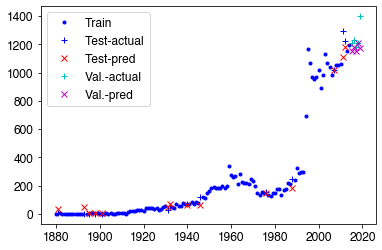

Langston: train 0.997, test 0.936, val -65.320 (921)
Lanny: train 0.991, test 0.942, val -1490.744 (922)
Larry: train 0.999, test 0.995, val -126.461 (923)
Lars: train 0.995, test 0.931, val -1.222 (924)
Laurence: train 0.998, test 0.989, val -98.353 (925)
Lavern: train 0.998, test 0.965, val -153.808 (926)
Laverne: train 0.998, test 0.961, val -40.887 (927)
Lawrence: train 1.000, test 0.974, val -135.940 (928)
Lawson: train 0.999, test 0.967, val 0.664 (929)
Layne: train 0.999, test 0.931, val -24.724 (930)
Layton: train 0.999, test 0.975, val -3.665 (931)
Lazaro: train 0.997, test 0.979, val -139.718 (932)
Leandro: train 0.999, test 0.987, val 0.420 (933)
Lee: train 0.999, test 0.990, val -156.000 (934)
Legend: train 0.998, test 0.586, val -0.893 (935)
Leif: train 0.998, test 0.898, val -11.384 (936)
Leighton: train 0.997, test 0.975, val 0.138 (937)
Leland: train 0.998, test 0.919, val -0.258 (938)
Lemuel: train 0.985, test 0.471, val -7.830 (939)
Lenard: train 0.994, test 0.927, va

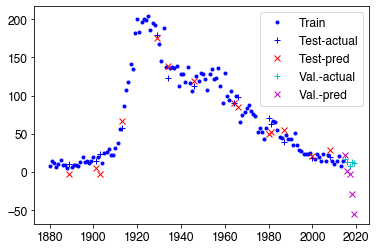

Lennon: train 0.999, test 0.895, val -9.323 (941)
Lennox: train 0.999, test 0.135, val 0.674 (942)
Lenny: train 0.997, test 0.914, val -0.568 (943)
Leo: train 0.998, test 0.992, val 0.260 (944)
Leon: train 0.999, test 0.992, val -1.244 (945)
Leonard: train 0.999, test 0.983, val -85.887 (946)
Leonardo: train 1.000, test 0.992, val -3.146 (947)
Leonel: train 1.000, test 0.993, val 0.183 (948)
Leonidas: train 0.997, test 0.935, val -131.651 (949)
Leroy: train 0.999, test 0.995, val -749.720 (950)
Leslie: train 0.999, test 0.990, val -420.705 (951)
Lester: train 0.998, test 0.978, val -122.017 (952)
Levi: train 1.000, test 0.996, val -5.507 (953)
Lewis: train 0.999, test 0.987, val -8.836 (954)
Liam: train 1.000, test -10.973, val -6.792 (955)
Lincoln: train 0.999, test 0.989, val -7.440 (956)
Lindsey: train 0.994, test 0.870, val -189.842 (957)
Linwood: train 0.997, test 0.960, val -186.258 (958)
Lionel: train 0.997, test 0.958, val -45.739 (959)
Lloyd: train 0.999, test 0.971, val -8533

Logan: train 1.000, test 0.996, val -2.471 (961)
Lon: train 0.995, test 0.896, val -274.224 (962)
London: train 0.999, test 0.982, val -6.946 (963)
Lonnie: train 0.999, test 0.987, val -121.671 (964)
Lonny: train 0.994, test 0.873, val -592.093 (965)
Loren: train 0.998, test 0.985, val -178.696 (966)
Lorenzo: train 0.999, test 0.961, val 0.590 (967)
Louie: train 0.996, test 0.950, val -19.879 (968)
Louis: train 0.999, test 0.990, val -1.370 (969)
Lowell: train 0.997, test 0.975, val -2983.932 (970)
Loyd: train 0.998, test 0.987, val -76.000 (971)
Luca: train 1.000, test -3.924, val 0.730 (972)
Lucas: train 1.000, test 0.984, val -59.416 (973)
Lucian: train 0.998, test 0.980, val -32.499 (974)
Luciano: train 0.999, test 0.938, val -2.501 (975)
Lucien: train 0.992, test 0.864, val -83.479 (976)
Luis: train 1.000, test 0.997, val -6.279 (977)
Luka: train 0.999, test 0.977, val -0.278 (978)
Lukas: train 1.000, test 0.988, val -3.303 (979)
Luke: train 1.000, test 0.981, val -24.884 (980)


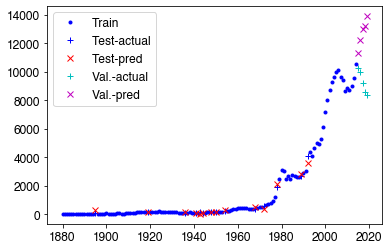

Luther: train 0.998, test 0.996, val -7.776 (981)
Lyle: train 0.998, test 0.960, val -35.465 (982)
Lyman: train 0.993, test 0.928, val -56.848 (983)
Lyndon: train 0.966, test 0.599, val -13.531 (984)
Lynn: train 0.998, test 0.992, val -91.321 (985)
Mac: train 0.951, test 0.105, val -12.036 (986)
Mack: train 0.993, test 0.436, val -50.945 (987)
Mackenzie: train 0.999, test 0.970, val -458.847 (988)
Madden: train 0.999, test 0.991, val -3.838 (989)
Maddox: train 1.000, test 0.998, val -9.312 (990)
Madison: train 0.994, test 0.890, val -6.392 (991)
Major: train 0.996, test 0.991, val -44.215 (992)
Makai: train 0.999, test 0.986, val -0.384 (993)
Malachi: train 1.000, test 0.998, val -4.982 (994)
Malakai: train 1.000, test 0.993, val -1.981 (995)
Malcolm: train 0.998, test 0.967, val -0.321 (996)
Malik: train 0.998, test 0.964, val -2728.723 (997)
Manuel: train 0.999, test 0.990, val -86.815 (998)
Marc: train 1.000, test 0.985, val -5.230 (999)
Marcel: train 0.997, test 0.947, val -123.189

Marcelino: train 0.994, test 0.820, val -99.829 (1001)
Marcello: train 0.998, test 0.908, val -6.406 (1002)
Marcellus: train 0.993, test 0.527, val -1.215 (1003)
Marcelo: train 0.999, test 0.964, val 0.593 (1004)
Marco: train 1.000, test 0.997, val 0.802 (1005)
Marcos: train 1.000, test 0.996, val -11.610 (1006)
Marcus: train 1.000, test 0.998, val 0.570 (1007)
Mariano: train 0.997, test 0.834, val -75.893 (1008)
Mario: train 1.000, test 0.996, val -0.331 (1009)
Marion: train 0.999, test 0.983, val -101.915 (1010)
Mark: train 1.000, test 0.998, val -156.598 (1011)
Markus: train 0.999, test 0.980, val -10.708 (1012)
Marlin: train 0.995, test 0.958, val -16.145 (1013)
Marlon: train 0.998, test 0.936, val -79.103 (1014)
Marques: train 0.997, test 0.973, val -13.157 (1015)
Marquez: train 0.999, test 0.985, val 0.152 (1016)
Marquis: train 1.000, test 0.979, val -30.971 (1017)
Marquise: train 0.999, test 0.989, val -50.915 (1018)
Marshall: train 0.998, test 0.990, val -8.581 (1019)
Martin: t

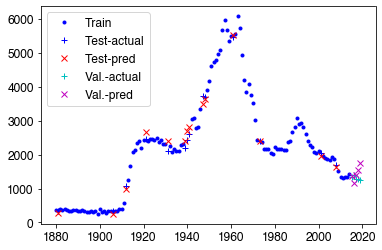

Marty: train 0.999, test 0.905, val -35.487 (1021)
Marvin: train 1.000, test 0.962, val -30.903 (1022)
Mary: train 0.998, test 0.938, val 0.000 (1023)
Mason: train 1.000, test 0.994, val -9.555 (1024)
Mateo: train 1.000, test 0.998, val -2.339 (1025)
Mathew: train 1.000, test 0.997, val 0.442 (1026)
Mathias: train 0.999, test 0.990, val 0.563 (1027)
Matias: train 0.999, test 0.615, val -0.685 (1028)
Matt: train 0.999, test 0.957, val -6.708 (1029)
Matteo: train 1.000, test 0.994, val -112.865 (1030)
Matthew: train 1.000, test 0.998, val -0.190 (1031)
Matthias: train 0.999, test 0.931, val 0.839 (1032)
Maurice: train 0.998, test 0.980, val -4.559 (1033)
Mauricio: train 0.999, test 0.977, val -5.687 (1034)
Mauro: train 0.994, test 0.941, val -54.289 (1035)
Maverick: train 0.999, test 0.924, val -0.085 (1036)
Max: train 0.999, test 0.897, val -0.674 (1037)
Maxim: train 0.999, test 0.961, val -10.952 (1038)
Maximilian: train 1.000, test 0.996, val -0.116 (1039)
Maximiliano: train 0.999, te

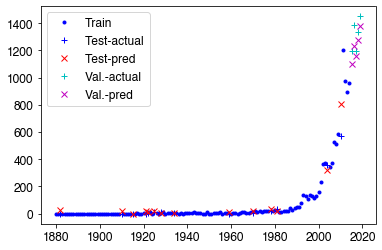

Maximillian: train 0.999, test 0.995, val -71.106 (1041)
Maximo: train 0.998, test 0.895, val -2.406 (1042)
Maximus: train 0.999, test 0.990, val -13.188 (1043)
Maxwell: train 1.000, test 0.997, val -7.012 (1044)
Maynard: train 0.997, test 0.985, val -17.843 (1045)
Mckinley: train 0.984, test 0.900, val -40.769 (1046)
Mekhi: train 0.999, test 0.983, val -1.503 (1047)
Melvin: train 1.000, test 0.956, val -42.000 (1048)
Memphis: train 0.999, test 0.929, val -6.610 (1049)
Menachem: train 0.999, test 0.933, val -75.413 (1050)
Merle: train 0.998, test 0.947, val -1072.146 (1051)
Merlin: train 0.996, test 0.972, val -46.542 (1052)
Merrill: train 0.997, test 0.969, val -64.045 (1053)
Mervin: train 0.994, test 0.926, val -382.399 (1054)
Messiah: train 0.999, test 0.937, val -0.138 (1055)
Micah: train 1.000, test 0.998, val -0.115 (1056)
Michael: train 1.000, test 0.998, val -5.615 (1057)
Micheal: train 1.000, test 0.999, val -4.746 (1058)
Michel: train 0.996, test 0.973, val -21.525 (1059)
Mic

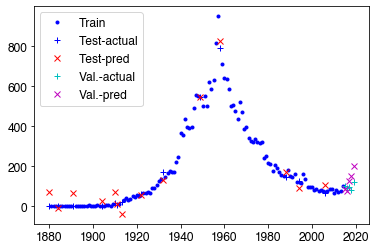

Miguel: train 1.000, test 0.998, val -6.733 (1061)
Mike: train 1.000, test 0.999, val -2246.034 (1062)
Mikel: train 0.996, test 0.974, val -13.048 (1063)
Milan: train 0.995, test 0.345, val -539.753 (1064)
Miles: train 1.000, test 0.993, val -0.106 (1065)
Milford: train 0.998, test 0.972, val 0.000 (1066)
Millard: train 0.997, test 0.972, val -766.226 (1067)
Miller: train 0.996, test 0.958, val -10.550 (1068)
Milo: train 0.999, test 0.997, val -1.175 (1069)
Milton: train 0.999, test 0.918, val -9458.504 (1070)
Misael: train 1.000, test 0.995, val -44.518 (1071)
Mitchel: train 0.998, test 0.993, val -5729.021 (1072)
Mitchell: train 1.000, test 0.998, val -12.619 (1073)
Mohamed: train 1.000, test 0.605, val -125.123 (1074)
Mohammad: train 1.000, test 0.996, val -8.374 (1075)
Mohammed: train 1.000, test 0.989, val -14.602 (1076)
Moises: train 1.000, test 0.990, val -5.935 (1077)
Monroe: train 0.996, test 0.987, val -10.789 (1078)
Monte: train 0.998, test 0.961, val -21.609 (1079)
Monty: t

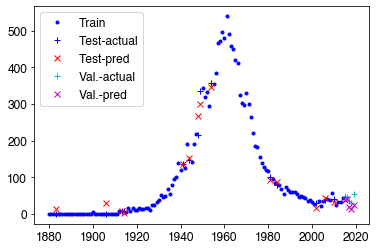

Mordechai: train 0.999, test 0.986, val -1.983 (1081)
Morgan: train 0.999, test 0.980, val -24.571 (1082)
Morris: train 0.998, test 0.970, val -145.109 (1083)
Morton: train 0.998, test 0.961, val -23.296 (1084)
Moses: train 0.997, test 0.942, val -3.632 (1085)
Moshe: train 0.999, test 0.968, val -135.746 (1086)
Muhammad: train 1.000, test 0.990, val -0.185 (1087)
Murray: train 0.998, test 0.989, val -275.756 (1088)
Mustafa: train 0.999, test 0.974, val -29.180 (1089)
Myles: train 1.000, test 0.985, val 0.376 (1090)
Myron: train 0.998, test 0.963, val -117.083 (1091)
Nash: train 0.999, test 0.968, val -0.234 (1092)
Nasir: train 0.999, test 0.949, val -1.934 (1093)
Nathan: train 1.000, test 0.999, val 0.465 (1094)
Nathanael: train 0.999, test 0.989, val 0.163 (1095)
Nathanial: train 0.999, test 0.985, val -152.443 (1096)
Nathaniel: train 1.000, test 0.998, val 0.072 (1097)
Nathen: train 0.999, test 0.635, val -378.178 (1098)
Neal: train 0.999, test 0.975, val -1.230 (1099)
Ned: train 0.9

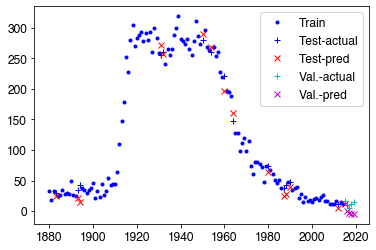

Nehemiah: train 1.000, test 0.994, val -2.241 (1101)
Neil: train 0.999, test 0.982, val -1540.847 (1102)
Nelson: train 0.997, test 0.920, val -346.246 (1103)
Nestor: train 0.999, test 0.965, val -7.647 (1104)
Newton: train 0.995, test 0.870, val -39.178 (1105)
Nicholas: train 1.000, test 0.999, val 0.019 (1106)
Nick: train 0.998, test 0.967, val -49.914 (1107)
Nickolas: train 1.000, test 0.993, val -2.130 (1108)
Nicky: train 0.995, test 0.967, val -355.058 (1109)
Nico: train 0.998, test 0.914, val 0.148 (1110)
Nicolas: train 1.000, test 0.996, val -2.452 (1111)
Nigel: train 0.999, test 0.995, val -5.589 (1112)
Niko: train 0.999, test 0.988, val -0.062 (1113)
Nikolai: train 1.000, test 0.973, val -19.886 (1114)
Nikolas: train 0.999, test 0.990, val -11.442 (1115)
Nixon: train 0.999, test 0.996, val -3.546 (1116)
Noah: train 1.000, test 0.998, val -25.389 (1117)
Noe: train 0.999, test 0.970, val -53.159 (1118)
Noel: train 0.999, test 0.944, val -133.898 (1119)
Nolan: train 1.000, test 0.

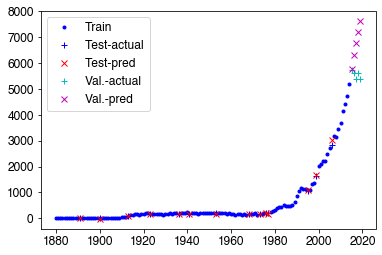

Norbert: train 0.999, test 0.984, val -172.352 (1121)
Norman: train 0.999, test 0.993, val -217.492 (1122)
Norris: train 0.998, test 0.969, val -41.846 (1123)
Oakley: train 0.998, test 0.469, val 0.207 (1124)
Octavio: train 0.996, test 0.949, val -4.357 (1125)
Odell: train 0.997, test 0.924, val -12.092 (1126)
Odin: train 0.999, test 0.683, val 0.872 (1127)
Odis: train 0.995, test 0.833, val -30.197 (1128)
Olen: train 0.996, test 0.883, val -9.076 (1129)
Olin: train 0.987, test 0.896, val -40.063 (1130)
Oliver: train 0.999, test 0.955, val -30.396 (1131)
Ollie: train 0.996, test 0.914, val -11.441 (1132)
Omar: train 1.000, test 0.996, val -4.670 (1133)
Omari: train 0.999, test 0.987, val -119.912 (1134)
Orion: train 1.000, test 0.802, val -1.684 (1135)
Orlando: train 0.999, test 0.987, val -48.847 (1136)
Orval: train 0.997, test 0.956, val 0.000 (1137)
Orville: train 0.998, test 0.979, val -559.753 (1138)
Oscar: train 0.999, test 0.979, val -3.008 (1139)
Osvaldo: train 0.999, test 0.95

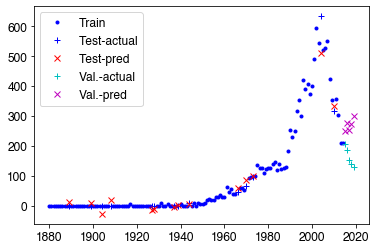

Oswaldo: train 0.997, test 0.894, val -218.515 (1141)
Otis: train 0.998, test 0.972, val -36.772 (1142)
Otto: train 0.997, test 0.947, val 0.272 (1143)
Owen: train 1.000, test 0.997, val -8.740 (1144)
Pablo: train 0.999, test 0.988, val -48.924 (1145)
Paris: train 0.996, test 0.930, val -7.756 (1146)
Parker: train 1.000, test 0.993, val -8.055 (1147)
Pasquale: train 0.994, test 0.937, val -96.858 (1148)
Pat: train 0.999, test 0.986, val 0.000 (1149)
Patrick: train 1.000, test 0.969, val -1.113 (1150)
Patsy: train 0.998, test 0.980, val 0.000 (1151)
Paul: train 1.000, test 0.987, val -5.906 (1152)
Paxton: train 0.999, test 0.994, val -1.802 (1153)
Payton: train 0.999, test 0.957, val 0.874 (1154)
Pedro: train 1.000, test 0.992, val -0.994 (1155)
Percy: train 0.996, test 0.962, val -3.588 (1156)
Perry: train 0.999, test 0.975, val -541.159 (1157)
Pete: train 0.999, test 0.970, val -69.993 (1158)
Peter: train 1.000, test 0.994, val -70.011 (1159)
Peyton: train 0.998, test 0.993, val -5.89

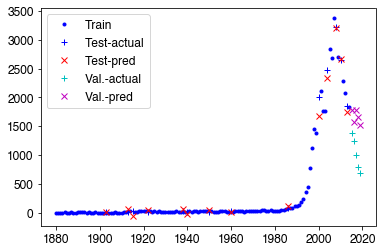

Phil: train 0.998, test 0.973, val -1102.959 (1161)
Philip: train 0.999, test 0.991, val -1495.820 (1162)
Phillip: train 1.000, test 0.994, val -3.218 (1163)
Phoenix: train 1.000, test 0.966, val -2.761 (1164)
Pierce: train 0.999, test 0.989, val -0.898 (1165)
Pierre: train 0.998, test 0.978, val -158.785 (1166)
Porter: train 1.000, test 0.920, val -12.995 (1167)
Preston: train 1.000, test 0.982, val -9.926 (1168)
Prince: train 0.999, test 0.988, val 0.406 (1169)
Princeton: train 0.999, test 0.909, val -25.656 (1170)
Quentin: train 0.998, test 0.936, val -3.903 (1171)
Quincy: train 0.999, test 0.973, val 0.457 (1172)
Quinn: train 0.999, test 0.930, val -2.657 (1173)
Quinten: train 0.999, test 0.963, val -24.133 (1174)
Quintin: train 0.999, test 0.985, val 0.387 (1175)
Quinton: train 0.999, test 0.975, val 0.137 (1176)
Rafael: train 1.000, test 0.992, val -0.024 (1177)
Raheem: train 0.999, test 0.872, val -67.774 (1178)
Raiden: train 1.000, test 0.992, val 0.295 (1179)
Raleigh: train 0.

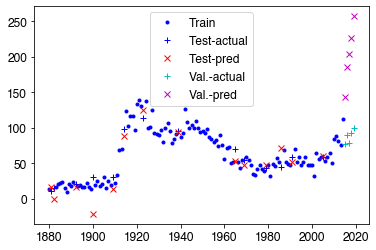

Ralph: train 0.999, test 0.970, val -1105.961 (1181)
Ramiro: train 0.999, test 0.996, val -56.709 (1182)
Ramon: train 0.999, test 0.978, val -36.134 (1183)
Ramsey: train 0.995, test 0.880, val -35.073 (1184)
Randal: train 0.999, test 0.994, val -54.709 (1185)
Randall: train 1.000, test 0.994, val -15.630 (1186)
Randell: train 0.998, test 0.990, val -8.822 (1187)
Randolph: train 0.999, test 0.991, val -65.802 (1188)
Randy: train 1.000, test 0.993, val -19.841 (1189)
Raphael: train 0.998, test 0.972, val -122.283 (1190)
Rashad: train 0.998, test 0.919, val -57.871 (1191)
Rashawn: train 0.998, test 0.971, val -15.668 (1192)
Raul: train 1.000, test 0.995, val -11.280 (1193)
Ray: train 0.999, test 0.942, val -529.129 (1194)
Rayan: train 1.000, test 0.915, val -64.696 (1195)
Raymond: train 0.999, test 0.993, val -25.918 (1196)
Raymundo: train 0.996, test 0.959, val -22.305 (1197)
Reagan: train 0.997, test 0.990, val -49.700 (1198)
Reece: train 1.000, test 0.997, val -54.327 (1199)
Reed: trai

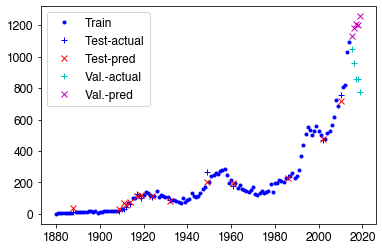

Reese: train 1.000, test 0.993, val -18.912 (1201)
Reggie: train 0.997, test 0.939, val -1.018 (1202)
Reginald: train 1.000, test 0.992, val -393.145 (1203)
Reid: train 0.999, test 0.979, val -3.638 (1204)
Remington: train 0.999, test 0.995, val -1.201 (1205)
Remy: train 0.999, test 0.908, val -41.306 (1206)
Rene: train 0.999, test 0.982, val -1.996 (1207)
Reuben: train 0.994, test 0.943, val -175.027 (1208)
Rex: train 0.998, test 0.959, val -59.232 (1209)
Rey: train 0.999, test 0.985, val -4.592 (1210)
Reynaldo: train 0.997, test 0.974, val -8.138 (1211)
Rhett: train 0.998, test 0.953, val -0.856 (1212)
Rhys: train 1.000, test 0.995, val 0.215 (1213)
Ricardo: train 1.000, test 0.998, val -1.740 (1214)
Richard: train 0.999, test 0.996, val -50.576 (1215)
Richie: train 0.998, test 0.628, val -115.335 (1216)
Rick: train 1.000, test 0.992, val -888.430 (1217)
Rickey: train 1.000, test 0.990, val -6.712 (1218)
Rickie: train 0.998, test 0.992, val -17.890 (1219)
Ricky: train 1.000, test 0.9

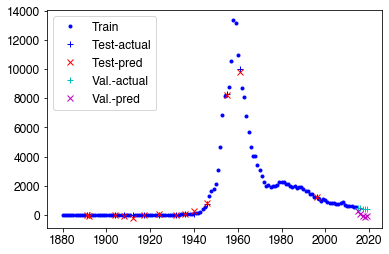

Rico: train 0.997, test 0.930, val -100.102 (1221)
Rigoberto: train 0.999, test 0.904, val -37.536 (1222)
Riley: train 1.000, test 0.992, val 0.340 (1223)
River: train 0.999, test 0.967, val 0.934 (1224)
Rob: train 0.999, test 0.991, val -13.042 (1225)
Robbie: train 0.999, test 0.962, val -26.961 (1226)
Robby: train 0.998, test 0.985, val -161.932 (1227)
Robert: train 1.000, test 0.995, val -30.384 (1228)
Roberto: train 1.000, test 0.997, val -6.491 (1229)
Robin: train 0.998, test 0.957, val -165.645 (1230)
Rocco: train 0.998, test 0.971, val -37.461 (1231)
Rocky: train 0.999, test 0.976, val -17.350 (1232)
Rod: train 0.997, test 0.982, val -35.931 (1233)
Roderick: train 0.999, test 0.986, val 0.345 (1234)
Rodger: train 0.998, test 0.957, val -171.994 (1235)
Rodney: train 1.000, test 0.992, val -61.605 (1236)
Rodolfo: train 0.999, test 0.962, val -71.062 (1237)
Rodrick: train 0.998, test 0.971, val -113.870 (1238)
Rodrigo: train 0.999, test 0.599, val -309.863 (1239)
Rogelio: train 0.9

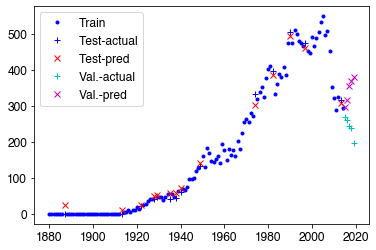

Roger: train 0.999, test 0.980, val -36.892 (1241)
Rogers: train 0.994, test 0.947, val -43.739 (1242)
Rohan: train 0.999, test 0.988, val -3.221 (1243)
Roland: train 0.999, test 0.987, val -3.557 (1244)
Rolando: train 0.999, test 0.986, val 0.292 (1245)
Rolland: train 0.995, test 0.962, val -12.971 (1246)
Roman: train 0.999, test 0.978, val -2.998 (1247)
Romeo: train 0.999, test 0.961, val 0.346 (1248)
Ron: train 0.999, test 0.958, val -388.033 (1249)
Ronald: train 0.999, test 0.982, val -547.601 (1250)
Ronaldo: train 0.997, test 0.883, val -11.441 (1251)
Ronan: train 1.000, test 0.910, val -0.143 (1252)
Ronin: train 0.998, test 0.989, val -63.195 (1253)
Ronnie: train 0.999, test 0.981, val -132.031 (1254)
Ronny: train 0.998, test 0.909, val -75.879 (1255)
Roosevelt: train 0.995, test 0.871, val -1101.802 (1256)
Rory: train 0.995, test 0.847, val -74.741 (1257)
Roscoe: train 0.996, test 0.943, val -2.801 (1258)
Ross: train 0.999, test 0.980, val -682.147 (1259)
Rowan: train 0.999, tes

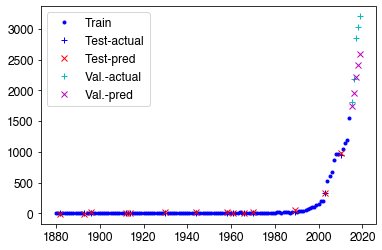

Roy: train 0.999, test 0.976, val -401.633 (1261)
Royal: train 0.990, test 0.754, val -132.409 (1262)
Royce: train 0.998, test 0.979, val -2.082 (1263)
Ruben: train 1.000, test 0.995, val -6.392 (1264)
Rudolph: train 0.995, test 0.948, val -8036.180 (1265)
Rudy: train 0.998, test 0.978, val -146.906 (1266)
Rufus: train 0.998, test 0.991, val -111.619 (1267)
Russ: train 0.999, test 0.969, val -47.339 (1268)
Russel: train 0.997, test 0.966, val -0.307 (1269)
Russell: train 1.000, test 0.982, val -2771.411 (1270)
Rusty: train 0.998, test 0.972, val -639.946 (1271)
Ryan: train 1.000, test 0.997, val -2.243 (1272)
Ryder: train 1.000, test -0.505, val -23.944 (1273)
Ryker: train 1.000, test 0.156, val -5.720 (1274)
Rylan: train 0.999, test 0.547, val -17.093 (1275)
Ryland: train 0.999, test 0.964, val -35.712 (1276)
Sage: train 0.998, test 0.989, val 0.798 (1277)
Salvador: train 0.999, test 0.993, val -0.538 (1278)
Salvatore: train 0.998, test 0.971, val -13.669 (1279)
Sam: train 0.998, test

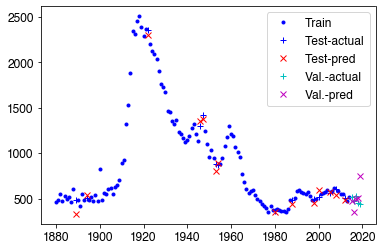

Samir: train 0.999, test 0.994, val -2.688 (1281)
Sammie: train 0.998, test 0.975, val -21.617 (1282)
Sammy: train 0.999, test 0.982, val -12.051 (1283)
Samson: train 0.999, test 0.930, val -3.115 (1284)
Samuel: train 1.000, test 0.994, val 0.049 (1285)
Sandy: train 0.993, test 0.956, val -374.780 (1286)
Sanford: train 0.997, test 0.926, val -634.283 (1287)
Santana: train 0.998, test 0.984, val 0.197 (1288)
Santiago: train 1.000, test 0.884, val 0.818 (1289)
Santino: train 0.999, test 0.970, val 0.622 (1290)
Santos: train 0.997, test 0.961, val -14.817 (1291)
Saul: train 1.000, test 0.975, val -15.602 (1292)
Sawyer: train 1.000, test 0.997, val -11.207 (1293)
Scot: train 0.999, test 0.665, val -50.542 (1294)
Scott: train 1.000, test 1.000, val -813.286 (1295)
Scottie: train 0.998, test 0.889, val -21.196 (1296)
Scotty: train 0.998, test 0.898, val -165.286 (1297)
Seamus: train 1.000, test 0.977, val -1.382 (1298)
Sean: train 1.000, test 0.995, val -0.810 (1299)
Sebastian: train 0.999, 

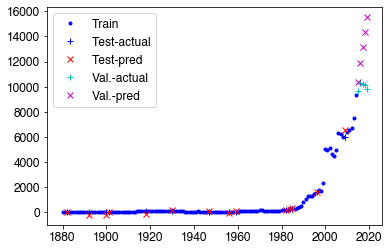

Semaj: train 0.999, test 0.970, val -28.349 (1301)
Sergio: train 1.000, test 0.993, val -6.735 (1302)
Seth: train 1.000, test 0.993, val -0.029 (1303)
Seymour: train 0.998, test 0.968, val -614.121 (1304)
Shamar: train 0.999, test 0.991, val -46.118 (1305)
Shane: train 1.000, test 0.996, val -8.008 (1306)
Shannon: train 0.999, test 0.981, val -1311.066 (1307)
Shaquille: train 0.991, test 0.857, val -6768.553 (1308)
Shaun: train 0.997, test 0.964, val -1664.917 (1309)
Shawn: train 1.000, test 0.998, val -1.594 (1310)
Shayne: train 0.998, test 0.964, val -8.362 (1311)
Shea: train 0.997, test 0.957, val -18.173 (1312)
Shelby: train 0.996, test 0.967, val -1049.493 (1313)
Sheldon: train 0.998, test 0.961, val -246.051 (1314)
Shelton: train 0.995, test 0.955, val -19.094 (1315)
Sherman: train 0.997, test 0.934, val -52.939 (1316)
Shirley: train 0.989, test 0.918, val 0.000 (1317)
Sidney: train 0.997, test 0.985, val -830.362 (1318)
Silas: train 0.999, test -0.051, val -25.874 (1319)
Simeon:

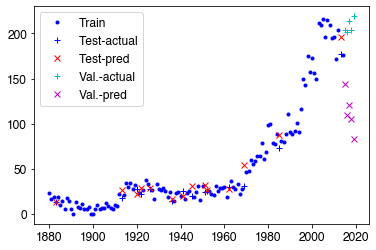

Simon: train 0.999, test 0.993, val -2.176 (1321)
Sincere: train 1.000, test 0.983, val -3.017 (1322)
Skylar: train 0.999, test 0.997, val -1.229 (1323)
Skyler: train 1.000, test 0.996, val -0.875 (1324)
Solomon: train 0.998, test 0.789, val -2.715 (1325)
Sonny: train 0.996, test 0.849, val -2.918 (1326)
Soren: train 1.000, test 0.980, val -25.691 (1327)
Spencer: train 1.000, test 0.983, val -1.536 (1328)
Stacey: train 0.995, test 0.865, val -5602.318 (1329)
Stacy: train 0.993, test 0.591, val -782.933 (1330)
Stan: train 0.998, test 0.182, val -75.001 (1331)
Stanford: train 0.991, test 0.805, val -17.053 (1332)
Stanley: train 0.999, test 0.973, val -678.387 (1333)
Stefan: train 0.999, test 0.969, val -3.256 (1334)
Stephan: train 0.999, test 0.990, val -4.122 (1335)
Stephen: train 1.000, test 0.997, val -26.274 (1336)
Stephon: train 0.997, test 0.921, val -49.923 (1337)
Sterling: train 0.997, test 0.967, val 0.690 (1338)
Stetson: train 0.999, test 0.987, val 0.924 (1339)
Steve: train 0.

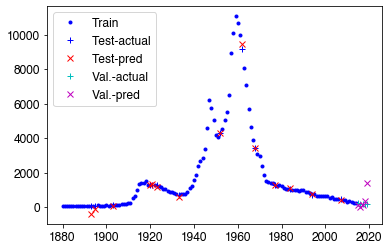

Steven: train 1.000, test 0.998, val -10.635 (1341)
Stevie: train 0.998, test 0.974, val -45.293 (1342)
Stewart: train 0.998, test 0.936, val -5.112 (1343)
Stone: train 0.999, test 0.983, val -1.993 (1344)
Stuart: train 0.998, test 0.979, val -55.910 (1345)
Sullivan: train 0.999, test -5.386, val -2.377 (1346)
Sydney: train 0.994, test 0.852, val -92.183 (1347)
Syed: train 0.998, test 0.962, val -31.531 (1348)
Sylas: train 0.999, test -25.745, val -63.401 (1349)
Sylvester: train 0.998, test 0.955, val -870.593 (1350)
Tad: train 0.997, test 0.923, val -26.869 (1351)
Talon: train 0.999, test 0.973, val -3.452 (1352)
Tanner: train 1.000, test 0.994, val 0.727 (1353)
Tariq: train 0.995, test 0.683, val -117.213 (1354)
Tate: train 1.000, test 0.991, val -51.474 (1355)
Tatum: train 0.999, test 0.944, val 0.081 (1356)
Taylor: train 1.000, test 0.996, val -84.813 (1357)
Ted: train 0.999, test 0.988, val -3373.345 (1358)
Teddy: train 0.999, test 0.958, val -8.430 (1359)
Terence: train 0.998, te

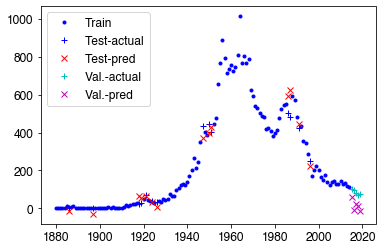

Terrance: train 0.999, test 0.982, val -12.743 (1361)
Terrell: train 0.999, test 0.981, val -29.702 (1362)
Terrence: train 0.999, test 0.982, val -1.064 (1363)
Terry: train 0.999, test 0.996, val -129.528 (1364)
Tevin: train 0.991, test -406.598, val -1752.549 (1365)
Thad: train 0.993, test 0.952, val -1326.897 (1366)
Thaddeus: train 0.994, test 0.936, val -27.984 (1367)
Theo: train 0.997, test 0.738, val -0.067 (1368)
Theodore: train 0.999, test 0.963, val 0.472 (1369)
Theron: train 0.992, test 0.788, val -66.427 (1370)
Thiago: train 0.999, test 0.901, val -5.386 (1371)
Thomas: train 0.999, test 0.997, val -5.543 (1372)
Thurman: train 0.997, test 0.834, val -143.897 (1373)
Tim: train 1.000, test 0.988, val -2420.954 (1374)
Timmy: train 0.999, test 0.991, val -2277.257 (1375)
Timothy: train 1.000, test 0.998, val -78.225 (1376)
Titus: train 1.000, test 0.878, val -24.639 (1377)
Tobias: train 1.000, test 0.971, val -28.588 (1378)
Toby: train 0.999, test 0.987, val -0.344 (1379)
Tod: tra

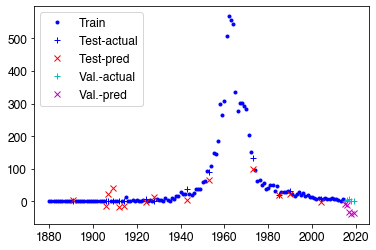

Todd: train 1.000, test 0.983, val -95.548 (1381)
Tom: train 0.999, test 0.955, val -4834.389 (1382)
Tomas: train 0.998, test 0.983, val -174.595 (1383)
Tommie: train 0.998, test 0.984, val -162.206 (1384)
Tommy: train 0.999, test 0.984, val -874.000 (1385)
Tony: train 1.000, test 0.997, val -44.180 (1386)
Tory: train 0.999, test 0.981, val 0.625 (1387)
Trace: train 0.999, test 0.972, val -119.576 (1388)
Tracey: train 0.997, test 0.993, val -291.672 (1389)
Tracy: train 0.998, test 0.990, val -135.977 (1390)
Travis: train 1.000, test 0.998, val -30.668 (1391)
Travon: train 0.999, test 0.948, val -146.134 (1392)
Tre: train 0.997, test 0.790, val -101.688 (1393)
Trent: train 1.000, test 0.969, val -2.975 (1394)
Trenton: train 1.000, test 0.997, val 0.735 (1395)
Trever: train 0.999, test 0.985, val -2.678 (1396)
Trevon: train 0.999, test 0.975, val -801.105 (1397)
Trevor: train 1.000, test 0.995, val 0.144 (1398)
Trey: train 0.999, test 0.994, val -23.629 (1399)
Tripp: train 0.999, test 0.

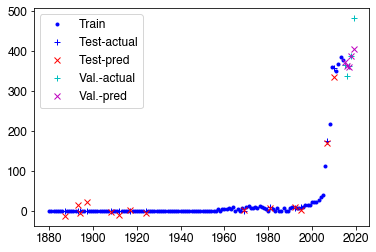

Tristan: train 0.999, test 0.997, val -4.653 (1401)
Tristen: train 0.999, test 0.987, val -4.432 (1402)
Tristian: train 0.999, test 0.979, val -49.406 (1403)
Tristin: train 0.998, test 0.977, val -18.443 (1404)
Triston: train 0.999, test 0.984, val -2.223 (1405)
Troy: train 0.999, test 0.960, val -6.127 (1406)
Truman: train 0.970, test 0.907, val -9.040 (1407)
Tucker: train 1.000, test 0.994, val -49.513 (1408)
Turner: train 0.998, test 0.956, val -8.836 (1409)
Ty: train 0.999, test 0.984, val -56.870 (1410)
Tyler: train 1.000, test 0.996, val 0.600 (1411)
Tylor: train 1.000, test 0.987, val -49.890 (1412)
Tyree: train 0.999, test 0.990, val -0.168 (1413)
Tyrell: train 0.999, test 0.982, val -57.405 (1414)
Tyrese: train 0.968, test 0.880, val -109.708 (1415)
Tyron: train 0.997, test 0.976, val -138.480 (1416)
Tyrone: train 0.999, test 0.987, val -16.822 (1417)
Tyson: train 1.000, test 0.995, val 0.548 (1418)
Ulises: train 0.999, test 0.967, val -44.434 (1419)
Ulysses: train 0.994, test

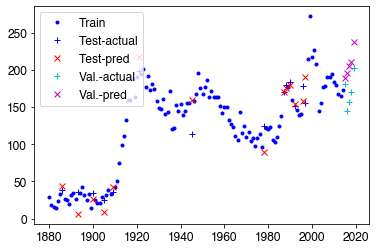

Unknown: train 0.995, test 0.931, val -48.818 (1421)
Uriah: train 0.999, test 0.899, val -12.995 (1422)
Uriel: train 1.000, test 0.915, val -2.170 (1423)
Valentin: train 0.997, test 0.949, val -63.633 (1424)
Valentino: train 0.997, test 0.927, val -15.683 (1425)
Van: train 0.997, test 0.929, val -55.601 (1426)
Vance: train 0.995, test 0.940, val -17.741 (1427)
Vaughn: train 0.996, test 0.947, val -4.573 (1428)
Vern: train 0.996, test 0.938, val -244.944 (1429)
Vernon: train 0.999, test 0.986, val -829.852 (1430)
Vicente: train 0.999, test 0.992, val -48.500 (1431)
Victor: train 0.999, test 0.979, val -21.337 (1432)
Vince: train 0.995, test 0.942, val -66.061 (1433)
Vincent: train 0.999, test 0.975, val -9.026 (1434)
Vincenzo: train 0.999, test 0.989, val -2.633 (1435)
Virgil: train 0.999, test 0.977, val -83.526 (1436)
Vito: train 0.994, test 0.962, val -744.971 (1437)
Vladimir: train 0.997, test 0.956, val -8.989 (1438)
Wade: train 0.999, test 0.950, val -4.977 (1439)
Walker: train 0.

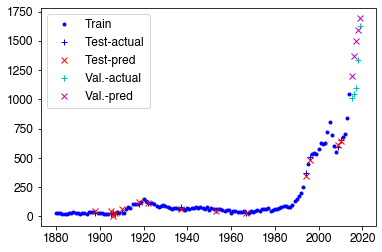

Wallace: train 0.995, test 0.966, val -104.935 (1441)
Walter: train 0.999, test 0.994, val -10.703 (1442)
Ward: train 0.995, test 0.937, val -60.035 (1443)
Warren: train 0.997, test 0.975, val -23.093 (1444)
Waylon: train 0.999, test 0.971, val -1.114 (1445)
Wayne: train 1.000, test 0.989, val -53.743 (1446)
Weldon: train 0.996, test 0.945, val -5.793 (1447)
Wendell: train 0.998, test 0.818, val -933.322 (1448)
Wesley: train 0.999, test 0.884, val 0.196 (1449)
Westley: train 0.996, test 0.931, val -0.957 (1450)
Weston: train 1.000, test 0.981, val -11.892 (1451)
Wilbert: train 0.998, test 0.982, val -22.037 (1452)
Wilbur: train 0.998, test 0.989, val -644.815 (1453)
Wilburn: train 0.997, test 0.828, val 0.000 (1454)
Wiley: train 0.990, test 0.884, val -11.706 (1455)
Wilford: train 0.997, test 0.891, val -3.619 (1456)
Wilfred: train 0.998, test 0.963, val -1731.898 (1457)
Wilfredo: train 0.998, test 0.961, val 0.095 (1458)
Will: train 0.995, test 0.863, val -12.748 (1459)
Willard: train

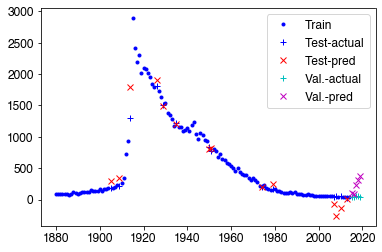

William: train 0.999, test 0.956, val -47.030 (1461)
Willie: train 0.999, test 0.954, val -28.308 (1462)
Willis: train 0.998, test 0.959, val -7.378 (1463)
Wilmer: train 0.996, test 0.986, val -9.823 (1464)
Wilson: train 0.989, test 0.802, val -6.541 (1465)
Wilton: train 0.995, test 0.900, val -55.096 (1466)
Winfred: train 0.996, test 0.936, val -221.388 (1467)
Winston: train 0.991, test 0.626, val 0.925 (1468)
Woodrow: train 0.996, test 0.908, val -8324.274 (1469)
Wyatt: train 1.000, test 0.995, val -5.077 (1470)
Xander: train 0.999, test -0.282, val -0.059 (1471)
Xavier: train 1.000, test 0.991, val 0.456 (1472)
Xzavier: train 0.999, test 0.118, val 0.850 (1473)
Yahir: train 0.993, test 0.938, val -19.262 (1474)
Yehuda: train 0.999, test 0.979, val -21.908 (1475)
Yisroel: train 0.999, test 0.973, val -8.605 (1476)
Yosef: train 0.999, test 0.992, val -117.425 (1477)
Yousef: train 0.999, test 0.884, val -84.184 (1478)
Yusuf: train 1.000, test 0.988, val -24.227 (1479)
Zachariah: train 

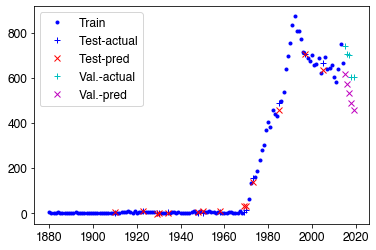

Zachary: train 1.000, test 0.999, val 0.309 (1481)
Zachery: train 1.000, test 0.979, val -6.930 (1482)
Zack: train 0.997, test 0.955, val -60.660 (1483)
Zackary: train 1.000, test 0.998, val 0.403 (1484)
Zackery: train 1.000, test 0.994, val -6.036 (1485)
Zaid: train 1.000, test 0.286, val -2.681 (1486)
Zaiden: train 0.999, test 0.000, val -28.536 (1487)
Zain: train 1.000, test 0.560, val 0.416 (1488)
Zaire: train 1.000, test 0.911, val -1.027 (1489)
Zakary: train 0.999, test 0.991, val -4.168 (1490)
Zander: train 1.000, test 0.970, val -2.413 (1491)
Zane: train 1.000, test 0.994, val -0.922 (1492)
Zavier: train 0.999, test 0.979, val -12.851 (1493)
Zayden: train 1.000, test 0.997, val -249.351 (1494)
Zayn: train 0.999, test 0.714, val -3.563 (1495)
Zayne: train 1.000, test 0.983, val -0.167 (1496)
Zechariah: train 0.999, test 0.986, val -6.180 (1497)
Zeke: train 0.998, test 0.948, val -10.176 (1498)
Zion: train 1.000, test 0.934, val -3.417 (1499)
CPU times: user 4min 42s, sys: 7.81 s

In [49]:
%%time

X_examp = np.hstack([cc_norm2.T, np.arange(1880,2020).reshape(-1,1)])

#Re-fit using entire set prior to the last 5 years. Repeat this multiple
#times using random sets of the data each time. 

n_refits = 20
name_linmodels = []
# name_linmodels = np.zeros([nametest_M_birth.shape[0], X_examp.shape[1], n_refits])
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = nametest_M_birth[n,:].T

    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])

    #Primitive bootstrap: Fit on partial data repeatedly, then average. 
    #Year split:
    X_train, X_test, y_train, y_test = train_test_split(X_examp[:-5], y_examp[:-5], test_size=0.1)
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    #name_linmodels[m, :, n] = lin_mod.coef_

    test_score = lin_mod.score(X_examp[-5:], y_examp[-5:])
    test_scores.append(test_score)
    print('{0}: train {1:.3f}, test {2:.3f}, val {3:.3f} ({4})'.format(nametest_M_name.iloc[n],
                                                                       lin_mod.score(X_train, y_train),
                                                                       lin_mod.score(X_test, y_test),
                                                                       test_score,
                                                                       n
                                                                      ))
    y_pred_st = lin_mod.predict(X_test)
    y_pred_fu = lin_mod.predict(X_examp[-5:])
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        plt.plot(X_test[:,-1], y_test, 'b+')
        plt.plot(X_test[:,-1], y_pred_st, 'rx')
        plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

As you can see in the interspersed test plots, while the scores are very poor, that's because the scoring compares them against the *known* mean value of the last five years. They're actually reasonable predictions given the past history of the name in most cases! Even hitting a score of zero (performing as well as the actual mean of the last five years) is quite good. There are a few notable problems, though. For example, the estimates are often overly-optimistic for names that are currently in a long-term low. It really thought Bert and Cletus were going to come back, for example. Similarly, it sometimes heads significantly negative, which is an obvious problem. 

In [52]:
len(name_linmodels)

1500

## Name trend detection preliminary conclusion:

With careful variable preprocessing, a simple linear model does a surprisingly good job of tracking name trends without drastic overfitting. I'd need to extend this significantly to allow next-year prediction (i.e. generating projected name-cluster data), but it's a clear sign that we can reasonably track some trends for relatively popular names. To use the prior model for predictions, we'd have to generate synthetic cluster-trend data, which is feasible. For example, let's plug what we have into a time-series model like ARIMA, which uses the time course of the data to project its future trajectory. This is like to do reasonably well for near-future projection, and we can use that projection to generate the synthetic cluster trends necessary for the linear model to predict. Of course, we could also use the ARIMA directly on each name, but that would take hours for the full set of names compared to seconds for the linear model, and would also discard the information we can calculate about how names trend together. 

(Aside: This might actually be a pretty good spot for a multidimensional Kalman filter, which would use information from each timecourse variable quite nicely. I've been waiting for an excuse to get one of those going, might finally be the time!)  
(Also, there are 0 babies named Arima in the names database, which is honestly a little surprising.)

## ARIMA name timecourse projection:


In [54]:
len(names_df_trim[names_df_trim['Name'] == 'Arima'])

0

In [55]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [57]:
%%time

#Testing this on most recent 5 years, so all but last 5 in training set
tsize = 135

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    y_train, y_test = train_test_split(y, train_size=tsize)

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(y_test.shape[0])  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

CPU times: user 23min 31s, sys: 20.2 s, total: 23min 51s
Wall time: 7min 14s


In [58]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

### Actual name trend predictions:

In [86]:
%%time

#STEP 1: REDO THE ARIMAS WITH ALL YEARS

tsize = 140

num_clust = cc_norm2.shape[0]

arima_mods = []
for n in range(num_clust):
    y = cc_norm2[n,:]
    #y_train, y_test = train_test_split(y, train_size=tsize)
    y_train = y

    arima_mod = pm.auto_arima(y_train)

    y_pred = arima_mod.predict(5)  # predict N steps into the future

    ## Visualize the forecasts (blue=train, green=forecasts)
    #x = np.arange(y.shape[0])
    #plt.plot(x[:tsize], y_train, c='blue')
    #plt.plot(x[tsize:], y[tsize:], 'b--')
    #plt.plot(x[tsize:], y_pred, c='green')
    #plt.show()
    
    arima_mods.append(arima_mod)

CPU times: user 23min 27s, sys: 19.6 s, total: 23min 46s
Wall time: 7min 12s


In [92]:
y_pred_arima.shape

(166, 5)

In [102]:
#Build the predicted-cluster-trend matrix

y_pred_arima = np.zeros([num_clust, 5])
for n in range(num_clust):
    y_pred_arima[n,:] = arima_mods[n].predict(5)

#Add the pre-predicted value to the stack to convert the 5
#predicted values to a change (6 vals -> 5 differences)
baseval = cc_norm2[:,-1]
y_pred_arima = np.hstack([baseval.reshape(-1,1),y_pred_arima])
#Calculate the X-predicted in the difference format:
X_pred_arima = np.hstack([np.diff(y_pred_arima).T, np.arange(2020,2025).reshape(-1,1)])

In [103]:
X_pred_arima.shape

(5, 167)

In [104]:
X_examp.shape

(139, 167)

Aarav: train 0.961 (0)


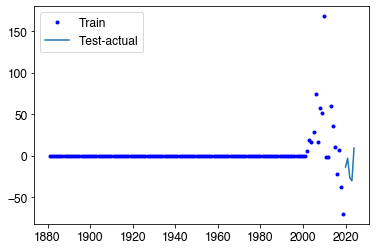

Aaron: train 0.971 (1)
Abdiel: train 0.982 (2)
Abdul: train 0.905 (3)
Abdullah: train 0.977 (4)
Abe: train 0.819 (5)
Abel: train 0.951 (6)
Abner: train 0.901 (7)
Abraham: train 0.926 (8)
Abram: train 0.914 (9)
Ace: train 0.969 (10)
Adam: train 0.981 (11)
Adan: train 0.957 (12)
Addison: train 0.953 (13)
Aden: train 0.981 (14)
Adolfo: train 0.936 (15)
Adolph: train 0.853 (16)
Adonis: train 0.962 (17)
Adrian: train 0.977 (18)
Adriel: train 0.985 (19)
Adrien: train 0.904 (20)


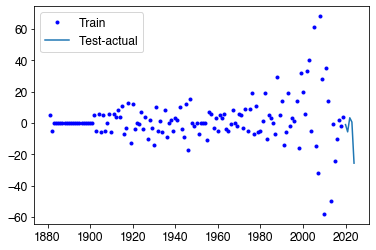

Agustin: train 0.938 (21)
Ahmad: train 0.965 (22)
Ahmed: train 0.928 (23)
Aidan: train 0.980 (24)
Aiden: train 0.990 (25)
Akeem: train 0.936 (26)
Al: train 0.883 (27)
Alan: train 0.912 (28)
Albert: train 0.888 (29)
Alberto: train 0.954 (30)
Alden: train 0.888 (31)
Aldo: train 0.927 (32)
Alec: train 0.976 (33)
Alejandro: train 0.965 (34)
Alessandro: train 0.918 (35)
Alex: train 0.958 (36)
Alexander: train 0.990 (37)
Alexandro: train 0.943 (38)
Alexis: train 0.957 (39)
Alexzander: train 0.980 (40)


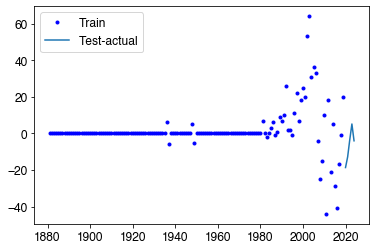

Alfonso: train 0.923 (41)
Alfred: train 0.916 (42)
Alfredo: train 0.904 (43)
Ali: train 0.955 (44)
Alijah: train 0.972 (45)
Allan: train 0.861 (46)
Allen: train 0.881 (47)
Alonso: train 0.902 (48)
Alonzo: train 0.860 (49)
Alphonse: train 0.835 (50)
Alphonso: train 0.839 (51)
Alton: train 0.906 (52)
Alva: train 0.867 (53)
Alvaro: train 0.921 (54)
Alvin: train 0.888 (55)
Amare: train 0.960 (56)
Amari: train 0.971 (57)
Amir: train 0.985 (58)
Amos: train 0.840 (59)
Anders: train 0.928 (60)


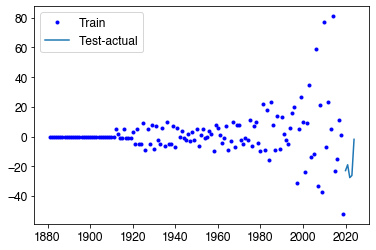

Anderson: train 0.969 (61)
Andre: train 0.938 (62)
Andrea: train 0.881 (63)
Andreas: train 0.926 (64)
Andres: train 0.960 (65)
Andrew: train 0.987 (66)
Andy: train 0.947 (67)
Angel: train 0.987 (68)
Angelo: train 0.903 (69)
Anson: train 0.946 (70)
Anthony: train 0.973 (71)
Antoine: train 0.958 (72)
Anton: train 0.901 (73)
Antonio: train 0.972 (74)
Antony: train 0.930 (75)
Antwan: train 0.962 (76)
Antwon: train 0.903 (77)
Archer: train 0.988 (78)
Archie: train 0.900 (79)
Ari: train 0.975 (80)


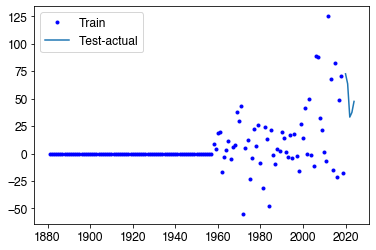

Arian: train 0.964 (81)
Aric: train 0.945 (82)
Ariel: train 0.915 (83)
Arjun: train 0.943 (84)
Arlo: train 0.968 (85)
Armand: train 0.850 (86)
Armando: train 0.928 (87)
Armani: train 0.965 (88)
Arnold: train 0.884 (89)
Arnulfo: train 0.785 (90)
Aron: train 0.927 (91)
Arron: train 0.884 (92)
Arthur: train 0.911 (93)
Arturo: train 0.936 (94)
Aryan: train 0.958 (95)
Asa: train 0.935 (96)
Asher: train 0.986 (97)
Ashley: train 0.950 (98)
Ashton: train 0.974 (99)
Atlas: train 0.993 (100)


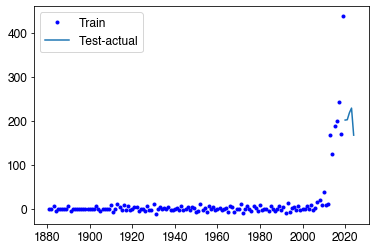

Atticus: train 0.957 (101)
Aubrey: train 0.896 (102)
August: train 0.950 (103)
Augustine: train 0.885 (104)
Augustus: train 0.924 (105)
Aurelio: train 0.864 (106)
Austen: train 0.977 (107)
Austin: train 0.991 (108)
Avery: train 0.963 (109)
Axel: train 0.984 (110)
Ayaan: train 0.972 (111)
Aydan: train 0.981 (112)
Ayden: train 0.985 (113)
Aydin: train 0.977 (114)
Baby: train 0.956 (115)
Bailey: train 0.967 (116)
Barney: train 0.749 (117)
Baron: train 0.904 (118)
Barrett: train 0.977 (119)
Barry: train 0.916 (120)


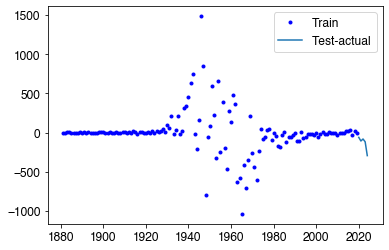

Bart: train 0.906 (121)
Barton: train 0.881 (122)
Basil: train 0.819 (123)
Beau: train 0.963 (124)
Beckett: train 0.956 (125)
Beckham: train 0.973 (126)
Ben: train 0.846 (127)
Benedict: train 0.858 (128)
Benito: train 0.871 (129)
Benjamin: train 0.970 (130)
Bennett: train 0.975 (131)
Bennie: train 0.844 (132)
Benny: train 0.890 (133)
Benson: train 0.918 (134)
Bentley: train 0.988 (135)
Benton: train 0.901 (136)
Bernard: train 0.895 (137)
Bernardo: train 0.904 (138)
Bernie: train 0.801 (139)
Bert: train 0.841 (140)


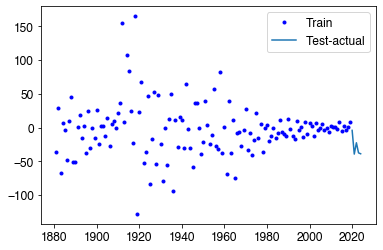

Bertram: train 0.833 (141)
Bill: train 0.963 (142)
Billie: train 0.877 (143)
Billy: train 0.899 (144)
Blaine: train 0.907 (145)
Blair: train 0.903 (146)
Blaise: train 0.925 (147)
Blake: train 0.989 (148)
Blaze: train 0.946 (149)
Bo: train 0.933 (150)
Bob: train 0.967 (151)
Bobbie: train 0.896 (152)
Bobby: train 0.936 (153)
Bodhi: train 0.964 (154)
Booker: train 0.820 (155)
Boston: train 0.955 (156)
Bowen: train 0.951 (157)
Boyd: train 0.826 (158)
Brad: train 0.933 (159)
Braden: train 0.965 (160)


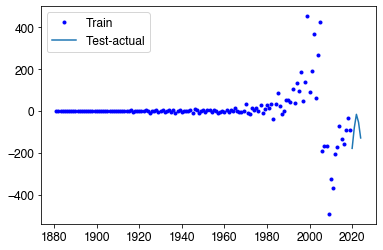

Bradford: train 0.897 (161)
Bradley: train 0.975 (162)
Bradly: train 0.928 (163)
Brady: train 0.973 (164)
Braeden: train 0.989 (165)
Braiden: train 0.983 (166)
Brandan: train 0.905 (167)
Branden: train 0.964 (168)
Brandon: train 0.991 (169)
Brandt: train 0.914 (170)
Branson: train 0.931 (171)
Brant: train 0.951 (172)
Brantley: train 0.965 (173)
Braxton: train 0.938 (174)
Brayan: train 0.974 (175)
Brayden: train 0.994 (176)
Braydon: train 0.983 (177)
Braylen: train 0.965 (178)
Braylon: train 0.960 (179)
Brendan: train 0.948 (180)


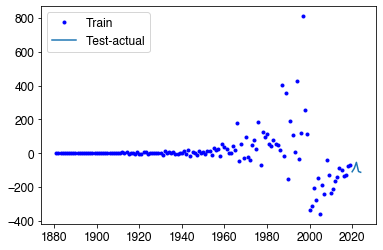

Brenden: train 0.975 (181)
Brendon: train 0.956 (182)
Brennan: train 0.961 (183)
Brennen: train 0.948 (184)
Brent: train 0.965 (185)
Brenton: train 0.829 (186)
Bret: train 0.938 (187)
Brett: train 0.965 (188)
Brian: train 0.975 (189)
Brice: train 0.943 (190)
Britton: train 0.898 (191)
Brock: train 0.933 (192)
Broderick: train 0.908 (193)
Brodie: train 0.968 (194)
Brody: train 0.983 (195)
Bronson: train 0.916 (196)
Brooks: train 0.982 (197)
Bruce: train 0.964 (198)
Bruno: train 0.908 (199)
Bryan: train 0.980 (200)


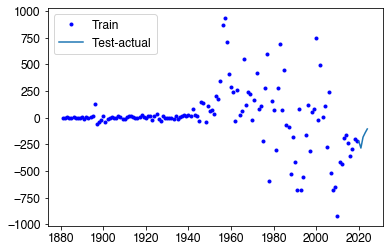

Bryant: train 0.949 (201)
Bryce: train 0.973 (202)
Brycen: train 0.982 (203)
Bryon: train 0.934 (204)
Bryson: train 0.928 (205)
Bud: train 0.803 (206)
Buddy: train 0.843 (207)
Buford: train 0.879 (208)
Burl: train 0.863 (209)
Burt: train 0.820 (210)
Burton: train 0.860 (211)
Buster: train 0.818 (212)
Byron: train 0.902 (213)
Cade: train 0.971 (214)
Caden: train 0.994 (215)
Caiden: train 0.989 (216)
Cain: train 0.915 (217)
Cale: train 0.950 (218)
Caleb: train 0.972 (219)
Callen: train 0.961 (220)


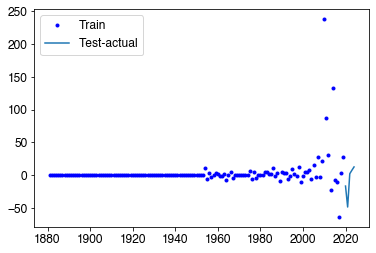

Callum: train 0.981 (221)
Calvin: train 0.927 (222)
Camden: train 0.978 (223)
Cameron: train 0.990 (224)
Camilo: train 0.910 (225)
Camren: train 0.983 (226)
Camron: train 0.960 (227)
Cannon: train 0.935 (228)
Carey: train 0.856 (229)
Carl: train 0.912 (230)
Carlo: train 0.880 (231)
Carlos: train 0.967 (232)
Carlton: train 0.881 (233)
Carmelo: train 0.948 (234)
Carmen: train 0.906 (235)
Carmine: train 0.912 (236)
Carol: train 0.801 (237)
Carrol: train 0.763 (238)
Carroll: train 0.865 (239)
Carson: train 0.975 (240)


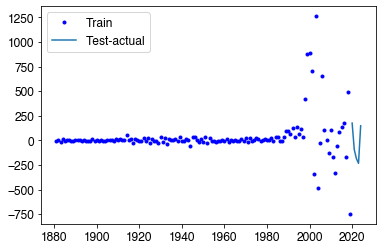

Carter: train 0.979 (241)
Cary: train 0.801 (242)
Case: train 0.942 (243)
Casey: train 0.971 (244)
Cash: train 0.965 (245)
Cason: train 0.967 (246)
Cassius: train 0.949 (247)
Cayden: train 0.979 (248)
Cecil: train 0.883 (249)
Cedric: train 0.919 (250)
Cedrick: train 0.906 (251)
Cesar: train 0.965 (252)
Chad: train 0.997 (253)
Chadwick: train 0.966 (254)
Chaim: train 0.924 (255)
Chance: train 0.935 (256)
Chandler: train 0.974 (257)
Channing: train 0.966 (258)
Charles: train 0.910 (259)
Charley: train 0.823 (260)


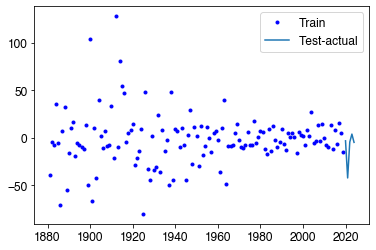

Charlie: train 0.897 (261)
Chase: train 0.967 (262)
Chauncey: train 0.889 (263)
Chaz: train 0.942 (264)
Chester: train 0.870 (265)
Chet: train 0.937 (266)
Chris: train 0.989 (267)
Christian: train 0.988 (268)
Christopher: train 0.987 (269)
Chuck: train 0.975 (270)
Clair: train 0.772 (271)
Clarence: train 0.894 (272)
Clark: train 0.880 (273)
Claud: train 0.818 (274)
Claude: train 0.849 (275)
Clay: train 0.960 (276)
Clayton: train 0.943 (277)
Clement: train 0.895 (278)
Cleo: train 0.828 (279)
Cletus: train 0.803 (280)


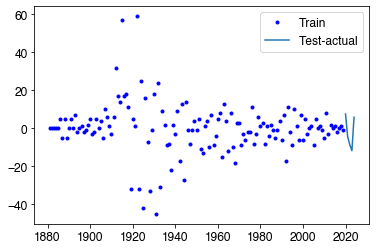

Cleveland: train 0.891 (281)
Cliff: train 0.897 (282)
Clifford: train 0.874 (283)
Clifton: train 0.914 (284)
Clint: train 0.944 (285)
Clinton: train 0.957 (286)
Clyde: train 0.863 (287)
Coby: train 0.960 (288)
Cody: train 0.990 (289)
Cohen: train 0.945 (290)
Colby: train 0.963 (291)
Cole: train 0.969 (292)
Coleman: train 0.887 (293)
Colin: train 0.975 (294)
Collin: train 0.961 (295)
Colt: train 0.963 (296)
Colten: train 0.965 (297)
Colton: train 0.970 (298)
Columbus: train 0.898 (299)
Conner: train 0.980 (300)


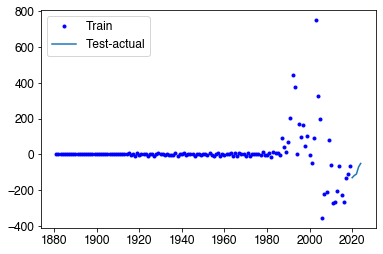

Connie: train 0.790 (301)
Connor: train 0.985 (302)
Conor: train 0.953 (303)
Conrad: train 0.868 (304)
Cooper: train 0.971 (305)
Corbin: train 0.974 (306)
Cordell: train 0.947 (307)
Corey: train 0.986 (308)
Cornelius: train 0.899 (309)
Cornell: train 0.875 (310)
Cortez: train 0.928 (311)
Cory: train 0.984 (312)
Coty: train 0.974 (313)
Courtney: train 0.932 (314)
Coy: train 0.832 (315)
Craig: train 0.969 (316)
Cristian: train 0.976 (317)
Cristobal: train 0.925 (318)
Cristopher: train 0.962 (319)
Cruz: train 0.962 (320)


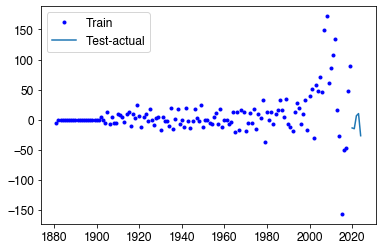

Cullen: train 0.934 (321)
Curt: train 0.910 (322)
Curtis: train 0.938 (323)
Cyril: train 0.844 (324)
Cyrus: train 0.907 (325)
Dakota: train 0.979 (326)
Dale: train 0.932 (327)
Dallas: train 0.943 (328)
Dalton: train 0.973 (329)
Damian: train 0.986 (330)
Damien: train 0.981 (331)
Damion: train 0.962 (332)
Damon: train 0.969 (333)
Dan: train 0.934 (334)
Dana: train 0.918 (335)
Dandre: train 0.940 (336)
Dane: train 0.928 (337)
Dangelo: train 0.950 (338)
Danial: train 0.897 (339)
Daniel: train 0.974 (340)


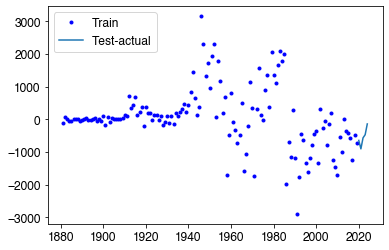

Dannie: train 0.838 (341)
Danny: train 0.953 (342)
Dante: train 0.931 (343)
Daquan: train 0.970 (344)
Daren: train 0.961 (345)
Darian: train 0.981 (346)
Darien: train 0.980 (347)
Darin: train 0.970 (348)
Dario: train 0.943 (349)
Darion: train 0.969 (350)
Darius: train 0.956 (351)
Darnell: train 0.924 (352)
Daron: train 0.972 (353)
Darrel: train 0.857 (354)
Darrell: train 0.932 (355)
Darren: train 0.964 (356)
Darrick: train 0.969 (357)
Darrin: train 0.969 (358)
Darrius: train 0.952 (359)
Darron: train 0.954 (360)


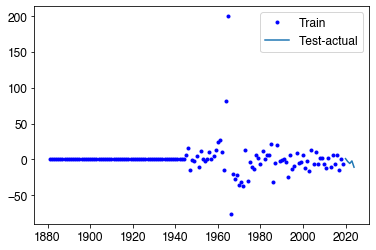

Darryl: train 0.948 (361)
Darwin: train 0.839 (362)
Daryl: train 0.901 (363)
Dashawn: train 0.953 (364)
Dave: train 0.977 (365)
Davian: train 0.960 (366)
David: train 0.965 (367)
Davin: train 0.976 (368)
Davion: train 0.964 (369)
Davis: train 0.883 (370)
Davon: train 0.956 (371)
Dawson: train 0.967 (372)
Dax: train 0.969 (373)
Daxton: train 0.979 (374)
Dayton: train 0.947 (375)
Deacon: train 0.973 (376)
Dean: train 0.931 (377)
Deandre: train 0.942 (378)
Deangelo: train 0.940 (379)
Declan: train 0.961 (380)


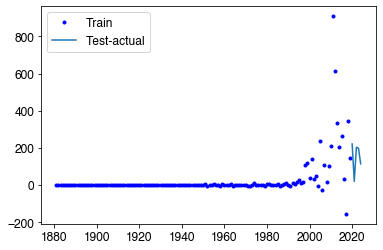

Dee: train 0.798 (381)
Deion: train 0.970 (382)
Dejuan: train 0.913 (383)
Delbert: train 0.872 (384)
Delmar: train 0.881 (385)
Delmer: train 0.808 (386)
Demarco: train 0.935 (387)
Demarcus: train 0.970 (388)
Demario: train 0.943 (389)
Demetrius: train 0.928 (390)
Demond: train 0.957 (391)
Denis: train 0.818 (392)
Dennis: train 0.901 (393)
Denny: train 0.906 (394)
Denver: train 0.834 (395)
Denzel: train 0.962 (396)
Deon: train 0.943 (397)
Deonte: train 0.949 (398)
Dereck: train 0.947 (399)
Derek: train 0.968 (400)


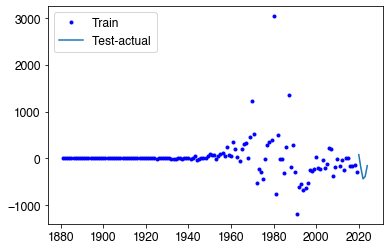

Derick: train 0.972 (401)
Derik: train 0.924 (402)
Deron: train 0.940 (403)
Derrick: train 0.963 (404)
Deshaun: train 0.955 (405)
Deshawn: train 0.980 (406)
Desmond: train 0.935 (407)
Destin: train 0.952 (408)
Devan: train 0.969 (409)
Devante: train 0.922 (410)
Deven: train 0.976 (411)
Devin: train 0.980 (412)
Devon: train 0.980 (413)
Devonte: train 0.935 (414)
Devyn: train 0.971 (415)
Dewayne: train 0.867 (416)
Dewey: train 0.938 (417)
Dexter: train 0.862 (418)
Dick: train 0.906 (419)
Diego: train 0.982 (420)


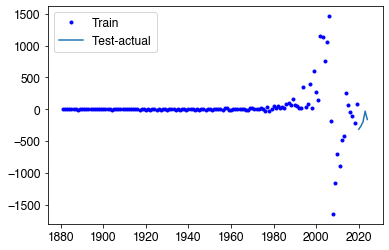

Dillan: train 0.976 (421)
Dillon: train 0.977 (422)
Dimitri: train 0.943 (423)
Dino: train 0.918 (424)
Dion: train 0.901 (425)
Dirk: train 0.781 (426)
Domenic: train 0.872 (427)
Domingo: train 0.867 (428)
Dominic: train 0.985 (429)
Dominick: train 0.970 (430)
Dominik: train 0.981 (431)
Dominique: train 0.975 (432)
Don: train 0.951 (433)
Donald: train 0.940 (434)
Donavan: train 0.942 (435)
Donn: train 0.780 (436)
Donnell: train 0.879 (437)
Donnie: train 0.927 (438)
Donny: train 0.873 (439)
Donovan: train 0.954 (440)


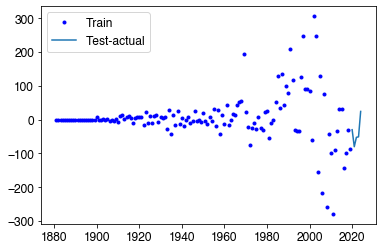

Dontae: train 0.919 (441)
Donte: train 0.944 (442)
Dorian: train 0.931 (443)
Doug: train 0.972 (444)
Douglas: train 0.903 (445)
Doyle: train 0.835 (446)
Drake: train 0.978 (447)
Draven: train 0.960 (448)
Drew: train 0.945 (449)
Duane: train 0.927 (450)
Dudley: train 0.859 (451)
Duke: train 0.955 (452)
Duncan: train 0.921 (453)
Dustin: train 0.977 (454)
Dusty: train 0.967 (455)
Dwain: train 0.866 (456)
Dwayne: train 0.951 (457)
Dwight: train 0.900 (458)
Dylan: train 0.976 (459)
Ean: train 0.953 (460)


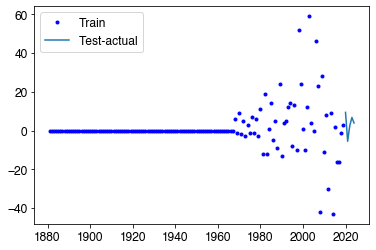

Earl: train 0.899 (461)
Earle: train 0.856 (462)
Earnest: train 0.840 (463)
Easton: train 0.987 (464)
Ed: train 0.970 (465)
Eddie: train 0.904 (466)
Eddy: train 0.895 (467)
Eden: train 0.968 (468)
Edgar: train 0.903 (469)
Edgardo: train 0.911 (470)
Edison: train 0.913 (471)
Edmond: train 0.856 (472)
Edmund: train 0.873 (473)
Eduardo: train 0.944 (474)
Edward: train 0.919 (475)
Edwardo: train 0.858 (476)
Edwin: train 0.916 (477)
Efrain: train 0.929 (478)
Efren: train 0.920 (479)
Elbert: train 0.834 (480)


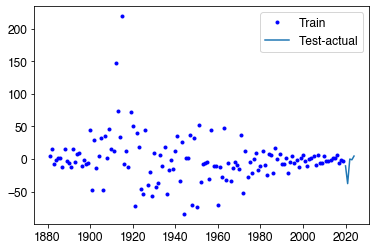

Eldon: train 0.841 (481)
Eli: train 0.983 (482)
Elian: train 0.955 (483)
Elias: train 0.986 (484)
Eliezer: train 0.868 (485)
Elijah: train 0.980 (486)
Eliot: train 0.896 (487)
Eliseo: train 0.899 (488)
Elisha: train 0.932 (489)
Elliot: train 0.937 (490)
Elliott: train 0.959 (491)
Ellis: train 0.884 (492)
Ellsworth: train 0.838 (493)
Elmer: train 0.892 (494)
Elmo: train 0.832 (495)
Eloy: train 0.868 (496)
Elroy: train 0.823 (497)
Elton: train 0.851 (498)
Elvin: train 0.868 (499)
Elvis: train 0.896 (500)


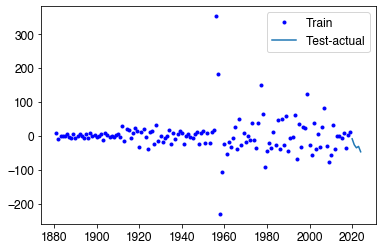

Elwood: train 0.881 (501)
Emanuel: train 0.952 (502)
Emerson: train 0.938 (503)
Emery: train 0.877 (504)
Emil: train 0.880 (505)
Emiliano: train 0.958 (506)
Emilio: train 0.916 (507)
Emmanuel: train 0.947 (508)
Emmett: train 0.976 (509)
Emmitt: train 0.913 (510)
Emory: train 0.792 (511)
Enoch: train 0.891 (512)
Enrique: train 0.961 (513)
Enzo: train 0.976 (514)
Ephraim: train 0.888 (515)
Eric: train 0.981 (516)
Erich: train 0.900 (517)
Erick: train 0.941 (518)
Erik: train 0.954 (519)
Erin: train 0.941 (520)


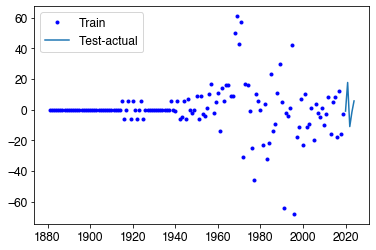

Ernest: train 0.883 (521)
Ernesto: train 0.896 (522)
Ernie: train 0.856 (523)
Errol: train 0.832 (524)
Ervin: train 0.871 (525)
Erwin: train 0.878 (526)
Esteban: train 0.922 (527)
Estevan: train 0.949 (528)
Ethan: train 0.979 (529)
Eugene: train 0.901 (530)
Evan: train 0.982 (531)
Everett: train 0.941 (532)
Everette: train 0.818 (533)
Ezekiel: train 0.963 (534)
Ezequiel: train 0.946 (535)
Ezra: train 0.990 (536)
Fabian: train 0.956 (537)
Federico: train 0.834 (538)
Felipe: train 0.911 (539)
Felix: train 0.927 (540)


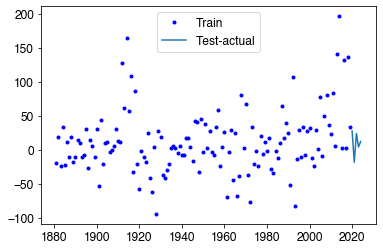

Ferdinand: train 0.773 (541)
Fernando: train 0.956 (542)
Fidel: train 0.867 (543)
Finley: train 0.964 (544)
Finn: train 0.958 (545)
Finnegan: train 0.966 (546)
Fletcher: train 0.888 (547)
Floyd: train 0.899 (548)
Forest: train 0.898 (549)
Forrest: train 0.950 (550)
Foster: train 0.939 (551)
Francesco: train 0.944 (552)
Francis: train 0.892 (553)
Francisco: train 0.923 (554)
Franco: train 0.931 (555)
Frank: train 0.888 (556)
Frankie: train 0.851 (557)
Franklin: train 0.864 (558)
Fred: train 0.906 (559)
Freddie: train 0.878 (560)


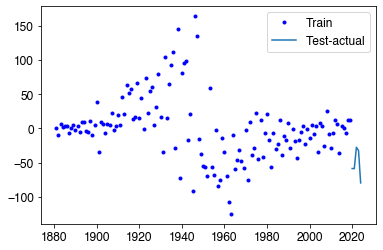

Freddy: train 0.915 (561)
Frederic: train 0.889 (562)
Frederick: train 0.912 (563)
Fredric: train 0.794 (564)
Fredrick: train 0.912 (565)
Freeman: train 0.894 (566)
Gabriel: train 0.985 (567)
Gael: train 0.917 (568)
Gage: train 0.979 (569)
Gail: train 0.740 (570)
Gale: train 0.804 (571)
Galen: train 0.834 (572)
Gannon: train 0.953 (573)
Garland: train 0.803 (574)
Garret: train 0.973 (575)
Garrett: train 0.986 (576)
Garrick: train 0.898 (577)
Garrison: train 0.947 (578)
Garry: train 0.948 (579)
Garth: train 0.882 (580)


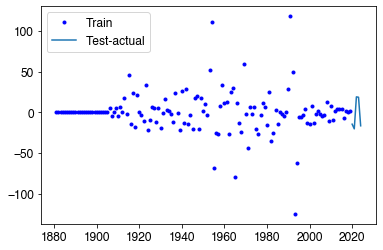

Gary: train 0.924 (581)
Gavin: train 0.992 (582)
Genaro: train 0.859 (583)
Gene: train 0.847 (584)
Geoffrey: train 0.924 (585)
George: train 0.903 (586)
Gerald: train 0.905 (587)
Gerard: train 0.928 (588)
Gerardo: train 0.947 (589)
German: train 0.909 (590)
Gerry: train 0.867 (591)
Giancarlo: train 0.965 (592)
Gianni: train 0.928 (593)
Gideon: train 0.974 (594)
Gilbert: train 0.880 (595)
Gilberto: train 0.929 (596)
Gino: train 0.899 (597)
Giovani: train 0.978 (598)
Giovanni: train 0.973 (599)
Giovanny: train 0.976 (600)


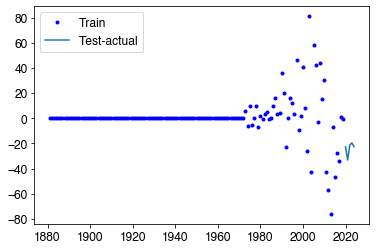

Giuseppe: train 0.941 (601)
Glen: train 0.934 (602)
Glenn: train 0.935 (603)
Gonzalo: train 0.908 (604)
Gordon: train 0.869 (605)
Grady: train 0.940 (606)
Graham: train 0.959 (607)
Grant: train 0.957 (608)
Grayson: train 0.969 (609)
Greg: train 0.983 (610)
Gregg: train 0.966 (611)
Gregorio: train 0.893 (612)
Gregory: train 0.980 (613)
Greyson: train 0.981 (614)
Griffin: train 0.967 (615)
Grover: train 0.974 (616)
Guadalupe: train 0.870 (617)
Guillermo: train 0.928 (618)
Gunnar: train 0.958 (619)
Gunner: train 0.980 (620)


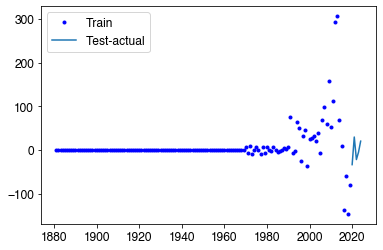

Gus: train 0.851 (621)
Gustavo: train 0.925 (622)
Guy: train 0.912 (623)
Hakeem: train 0.919 (624)
Hal: train 0.870 (625)
Hamza: train 0.940 (626)
Hank: train 0.945 (627)
Hans: train 0.902 (628)
Harlan: train 0.855 (629)
Harley: train 0.931 (630)
Harold: train 0.905 (631)
Harper: train 0.963 (632)
Harris: train 0.897 (633)
Harrison: train 0.959 (634)
Harry: train 0.903 (635)
Harvey: train 0.896 (636)
Hassan: train 0.928 (637)
Hayden: train 0.972 (638)
Hayes: train 0.975 (639)
Heath: train 0.953 (640)


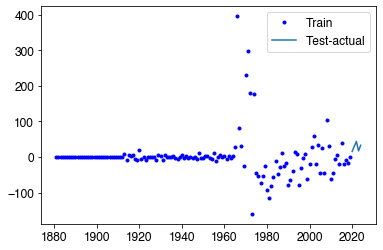

Hector: train 0.921 (641)
Hendrix: train 0.983 (642)
Henry: train 0.905 (643)
Herbert: train 0.875 (644)
Heriberto: train 0.928 (645)
Herman: train 0.858 (646)
Herschel: train 0.835 (647)
Hershel: train 0.811 (648)
Hezekiah: train 0.934 (649)
Hiram: train 0.809 (650)
Holden: train 0.965 (651)
Hollis: train 0.863 (652)
Homer: train 0.906 (653)
Horace: train 0.867 (654)
Houston: train 0.885 (655)
Howard: train 0.894 (656)
Hoyt: train 0.829 (657)
Hubert: train 0.885 (658)
Hudson: train 0.956 (659)
Huey: train 0.770 (660)


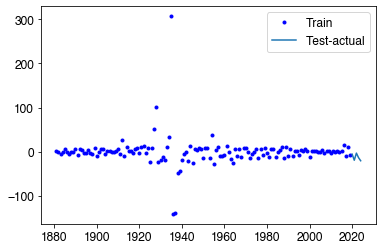

Hugh: train 0.886 (661)
Hugo: train 0.948 (662)
Humberto: train 0.875 (663)
Hunter: train 0.990 (664)
Ian: train 0.963 (665)
Ibrahim: train 0.940 (666)
Ignacio: train 0.926 (667)
Iker: train 0.945 (668)
Immanuel: train 0.935 (669)
Ira: train 0.869 (670)
Irvin: train 0.883 (671)
Irving: train 0.895 (672)
Irwin: train 0.865 (673)
Isaac: train 0.969 (674)
Isai: train 0.959 (675)
Isaiah: train 0.989 (676)
Isaias: train 0.936 (677)
Ishmael: train 0.924 (678)
Isiah: train 0.952 (679)
Isidro: train 0.864 (680)


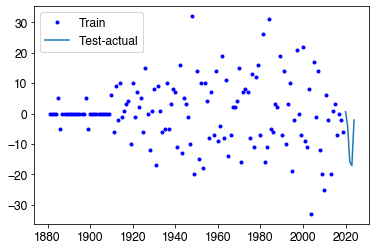

Ismael: train 0.938 (681)
Israel: train 0.960 (682)
Issac: train 0.968 (683)
Ivan: train 0.943 (684)
Ivory: train 0.843 (685)
Izaiah: train 0.965 (686)
Jabari: train 0.967 (687)
Jace: train 0.986 (688)
Jack: train 0.927 (689)
Jackie: train 0.881 (690)
Jackson: train 0.991 (691)
Jacky: train 0.871 (692)
Jacob: train 0.980 (693)
Jacoby: train 0.969 (694)
Jacques: train 0.873 (695)
Jade: train 0.954 (696)
Jaden: train 0.963 (697)
Jadon: train 0.982 (698)
Jagger: train 0.939 (699)
Jaiden: train 0.992 (700)


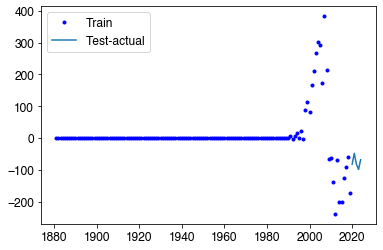

Jaime: train 0.953 (701)
Jair: train 0.949 (702)
Jairo: train 0.960 (703)
Jake: train 0.978 (704)
Jakob: train 0.972 (705)
Jalen: train 0.969 (706)
Jamaal: train 0.897 (707)
Jamal: train 0.974 (708)
Jamar: train 0.960 (709)
Jamarcus: train 0.941 (710)
Jamari: train 0.985 (711)
Jamarion: train 0.977 (712)
Jamel: train 0.929 (713)
James: train 0.926 (714)
Jameson: train 0.991 (715)
Jamey: train 0.941 (716)
Jamie: train 0.961 (717)
Jamil: train 0.950 (718)
Jamir: train 0.934 (719)
Jamison: train 0.933 (720)


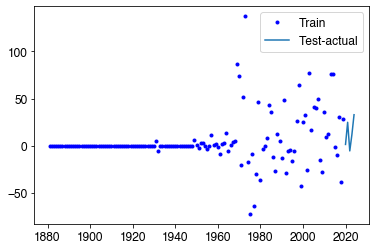

Jan: train 0.794 (721)
Jaquan: train 0.952 (722)
Jared: train 0.985 (723)
Jarod: train 0.969 (724)
Jaron: train 0.958 (725)
Jarred: train 0.971 (726)
Jarrett: train 0.969 (727)
Jarrod: train 0.951 (728)
Jarvis: train 0.897 (729)
Jase: train 0.978 (730)
Jasiah: train 0.974 (731)
Jason: train 0.988 (732)
Jasper: train 0.956 (733)
Javier: train 0.953 (734)
Javion: train 0.964 (735)
Javon: train 0.956 (736)
Jax: train 0.977 (737)
Jaxon: train 0.983 (738)
Jaxson: train 0.986 (739)
Jaxton: train 0.986 (740)


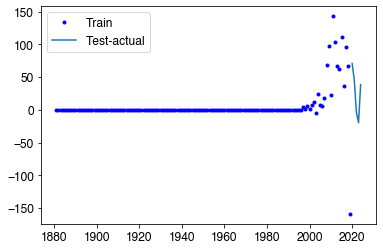

Jay: train 0.900 (741)
Jayce: train 0.980 (742)
Jayceon: train 0.981 (743)
Jayden: train 0.983 (744)
Jaydon: train 0.982 (745)
Jaylen: train 0.962 (746)
Jaylin: train 0.976 (747)
Jaylon: train 0.971 (748)
Jayson: train 0.969 (749)
Jean: train 0.906 (750)
Jed: train 0.897 (751)
Jedidiah: train 0.951 (752)
Jeff: train 0.978 (753)
Jefferson: train 0.864 (754)
Jeffery: train 0.957 (755)
Jeffrey: train 0.977 (756)
Jeffry: train 0.945 (757)
Jensen: train 0.972 (758)
Jerald: train 0.863 (759)
Jeremiah: train 0.980 (760)


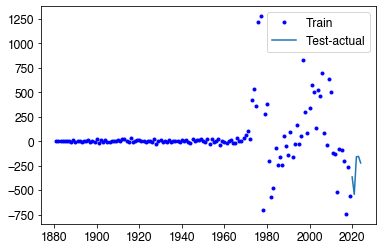

Jeremy: train 0.995 (761)
Jermaine: train 0.969 (762)
Jerod: train 0.907 (763)
Jerold: train 0.861 (764)
Jerome: train 0.884 (765)
Jerrell: train 0.892 (766)
Jerrod: train 0.941 (767)
Jerrold: train 0.890 (768)
Jerry: train 0.890 (769)
Jess: train 0.823 (770)
Jesse: train 0.974 (771)
Jessie: train 0.899 (772)
Jesus: train 0.976 (773)
Jett: train 0.971 (774)
Jim: train 0.979 (775)
Jimmie: train 0.895 (776)
Jimmy: train 0.895 (777)
Joan: train 0.913 (778)
Joaquin: train 0.938 (779)
Jody: train 0.955 (780)


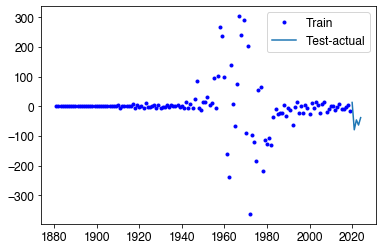

Joe: train 0.906 (781)
Joel: train 0.942 (782)
Joesph: train 0.869 (783)
Joey: train 0.940 (784)
Johan: train 0.931 (785)
John: train 0.915 (786)
Johnathan: train 0.972 (787)
Johnathon: train 0.961 (788)
Johnie: train 0.835 (789)
Johnnie: train 0.886 (790)
Johnny: train 0.887 (791)
Johnpaul: train 0.928 (792)
Jon: train 0.933 (793)
Jonah: train 0.962 (794)
Jonas: train 0.956 (795)
Jonathan: train 0.988 (796)
Jonathon: train 0.977 (797)
Jordan: train 0.936 (798)
Jorden: train 0.966 (799)
Jordon: train 0.931 (800)


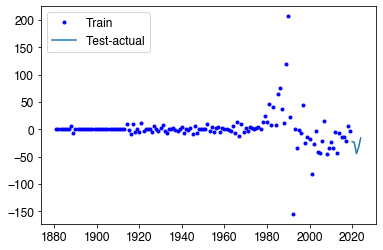

Jordy: train 0.946 (801)
Jordyn: train 0.951 (802)
Jorge: train 0.970 (803)
Jose: train 0.969 (804)
Josef: train 0.890 (805)
Joseph: train 0.926 (806)
Josh: train 0.938 (807)
Joshua: train 0.982 (808)
Josiah: train 0.976 (809)
Josue: train 0.979 (810)
Jovan: train 0.950 (811)
Jovani: train 0.960 (812)
Jovanni: train 0.943 (813)
Juan: train 0.971 (814)
Judah: train 0.978 (815)
Jude: train 0.983 (816)
Judson: train 0.858 (817)
Julian: train 0.969 (818)
Julien: train 0.952 (819)
Julio: train 0.942 (820)


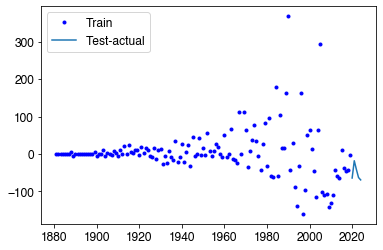

Julius: train 0.884 (821)
Junior: train 0.889 (822)
Justice: train 0.969 (823)
Justin: train 0.980 (824)
Justus: train 0.940 (825)
Kade: train 0.934 (826)
Kaden: train 0.988 (827)
Kai: train 0.969 (828)
Kaiden: train 0.988 (829)
Kale: train 0.983 (830)
Kaleb: train 0.980 (831)
Kalvin: train 0.931 (832)
Kamari: train 0.987 (833)
Kamden: train 0.981 (834)
Kameron: train 0.967 (835)
Kamron: train 0.973 (836)
Kane: train 0.969 (837)
Kareem: train 0.954 (838)
Karim: train 0.940 (839)
Karl: train 0.932 (840)


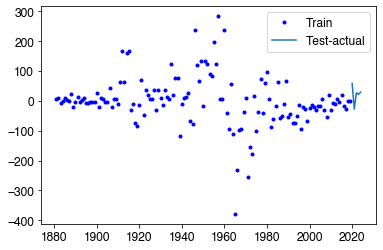

Karson: train 0.939 (841)
Karter: train 0.959 (842)
Kasen: train 0.983 (843)
Kasey: train 0.919 (844)
Kash: train 0.982 (845)
Kason: train 0.961 (846)
Kayden: train 0.992 (847)
Kayson: train 0.956 (848)
Keagan: train 0.975 (849)
Keanu: train 0.963 (850)
Keaton: train 0.971 (851)
Keegan: train 0.974 (852)
Keenan: train 0.950 (853)
Keith: train 0.953 (854)
Kellan: train 0.953 (855)
Kellen: train 0.974 (856)
Kelly: train 0.961 (857)
Kelton: train 0.952 (858)
Kelvin: train 0.945 (859)
Ken: train 0.967 (860)


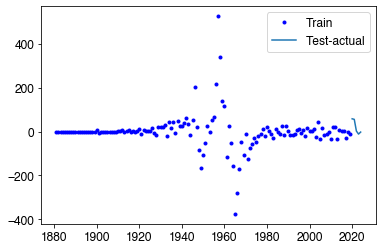

Kendall: train 0.949 (861)
Kendrick: train 0.972 (862)
Kennedy: train 0.899 (863)
Kenneth: train 0.924 (864)
Kennith: train 0.855 (865)
Kenny: train 0.969 (866)
Kent: train 0.919 (867)
Kenton: train 0.879 (868)
Kenyon: train 0.928 (869)
Keon: train 0.948 (870)
Kermit: train 0.800 (871)
Kerry: train 0.854 (872)
Keshawn: train 0.961 (873)
Keven: train 0.905 (874)
Kevin: train 0.958 (875)
Kevon: train 0.955 (876)
Keyon: train 0.951 (877)
Khalid: train 0.943 (878)
Khalil: train 0.924 (879)
Kian: train 0.970 (880)


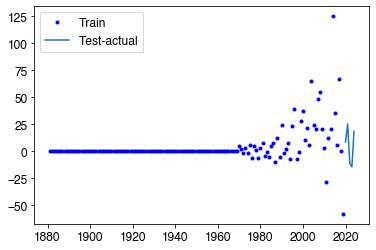

Kieran: train 0.954 (881)
Killian: train 0.944 (882)
Kim: train 0.910 (883)
King: train 0.974 (884)
Kingston: train 0.963 (885)
Kip: train 0.938 (886)
Kirby: train 0.908 (887)
Kirk: train 0.919 (888)
Knox: train 0.974 (889)
Kobe: train 0.965 (890)
Koby: train 0.978 (891)
Kody: train 0.983 (892)
Kolby: train 0.974 (893)
Kole: train 0.960 (894)
Kolton: train 0.955 (895)
Konner: train 0.961 (896)
Konnor: train 0.971 (897)
Korbin: train 0.965 (898)
Korey: train 0.954 (899)
Kory: train 0.965 (900)


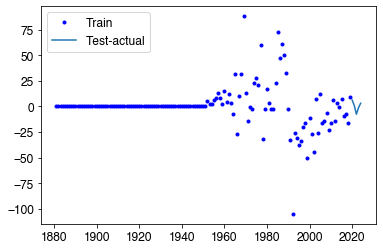

Kraig: train 0.891 (901)
Kris: train 0.944 (902)
Kristian: train 0.955 (903)
Kristofer: train 0.945 (904)
Kristopher: train 0.969 (905)
Kurt: train 0.923 (906)
Kurtis: train 0.940 (907)
Kylan: train 0.949 (908)
Kyle: train 0.978 (909)
Kyler: train 0.966 (910)
Kyree: train 0.952 (911)
Kyrie: train 0.983 (912)
Kyson: train 0.961 (913)
Lamar: train 0.933 (914)
Lamont: train 0.961 (915)
Lance: train 0.959 (916)
Landen: train 0.987 (917)
Landon: train 0.981 (918)
Landyn: train 0.984 (919)
Lane: train 0.959 (920)


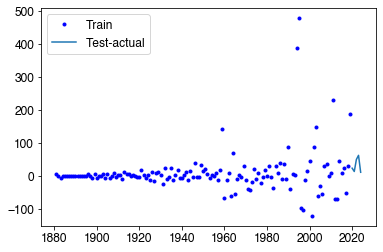

Langston: train 0.934 (921)
Lanny: train 0.828 (922)
Larry: train 0.932 (923)
Lars: train 0.883 (924)
Laurence: train 0.911 (925)
Lavern: train 0.814 (926)
Laverne: train 0.877 (927)
Lawrence: train 0.918 (928)
Lawson: train 0.951 (929)
Layne: train 0.905 (930)
Layton: train 0.942 (931)
Lazaro: train 0.920 (932)
Leandro: train 0.948 (933)
Lee: train 0.890 (934)
Legend: train 0.994 (935)
Leif: train 0.905 (936)
Leighton: train 0.938 (937)
Leland: train 0.939 (938)
Lemuel: train 0.864 (939)
Lenard: train 0.799 (940)


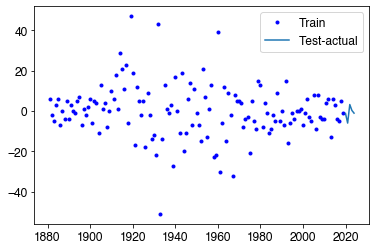

Lennon: train 0.953 (941)
Lennox: train 0.990 (942)
Lenny: train 0.922 (943)
Leo: train 0.939 (944)
Leon: train 0.914 (945)
Leonard: train 0.900 (946)
Leonardo: train 0.948 (947)
Leonel: train 0.949 (948)
Leonidas: train 0.944 (949)
Leroy: train 0.893 (950)
Leslie: train 0.886 (951)
Lester: train 0.879 (952)
Levi: train 0.980 (953)
Lewis: train 0.901 (954)
Liam: train 0.991 (955)
Lincoln: train 0.967 (956)
Lindsey: train 0.825 (957)
Linwood: train 0.857 (958)
Lionel: train 0.888 (959)
Lloyd: train 0.890 (960)


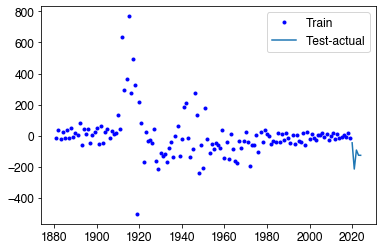

Logan: train 0.980 (961)
Lon: train 0.864 (962)
London: train 0.961 (963)
Lonnie: train 0.868 (964)
Lonny: train 0.823 (965)
Loren: train 0.863 (966)
Lorenzo: train 0.946 (967)
Louie: train 0.804 (968)
Louis: train 0.898 (969)
Lowell: train 0.850 (970)
Loyd: train 0.857 (971)
Luca: train 0.987 (972)
Lucas: train 0.976 (973)
Lucian: train 0.939 (974)
Luciano: train 0.917 (975)
Lucien: train 0.854 (976)
Luis: train 0.980 (977)
Luka: train 0.985 (978)
Lukas: train 0.929 (979)
Luke: train 0.973 (980)


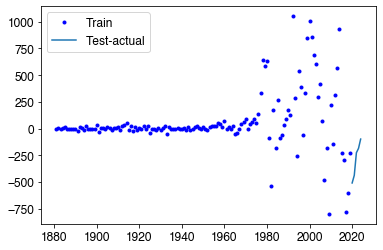

Luther: train 0.842 (981)
Lyle: train 0.846 (982)
Lyman: train 0.774 (983)
Lyndon: train 0.851 (984)
Lynn: train 0.871 (985)
Mac: train 0.859 (986)
Mack: train 0.861 (987)
Mackenzie: train 0.983 (988)
Madden: train 0.970 (989)
Maddox: train 0.982 (990)
Madison: train 0.913 (991)
Major: train 0.959 (992)
Makai: train 0.975 (993)
Malachi: train 0.977 (994)
Malakai: train 0.986 (995)
Malcolm: train 0.955 (996)
Malik: train 0.980 (997)
Manuel: train 0.929 (998)
Marc: train 0.970 (999)
Marcel: train 0.875 (1000)


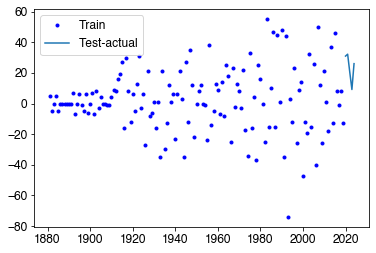

Marcelino: train 0.872 (1001)
Marcello: train 0.923 (1002)
Marcellus: train 0.875 (1003)
Marcelo: train 0.945 (1004)
Marco: train 0.938 (1005)
Marcos: train 0.975 (1006)
Marcus: train 0.982 (1007)
Mariano: train 0.923 (1008)
Mario: train 0.954 (1009)
Marion: train 0.868 (1010)
Mark: train 0.986 (1011)
Markus: train 0.904 (1012)
Marlin: train 0.785 (1013)
Marlon: train 0.936 (1014)
Marques: train 0.939 (1015)
Marquez: train 0.962 (1016)
Marquis: train 0.960 (1017)
Marquise: train 0.947 (1018)
Marshall: train 0.907 (1019)
Martin: train 0.899 (1020)


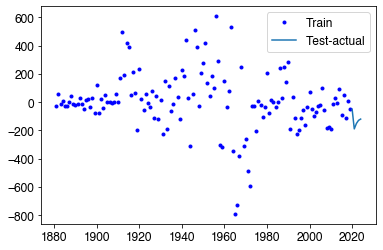

Marty: train 0.929 (1021)
Marvin: train 0.930 (1022)
Mary: train 0.859 (1023)
Mason: train 0.986 (1024)
Mateo: train 0.991 (1025)
Mathew: train 0.973 (1026)
Mathias: train 0.963 (1027)
Matias: train 0.965 (1028)
Matt: train 0.963 (1029)
Matteo: train 0.959 (1030)
Matthew: train 0.991 (1031)
Matthias: train 0.974 (1032)
Maurice: train 0.882 (1033)
Mauricio: train 0.939 (1034)
Mauro: train 0.918 (1035)
Maverick: train 0.982 (1036)
Max: train 0.911 (1037)
Maxim: train 0.948 (1038)
Maximilian: train 0.960 (1039)
Maximiliano: train 0.991 (1040)


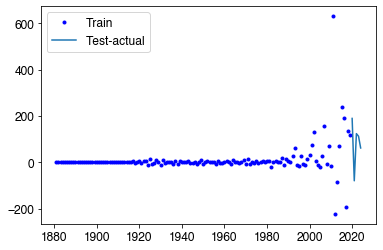

Maximillian: train 0.957 (1041)
Maximo: train 0.946 (1042)
Maximus: train 0.964 (1043)
Maxwell: train 0.977 (1044)
Maynard: train 0.835 (1045)
Mckinley: train 0.869 (1046)
Mekhi: train 0.973 (1047)
Melvin: train 0.917 (1048)
Memphis: train 0.961 (1049)
Menachem: train 0.923 (1050)
Merle: train 0.853 (1051)
Merlin: train 0.802 (1052)
Merrill: train 0.848 (1053)
Mervin: train 0.752 (1054)
Messiah: train 0.975 (1055)
Micah: train 0.968 (1056)
Michael: train 0.970 (1057)
Micheal: train 0.971 (1058)
Michel: train 0.873 (1059)
Mickey: train 0.851 (1060)


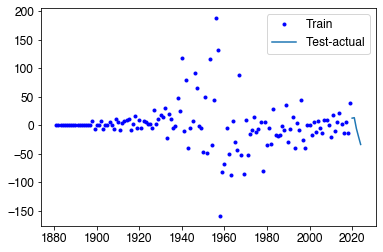

Miguel: train 0.974 (1061)
Mike: train 0.990 (1062)
Mikel: train 0.831 (1063)
Milan: train 0.957 (1064)
Miles: train 0.978 (1065)
Milford: train 0.881 (1066)
Millard: train 0.884 (1067)
Miller: train 0.902 (1068)
Milo: train 0.966 (1069)
Milton: train 0.875 (1070)
Misael: train 0.950 (1071)
Mitchel: train 0.939 (1072)
Mitchell: train 0.973 (1073)
Mohamed: train 0.973 (1074)
Mohammad: train 0.950 (1075)
Mohammed: train 0.968 (1076)
Moises: train 0.946 (1077)
Monroe: train 0.880 (1078)
Monte: train 0.834 (1079)
Monty: train 0.856 (1080)


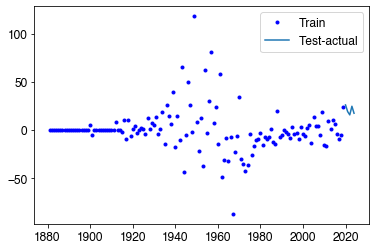

Mordechai: train 0.942 (1081)
Morgan: train 0.966 (1082)
Morris: train 0.864 (1083)
Morton: train 0.849 (1084)
Moses: train 0.892 (1085)
Moshe: train 0.916 (1086)
Muhammad: train 0.973 (1087)
Murray: train 0.873 (1088)
Mustafa: train 0.953 (1089)
Myles: train 0.971 (1090)
Myron: train 0.862 (1091)
Nash: train 0.969 (1092)
Nasir: train 0.955 (1093)
Nathan: train 0.982 (1094)
Nathanael: train 0.929 (1095)
Nathanial: train 0.947 (1096)
Nathaniel: train 0.956 (1097)
Nathen: train 0.937 (1098)
Neal: train 0.880 (1099)
Ned: train 0.890 (1100)


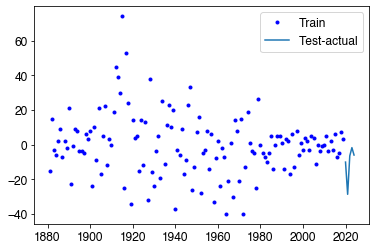

Nehemiah: train 0.963 (1101)
Neil: train 0.919 (1102)
Nelson: train 0.839 (1103)
Nestor: train 0.927 (1104)
Newton: train 0.842 (1105)
Nicholas: train 0.996 (1106)
Nick: train 0.924 (1107)
Nickolas: train 0.958 (1108)
Nicky: train 0.827 (1109)
Nico: train 0.922 (1110)
Nicolas: train 0.970 (1111)
Nigel: train 0.957 (1112)
Niko: train 0.974 (1113)
Nikolai: train 0.952 (1114)
Nikolas: train 0.954 (1115)
Nixon: train 0.975 (1116)
Noah: train 0.984 (1117)
Noe: train 0.890 (1118)
Noel: train 0.902 (1119)
Nolan: train 0.955 (1120)


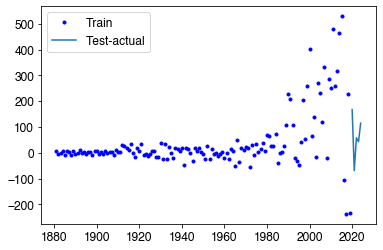

Norbert: train 0.882 (1121)
Norman: train 0.908 (1122)
Norris: train 0.875 (1123)
Oakley: train 0.965 (1124)
Octavio: train 0.931 (1125)
Odell: train 0.770 (1126)
Odin: train 0.978 (1127)
Odis: train 0.821 (1128)
Olen: train 0.874 (1129)
Olin: train 0.777 (1130)
Oliver: train 0.970 (1131)
Ollie: train 0.855 (1132)
Omar: train 0.965 (1133)
Omari: train 0.962 (1134)
Orion: train 0.950 (1135)
Orlando: train 0.911 (1136)
Orval: train 0.870 (1137)
Orville: train 0.891 (1138)
Oscar: train 0.934 (1139)
Osvaldo: train 0.943 (1140)


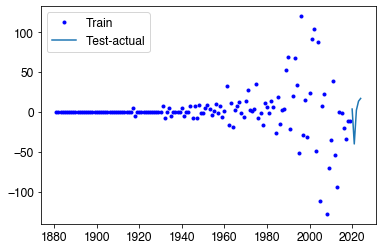

Oswaldo: train 0.950 (1141)
Otis: train 0.863 (1142)
Otto: train 0.882 (1143)
Owen: train 0.971 (1144)
Pablo: train 0.904 (1145)
Paris: train 0.886 (1146)
Parker: train 0.988 (1147)
Pasquale: train 0.809 (1148)
Pat: train 0.951 (1149)
Patrick: train 0.956 (1150)
Patsy: train 0.867 (1151)
Paul: train 0.954 (1152)
Paxton: train 0.929 (1153)
Payton: train 0.966 (1154)
Pedro: train 0.915 (1155)
Percy: train 0.838 (1156)
Perry: train 0.935 (1157)
Pete: train 0.887 (1158)
Peter: train 0.933 (1159)
Peyton: train 0.943 (1160)


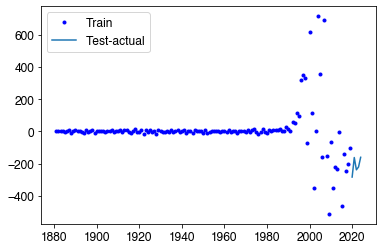

Phil: train 0.935 (1161)
Philip: train 0.936 (1162)
Phillip: train 0.964 (1163)
Phoenix: train 0.990 (1164)
Pierce: train 0.933 (1165)
Pierre: train 0.885 (1166)
Porter: train 0.966 (1167)
Preston: train 0.965 (1168)
Prince: train 0.947 (1169)
Princeton: train 0.953 (1170)
Quentin: train 0.938 (1171)
Quincy: train 0.974 (1172)
Quinn: train 0.933 (1173)
Quinten: train 0.958 (1174)
Quintin: train 0.946 (1175)
Quinton: train 0.959 (1176)
Rafael: train 0.881 (1177)
Raheem: train 0.959 (1178)
Raiden: train 0.940 (1179)
Raleigh: train 0.825 (1180)


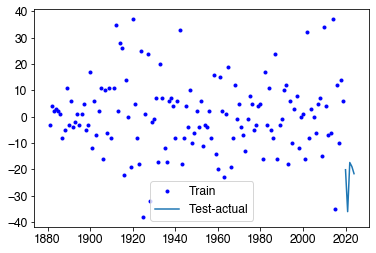

Ralph: train 0.903 (1181)
Ramiro: train 0.901 (1182)
Ramon: train 0.856 (1183)
Ramsey: train 0.898 (1184)
Randal: train 0.928 (1185)
Randall: train 0.964 (1186)
Randell: train 0.859 (1187)
Randolph: train 0.930 (1188)
Randy: train 0.973 (1189)
Raphael: train 0.926 (1190)
Rashad: train 0.943 (1191)
Rashawn: train 0.937 (1192)
Raul: train 0.942 (1193)
Ray: train 0.872 (1194)
Rayan: train 0.948 (1195)
Raymond: train 0.913 (1196)
Raymundo: train 0.898 (1197)
Reagan: train 0.953 (1198)
Reece: train 0.943 (1199)
Reed: train 0.954 (1200)


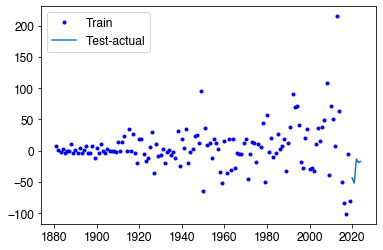

Reese: train 0.960 (1201)
Reggie: train 0.882 (1202)
Reginald: train 0.925 (1203)
Reid: train 0.960 (1204)
Remington: train 0.979 (1205)
Remy: train 0.970 (1206)
Rene: train 0.902 (1207)
Reuben: train 0.849 (1208)
Rex: train 0.837 (1209)
Rey: train 0.927 (1210)
Reynaldo: train 0.876 (1211)
Rhett: train 0.987 (1212)
Rhys: train 0.959 (1213)
Ricardo: train 0.955 (1214)
Richard: train 0.925 (1215)
Richie: train 0.910 (1216)
Rick: train 0.973 (1217)
Rickey: train 0.992 (1218)
Rickie: train 0.934 (1219)
Ricky: train 0.994 (1220)


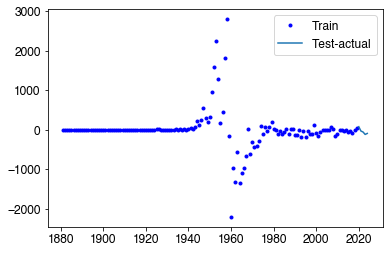

Rico: train 0.926 (1221)
Rigoberto: train 0.916 (1222)
Riley: train 0.969 (1223)
River: train 0.986 (1224)
Rob: train 0.964 (1225)
Robbie: train 0.942 (1226)
Robby: train 0.937 (1227)
Robert: train 0.934 (1228)
Roberto: train 0.955 (1229)
Robin: train 0.933 (1230)
Rocco: train 0.904 (1231)
Rocky: train 0.920 (1232)
Rod: train 0.931 (1233)
Roderick: train 0.914 (1234)
Rodger: train 0.844 (1235)
Rodney: train 0.991 (1236)
Rodolfo: train 0.935 (1237)
Rodrick: train 0.932 (1238)
Rodrigo: train 0.956 (1239)
Rogelio: train 0.882 (1240)


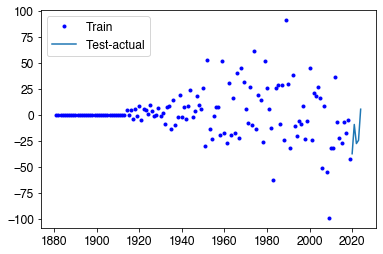

Roger: train 0.898 (1241)
Rogers: train 0.768 (1242)
Rohan: train 0.931 (1243)
Roland: train 0.865 (1244)
Rolando: train 0.902 (1245)
Rolland: train 0.785 (1246)
Roman: train 0.965 (1247)
Romeo: train 0.944 (1248)
Ron: train 0.969 (1249)
Ronald: train 0.916 (1250)
Ronaldo: train 0.954 (1251)
Ronan: train 0.982 (1252)
Ronin: train 0.948 (1253)
Ronnie: train 0.944 (1254)
Ronny: train 0.858 (1255)
Roosevelt: train 0.877 (1256)
Rory: train 0.903 (1257)
Roscoe: train 0.831 (1258)
Ross: train 0.928 (1259)
Rowan: train 0.988 (1260)


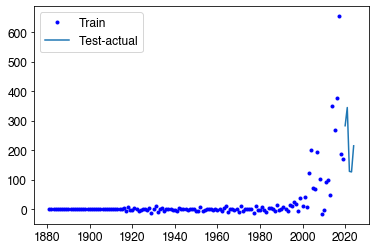

Roy: train 0.893 (1261)
Royal: train 0.889 (1262)
Royce: train 0.902 (1263)
Ruben: train 0.922 (1264)
Rudolph: train 0.830 (1265)
Rudy: train 0.835 (1266)
Rufus: train 0.860 (1267)
Russ: train 0.960 (1268)
Russel: train 0.889 (1269)
Russell: train 0.941 (1270)
Rusty: train 0.907 (1271)
Ryan: train 0.982 (1272)
Ryder: train 0.964 (1273)
Ryker: train 0.988 (1274)
Rylan: train 0.967 (1275)
Ryland: train 0.973 (1276)
Sage: train 0.950 (1277)
Salvador: train 0.932 (1278)
Salvatore: train 0.893 (1279)
Sam: train 0.896 (1280)


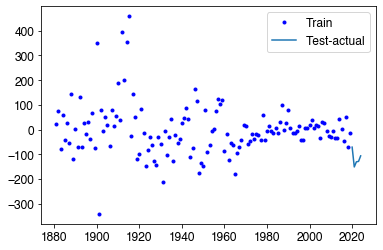

Samir: train 0.954 (1281)
Sammie: train 0.806 (1282)
Sammy: train 0.903 (1283)
Samson: train 0.925 (1284)
Samuel: train 0.937 (1285)
Sandy: train 0.821 (1286)
Sanford: train 0.827 (1287)
Santana: train 0.959 (1288)
Santiago: train 0.971 (1289)
Santino: train 0.942 (1290)
Santos: train 0.876 (1291)
Saul: train 0.953 (1292)
Sawyer: train 0.963 (1293)
Scot: train 0.924 (1294)
Scott: train 0.995 (1295)
Scottie: train 0.959 (1296)
Scotty: train 0.976 (1297)
Seamus: train 0.952 (1298)
Sean: train 0.973 (1299)
Sebastian: train 0.971 (1300)


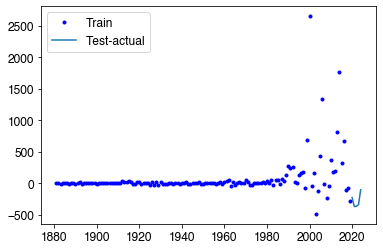

Semaj: train 0.941 (1301)
Sergio: train 0.943 (1302)
Seth: train 0.975 (1303)
Seymour: train 0.886 (1304)
Shamar: train 0.972 (1305)
Shane: train 0.975 (1306)
Shannon: train 0.954 (1307)
Shaquille: train 0.976 (1308)
Shaun: train 0.973 (1309)
Shawn: train 0.987 (1310)
Shayne: train 0.924 (1311)
Shea: train 0.886 (1312)
Shelby: train 0.944 (1313)
Sheldon: train 0.874 (1314)
Shelton: train 0.832 (1315)
Sherman: train 0.787 (1316)
Shirley: train 0.735 (1317)
Sidney: train 0.850 (1318)
Silas: train 0.979 (1319)
Simeon: train 0.888 (1320)


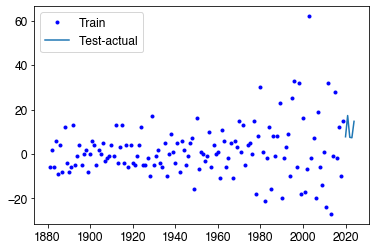

Simon: train 0.943 (1321)
Sincere: train 0.968 (1322)
Skylar: train 0.957 (1323)
Skyler: train 0.983 (1324)
Solomon: train 0.863 (1325)
Sonny: train 0.867 (1326)
Soren: train 0.956 (1327)
Spencer: train 0.968 (1328)
Stacey: train 0.893 (1329)
Stacy: train 0.878 (1330)
Stan: train 0.926 (1331)
Stanford: train 0.792 (1332)
Stanley: train 0.885 (1333)
Stefan: train 0.912 (1334)
Stephan: train 0.932 (1335)
Stephen: train 0.967 (1336)
Stephon: train 0.926 (1337)
Sterling: train 0.906 (1338)
Stetson: train 0.984 (1339)
Steve: train 0.976 (1340)


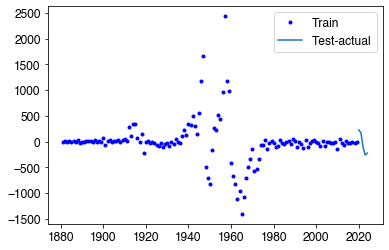

Steven: train 0.973 (1341)
Stevie: train 0.911 (1342)
Stewart: train 0.825 (1343)
Stone: train 0.967 (1344)
Stuart: train 0.897 (1345)
Sullivan: train 0.941 (1346)
Sydney: train 0.901 (1347)
Syed: train 0.918 (1348)
Sylas: train 0.972 (1349)
Sylvester: train 0.844 (1350)
Tad: train 0.874 (1351)
Talon: train 0.960 (1352)
Tanner: train 0.975 (1353)
Tariq: train 0.960 (1354)
Tate: train 0.975 (1355)
Tatum: train 0.960 (1356)
Taylor: train 0.985 (1357)
Ted: train 0.918 (1358)
Teddy: train 0.869 (1359)
Terence: train 0.921 (1360)


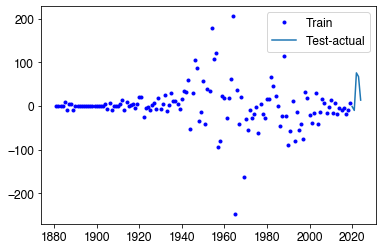

Terrance: train 0.919 (1361)
Terrell: train 0.928 (1362)
Terrence: train 0.925 (1363)
Terry: train 0.916 (1364)
Tevin: train 0.936 (1365)
Thad: train 0.891 (1366)
Thaddeus: train 0.888 (1367)
Theo: train 0.992 (1368)
Theodore: train 0.957 (1369)
Theron: train 0.878 (1370)
Thiago: train 0.990 (1371)
Thomas: train 0.925 (1372)
Thurman: train 0.858 (1373)
Tim: train 0.982 (1374)
Timmy: train 0.971 (1375)
Timothy: train 0.971 (1376)
Titus: train 0.969 (1377)
Tobias: train 0.950 (1378)
Toby: train 0.954 (1379)
Tod: train 0.923 (1380)


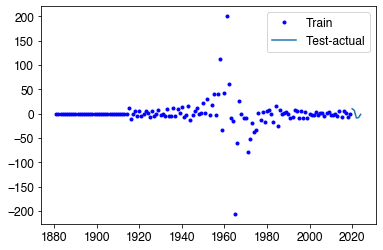

Todd: train 0.991 (1381)
Tom: train 0.973 (1382)
Tomas: train 0.874 (1383)
Tommie: train 0.829 (1384)
Tommy: train 0.866 (1385)
Tony: train 0.983 (1386)
Tory: train 0.961 (1387)
Trace: train 0.959 (1388)
Tracey: train 0.933 (1389)
Tracy: train 0.937 (1390)
Travis: train 0.984 (1391)
Travon: train 0.954 (1392)
Tre: train 0.958 (1393)
Trent: train 0.953 (1394)
Trenton: train 0.970 (1395)
Trever: train 0.958 (1396)
Trevon: train 0.956 (1397)
Trevor: train 0.976 (1398)
Trey: train 0.964 (1399)
Tripp: train 0.975 (1400)


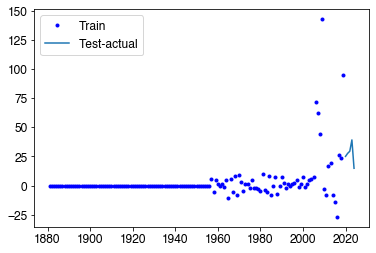

Tristan: train 0.974 (1401)
Tristen: train 0.980 (1402)
Tristian: train 0.980 (1403)
Tristin: train 0.971 (1404)
Triston: train 0.974 (1405)
Troy: train 0.969 (1406)
Truman: train 0.773 (1407)
Tucker: train 0.961 (1408)
Turner: train 0.931 (1409)
Ty: train 0.967 (1410)
Tyler: train 0.994 (1411)
Tylor: train 0.973 (1412)
Tyree: train 0.957 (1413)
Tyrell: train 0.935 (1414)
Tyrese: train 0.939 (1415)
Tyron: train 0.925 (1416)
Tyrone: train 0.937 (1417)
Tyson: train 0.964 (1418)
Ulises: train 0.925 (1419)
Ulysses: train 0.872 (1420)


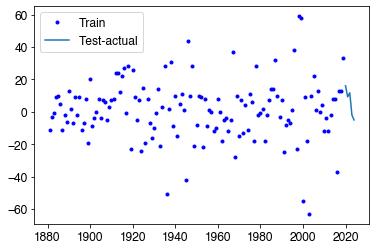

Unknown: train 0.899 (1421)
Uriah: train 0.938 (1422)
Uriel: train 0.945 (1423)
Valentin: train 0.932 (1424)
Valentino: train 0.903 (1425)
Van: train 0.812 (1426)
Vance: train 0.923 (1427)
Vaughn: train 0.883 (1428)
Vern: train 0.828 (1429)
Vernon: train 0.874 (1430)
Vicente: train 0.916 (1431)
Victor: train 0.904 (1432)
Vince: train 0.932 (1433)
Vincent: train 0.971 (1434)
Vincenzo: train 0.937 (1435)
Virgil: train 0.890 (1436)
Vito: train 0.837 (1437)
Vladimir: train 0.922 (1438)
Wade: train 0.914 (1439)
Walker: train 0.962 (1440)


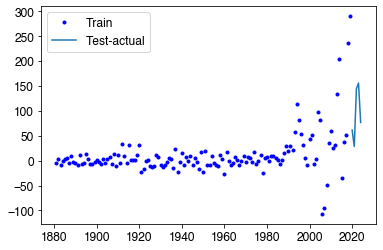

Wallace: train 0.753 (1441)
Walter: train 0.884 (1442)
Ward: train 0.824 (1443)
Warren: train 0.969 (1444)
Waylon: train 0.991 (1445)
Wayne: train 0.937 (1446)
Weldon: train 0.809 (1447)
Wendell: train 0.874 (1448)
Wesley: train 0.952 (1449)
Westley: train 0.939 (1450)
Weston: train 0.975 (1451)
Wilbert: train 0.843 (1452)
Wilbur: train 0.858 (1453)
Wilburn: train 0.812 (1454)
Wiley: train 0.796 (1455)
Wilford: train 0.854 (1456)
Wilfred: train 0.851 (1457)
Wilfredo: train 0.909 (1458)
Will: train 0.923 (1459)
Willard: train 0.850 (1460)


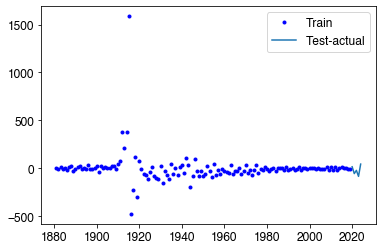

William: train 0.911 (1461)
Willie: train 0.886 (1462)
Willis: train 0.863 (1463)
Wilmer: train 0.873 (1464)
Wilson: train 0.901 (1465)
Wilton: train 0.806 (1466)
Winfred: train 0.831 (1467)
Winston: train 0.882 (1468)
Woodrow: train 0.956 (1469)
Wyatt: train 0.970 (1470)
Xander: train 0.949 (1471)
Xavier: train 0.979 (1472)
Xzavier: train 0.957 (1473)
Yahir: train 0.957 (1474)
Yehuda: train 0.936 (1475)
Yisroel: train 0.937 (1476)
Yosef: train 0.953 (1477)
Yousef: train 0.949 (1478)
Yusuf: train 0.936 (1479)
Zachariah: train 0.972 (1480)


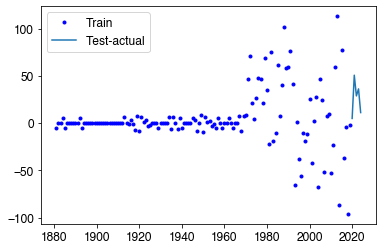

Zachary: train 0.992 (1481)
Zachery: train 0.973 (1482)
Zack: train 0.897 (1483)
Zackary: train 0.981 (1484)
Zackery: train 0.970 (1485)
Zaid: train 0.939 (1486)
Zaiden: train 0.989 (1487)
Zain: train 0.949 (1488)
Zaire: train 0.974 (1489)
Zakary: train 0.938 (1490)
Zander: train 0.974 (1491)
Zane: train 0.957 (1492)
Zavier: train 0.949 (1493)
Zayden: train 0.988 (1494)
Zayn: train 0.970 (1495)
Zayne: train 0.972 (1496)
Zechariah: train 0.937 (1497)
Zeke: train 0.918 (1498)
Zion: train 0.973 (1499)
CPU times: user 4min 58s, sys: 10 s, total: 5min 8s
Wall time: 1min 19s


In [105]:
%%time

#STEP 2: Redo the linear fits to include the complete dataset.

#1. Convert to CHANGE by year (solves most of the negatives problems)
temp_delta = np.diff(cc_norm2) #yes, correct axis (1) is default
temp_bdelta = np.diff(nametest_M_birth) #^same

#2. Start in 1881, since that's the first year we can do diff for
X_examp = np.hstack([temp_delta.T, np.arange(1881,2020).reshape(-1,1)])

n_refits = 20
name_linmodels = []
name_linmodels_dic = {}
test_scores = []

for n in range(len(nametest_M_name)):
    y_examp = temp_bdelta[n,:].T
    
    lin_mod = RidgeCV(cv=n_refits, alphas=[.1])
    
    #With this few data points, I'm throwing the whole thing in for now.
    #The CV is using a subset each time already.
    
    #X_train, X_test, y_train, y_test = train_test_split(X_examp, y_examp, test_size=0.1)
    X_train, y_train = X_examp, y_examp
    lin_mod.fit(X_train, y_train)

    name_linmodels.append(lin_mod)
    
    print('{0}: train {1:.3f} ({2})'.format(nametest_M_name.iloc[n],lin_mod.score(X_train, y_train), n))
    y_pred_fu = lin_mod.predict(X_pred_arima)
    if n%20==0:
        plt.plot(X_train[:,-1], y_train, 'b.')
        #plt.plot(X_test[:,-1], y_test, 'b+')
        #plt.plot(X_test[:,-1], y_pred_st, 'rx')
        #plt.plot(X_examp[-5:,-1], y_examp[-5:], 'c+')
        #plt.plot(X_examp[-5:,-1], y_pred_fu[-5:], 'mx')
        plt.plot(np.arange(2020,2025), y_pred_fu)
        plt.legend(['Train','Test-actual','Test-pred','Val.-actual','Val.-pred'])
        plt.show()
    name_linmodels_dic[nametest_M_name.iloc[n]] = lin_mod

In [106]:
#STEP 3: MAKE NAME PROJECTIONS

n_names = len(nametest_M_name)

name_futures = np.zeros([n_names,5])
for n in range(n_names):
    name_futures[n,:] = name_linmodels[n].predict(X_pred_arima)
    

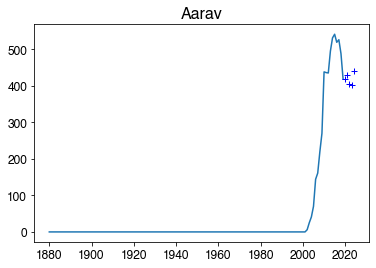

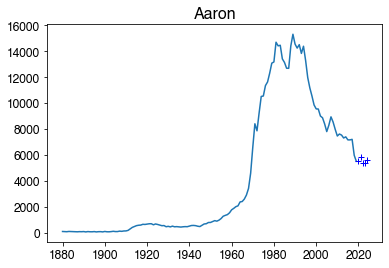

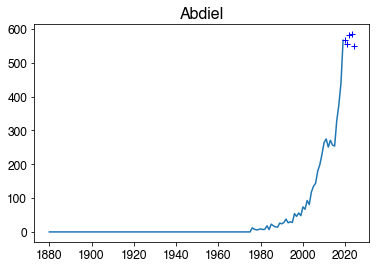

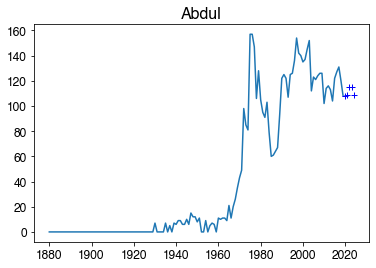

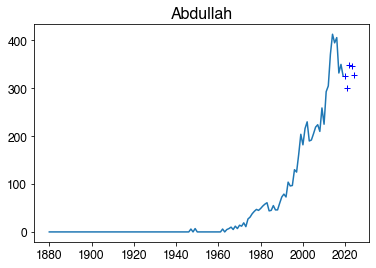

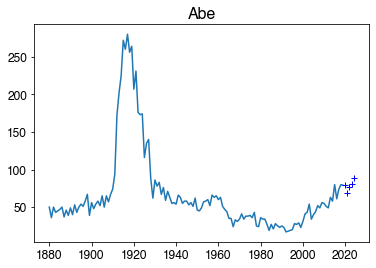

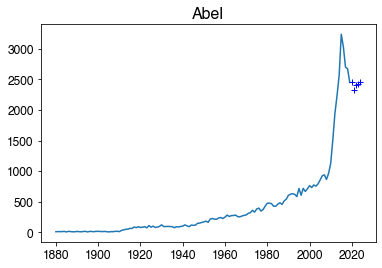

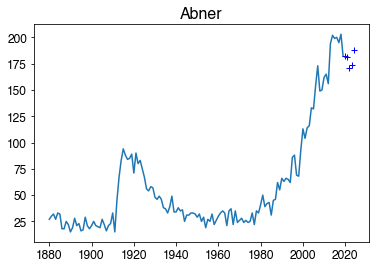

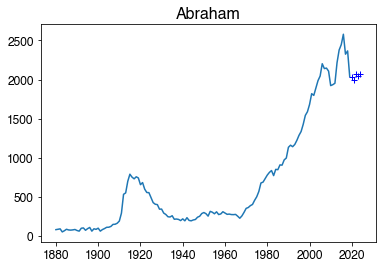

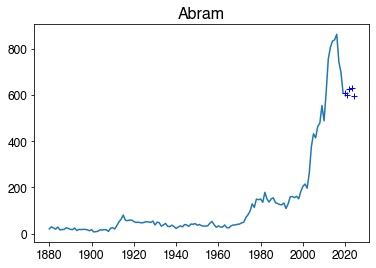

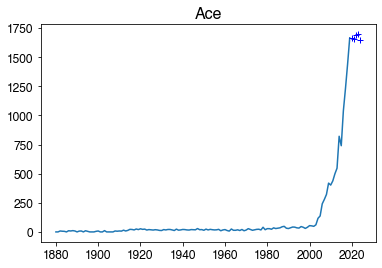

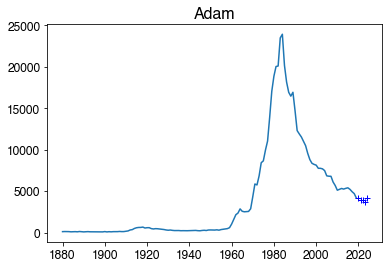

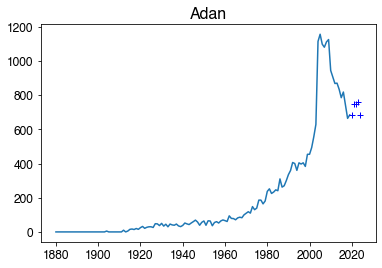

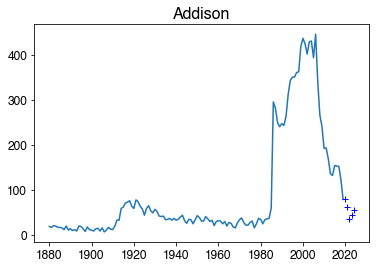

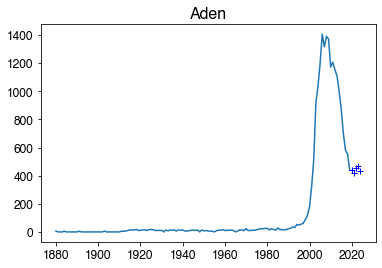

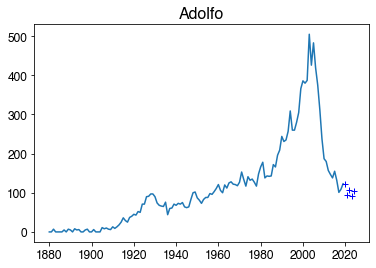

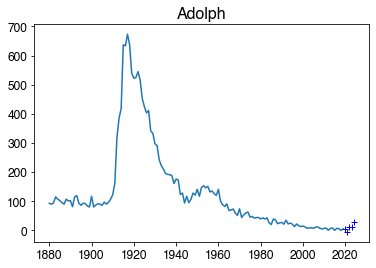

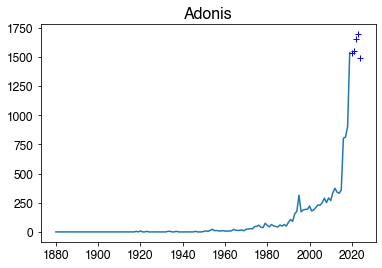

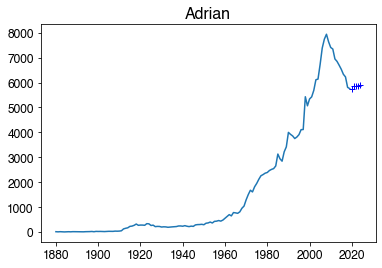

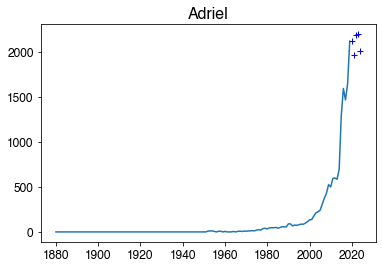

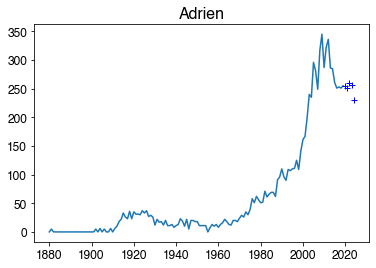

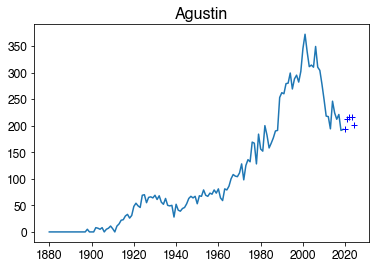

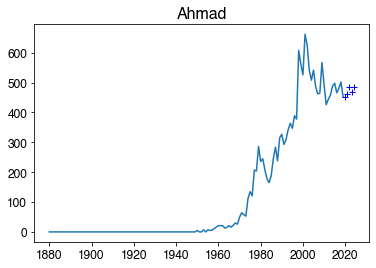

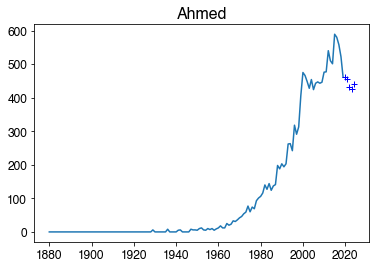

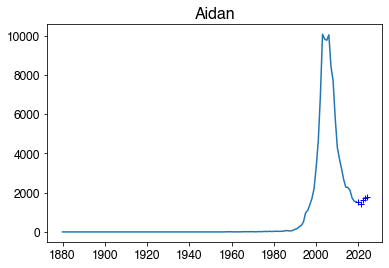

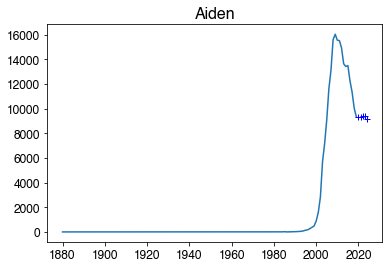

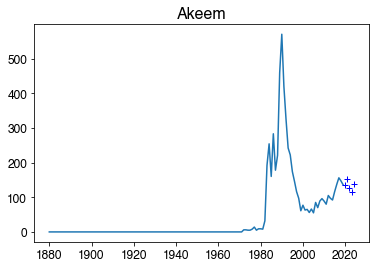

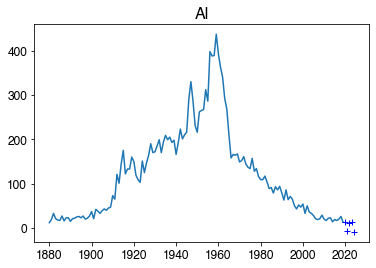

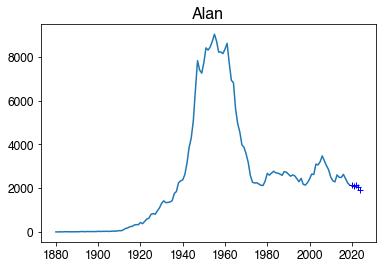

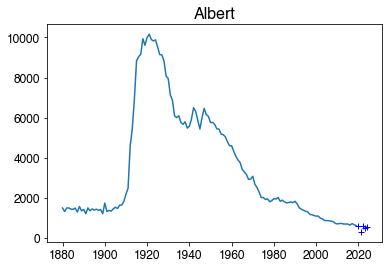

In [109]:
#Testrun: First 30 names

for n in range(30):
    plt.plot(np.arange(1880,2020), nametest_M_birth[n,:])
    plt.plot(np.arange(2020,2025), nametest_M_birth[n,-1] + name_futures[n,:] - name_futures[n,0], 'b+')
    plt.title(nametest_M_name.iloc[n])
    plt.show()

Modifications: I should do a log transform on the data early on, to convert it closer to a normal-distribution range of values, which would respond more appropriately to linear fitting. That's going near the top of the list, it will have a real effect on how well most models can characterize the data. 

Overly-optimistic predictions for near-dead names could be handled better at the individual-name level with ARIMA, despite the drastically slower processing. Similarly, ARIMA would likely also do fairly well avoiding negatives, since the graph tends to flatten as it nears zero. That's largely handled with the transition to yearly change, though. A hybrid model using both could probably do pretty well, but it would be difficult to reasonably fit given the data, and at that point you might want to head into more complex territory like RNN. 

Anyway, predicting names is inherently a difficult problem. We don't have reliable time components to the signal that we can account for, or a massive pile of datapoints. There are generation-related timing elements, but those are close to random, and how long trends persist may be changing. 

Pulling in data on name popularity on a state-by-state basis would help quite a bit, bumping our dataset from about 140 datapoints to about 5000 (some state reporting didn't get going until later if I'm recalling right, so it's not quite 140 x 51). It certainly wouldn't solve the problem by itself! State name trends are strongly correlated with national trends, especially as media increasingly moves away from the local level. State data could significantly help, but it will be necessary to use models that account for correlation between variables. 

Future directions for name trend prediction, in summary:
- More in-depth data transformation prior to analysis/modeling (log or Box-Cox transform built into `pmdarima`, for example)
- Consider multivariate autoregression (i.e. VAR) to model multivariate time series data more effectively (not likely to make the ARIMA fitting feasible for individual names without a days-long run)  
- Consider reweighting recent years. Names with a strong recent increase are at a disadvantage in threshold, despite strong likelihood of continuing future presence. Could weigh name prevalence more highly in the last 3-5 years, for example, both to avoid cutting them off at the threshold stage and to increase the attention the model pays to recent trends? Something to consider.
- Add state data to improve models (at minimum should reduce year-level noise, important now that it's predicting based on yearly change)
- Toss this into an actual user interface/prediction engine. 

In [ ]:
#Assorted fun side comparisons:

#Names in '50 ways to leave your lover' by Paul Simon:
#https://www.azlyrics.com/lyrics/paulsimon/50waystoleaveyourlover.html
#Jack, Stan, Roy, Gus, Lee

#Names in 'Mambo No. 5' by Lou Bega:
#https://www.azlyrics.com/lyrics/loubega/mambono5.html
#Angela, Pamela, Sandra, Rita, Monica, Erica, Rita (again), Tina, Sandra, Mary, Jessica

#Names in '88 lines about 44 wome' by The Nails:
#https://genius.com/The-nails-88-lines-about-44-women-lyrics
#Deborah, Carla, Mary, Susan, Reno, Cathy, Vicki, Kamela, Xylla, Joan, Sherry, Kathleen,
#Seattle, Karen, Jeannie, Mary Ellen, Gloria, Mimi, Marilyn, Julie, Rhonda, Patty, Linda, 
#Katherine, Pauline, Jean-Marie, Gina, Jackie, Sarah, Janet, Tanya, Brenda, Rowena, Dee Dee, 
#Debbie Ray, Nina, Bobbi, Eloise, Terri, Ronnie, Jezebel, Dinah, Judy, Amaranta

#State names:
#(self-evident)

#City names: 
#US cities by population (>100,000):
#https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

#Worldwide cities (>5,000,000):
#https://en.wikipedia.org/wiki/List_of_largest_cities

#Urban vs. rural states:
#https://fivethirtyeight.com/features/how-urban-or-rural-is-your-state-and-what-does-that-mean-for-the-2020-election/
#(Loosely, how many people are within 5 miles of a given census tract)

#Check trendiness: It looks in general like the time course for F
#names may be shorter than the time course for M names. Is that
#true, and if so has it been becoming less true since 2000?

#Could look at that by taking 10-year chunks (looks like about the
#right length to capture a rising or falling trend) and seeing which
#names correlate together for each chunk? Automatic grouping based
#on "trendiness" would be pretty cool. 

#Extend data: I could also cross-correlate names with Google ngrams 
#results for that name, that would be a nice comparison. Excellent
#proxy for whether a name is culturally established!

#Extend data: Cross-correlate artists who made the Billboard top 10
#using their names (i.e. Alanis). Only include cases where the name
#is in both, so simple inner join would be ideal. 


In [ ]:
plt.su